In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
import awkward as ak
import MyHelpers as mh
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed


#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.24/00


In [2]:
#Getting files
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_14TeV_PU200_NTUPLE_jobs123merge_version4.root'
#load the file content
tree = uproot.open(filename+":myana/mytree")
tree.show()

filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [184]:
#Create signal tree
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'], '(abs(genproton_xi)> 0.0032) & (abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')  
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 
#
#Create background tree
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [185]:
print((protons.genproton_xi< 0.0052))
def SmearPosProtonMomentum(proton_from_event):
    XI_RES=0.02 # use 2% for now
    pr=proton_from_event
    xi_smear = np.random.normal(0,abs(ak.to_numpy(pr.genproton_xi))*XI_RES)
    pr.genproton_xi = pr.genproton_xi + xi_smear
    pr.genproton_pz = pr.genproton_pz + 7000*xi_smear         
    #return corrected array of protons
    return pr

def SmearNegProtonMomentum(proton_from_event):
    XI_RES=0.02 # use 2% for now
    pr=proton_from_event
    xi_smear = np.random.normal(0,abs(ak.to_numpy(pr.genproton_xi))*XI_RES)
    pr.genproton_xi = pr.genproton_xi - xi_smear
    pr.genproton_pz = pr.genproton_pz - 7000*xi_smear         
    #return corrected array of protons
    return pr

def SelProtons(proton_from_event, mu1, mu2):
    sqrt_s = 14000
    #4990
    PZ_MIN=4990; PZ_MAX=6999.99
    pr=proton_from_event
    # accepted proton indices
    proton_neg_idx_acc=np.where(ak.to_numpy((pr.genproton_pz<-PZ_MIN) & (pr.genproton_pz>-PZ_MAX) ))[0]
    proton_pos_idx_acc=np.where(ak.to_numpy((pr.genproton_pz>PZ_MIN) & (pr.genproton_pz< PZ_MAX) ))[0]
    # accepted protons
    proton1 = pr[proton_pos_idx_acc]
    proton2 = pr[proton_neg_idx_acc]
    # smearing proton momenta
    #SmearPosProtonMomentum(proton1)
    #SmearNegProtonMomentum(proton2)    
    # di-muon kinematics
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s) 
    #get protons with closest xi values to the reconstructed muons from the list of accepted protons
    proton_idx1_acc = ak.to_numpy(abs(proton1.genproton_xi-xi_dimu_plus)).argmin()
    proton_idx2_acc = ak.to_numpy(abs(proton2.genproton_xi-xi_dimu_minus)).argmin()
    # get the proton index for the full list of protons:
    proton_idx1 = proton_pos_idx_acc[proton_idx1_acc]   
    proton_idx2 = proton_neg_idx_acc[proton_idx2_acc]

    # return proton indices   
    return proton_idx1, proton_idx2



[[False, False, False, False, False, False, ... False, False, False, False, False]]


In [ ]:
#define data array for signal
sig_data = {}
mh.InitData(sig_data)
b = 0
s = 0
#loop over all events for the signal
N = len(muons)
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue    
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    # find two signal protons:
    pr=protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = SelProtons(pr,mu1,mu2)
    if pr1_idx<0 or pr2_idx<0: continue
    print(pr1_idx)
    print(pr2_idx)
    #if (pr1_idx > 1) or (pr2_idx >1):
    #    b = b+1 
    #else:s = s+1
    #print(pr2_idx)
    vx = vertices[i]
    ev = event_info[i]
    mh.Fill_mu(sig_data, mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(sig_data,pr,pr1_idx,pr2_idx,vx,ev)
    #print(b)
    #print(s)
sig = pd.DataFrame(data=sig_data)

#define data array for Background
bg_data = {}
mh.InitData(bg_data)
#loop over all events for the background
n = len(bg_muons)
for i in tqdm(range(n)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    # find two signal protons:
    pr=bg_protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = SelProtons(pr, mu1, mu2)
    #if pr1_idx<0 or pr2_idx<0: continue
    vx = bg_vertices[i]
    ev = bg_event_info[i]
    mh.Fill_mu(bg_data,mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(bg_data,pr,pr1_idx,pr2_idx,vx,ev)
bg = pd.DataFrame(data=bg_data)


  0%|          | 0/600 [00:00<?, ?it/s]

[0.0116, 0.196, 0.147, 0.236, 0.00623, 0.219, 0.193]
[0.00435, 0.279, 0.0407, 0.00447, 0.197, ... 0.26, 0.00999, 0.115, 0.282, 0.0146]
0.002434087083028096
0.011536471611117502
[0.0111, 0.237, 0.0258, 0.008, 0.128, 0.114, 0.0101, 0.163, 0.231, 0.189]
[0.0146, 0.0119, 0.014, 0.137, 0.116, 0.175, 0.225, 0.12]
0.01452789388864231
0.011065525593938162
[0.0305, 0.283, 0.216, 0.28, 0.0516, 0.233, 0.037, 0.00749, 0.284, 0.286]
[0.0607, 0.0676, 0.153, 0.27, 0.0701, 0.152, 0.0964, 0.0927, 0.133]
0.0005261302329404034
0.0310151358332106
[0.0264, 0.00887, 0.151, 0.0573, 0.206]
[0.193, 0.11, 0.0148, 0.19, 0.0442, 0.047]
0.0006109505693510813
0.026730629880366893


  2%|▏         | 13/600 [00:00<00:04, 122.61it/s]

[0.00464, 0.0295, 0.281, 0.12, 0.224, 0.249, 0.131, 0.251]
[0.00727, 0.185, 0.271, 0.209, 0.036, ... 0.0339, 0.0121, 0.053, 0.0342, 0.00655]
0.0071722838228180565
0.0046170644308334416
[0.0135, 0.196, 0.118, 0.125, 0.0122, 0.0187, 0.021, 0.0386, 0.28, 0.0443]
[0.235, 0.215, 0.019, 0.143, 0.107, 0.031]
0.00098501332535155
0.013289065042370663
[0.0344, 0.105, 0.0385, 0.184, 0.228, 0.093, ... 0.237, 0.0188, 0.0404, 0.273, 0.243]
[0.0174, 0.256, 0.00568, 0.0146, 0.096, 0.00381, 0.0292, 0.0161, 0.174]
0.0004745336638061479
0.033526387148292126
[0.0402, 0.0376, 0.287, 0.00342, 0.153, ... 0.235, 0.0821, 0.266, 0.00447, 0.0907]
[0.0238, 0.114, 0.0262, 0.00599, 0.266, 0.21, 0.00461, 0.0218]
0.02395902701709983
0.000914448454085496
[0.0772, 0.00892, 0.00371, 0.00463, 0.0208]
[0.0368, 0.234, 0.264, 0.00969, 0.043, 0.174, 0.027, 0.207, 0.0712]
0.03741914576855834
0.07908913423577457
[0.00966, 0.00357, 0.0049, 0.187, 0.0861, ... 0.157, 0.00665, 0.00563, 0.0329, 0.205]
[0.00988, 0.0524, 0.0195, 0.02

  5%|▍         | 29/600 [00:00<00:04, 141.02it/s]

[0.00331, 0.149, 0.152, 0.128, 0.0128, ... 0.235, 0.0692, 0.136, 0.252, 0.283]
[0.0184, 0.282, 0.274, 0.199, 0.205, 0.225, 0.274, 0.00594, 0.0105]
0.01816854602844345
0.0033221217207297714
[0.0265, 0.257, 0.0998, 0.0113, 0.0138, ... 0.11, 0.0158, 0.214, 0.00687, 0.0696]
[0.279, 0.231, 0.016, 0.101]
0.0008949588409717727
0.02637426688358562
[0.0198, 0.104, 0.1, 0.267, 0.211, 0.154, 0.00832, 0.0114]
[0.15, 0.0603, 0.079, 0.286, 0.0297, 0.0157, 0.0919, 0.0176, 0.0601, 0.0108]
0.0023853202274049558
0.01969810759294652
[0.222, 0.0663, 0.00867, 0.00458, 0.00895, 0.226, 0.0983, 0.1, 0.278]
[0.0073, 0.00707, 0.044, 0.191, 0.00689, 0.266, 0.0682, 0.0929, 0.211]
0.0074801208395299315
0.0030595023739502926
[0.00467, 0.00498, 0.105, 0.0385, 0.184, ... 0.195, 0.237, 0.0188, 0.0404, 0.273]
[0.0036, 0.0174, 0.256, 0.00568, 0.0146, 0.096, 0.00381, 0.0292, 0.0161]
0.0035864300918657323
0.004650231989939292
[0.0135, 0.00892, 0.00371, 0.00463, 0.0208]
[0.043, 0.174, 0.027, 0.207, 0.0712, 0.139, 0.1]
0.00

  7%|▋         | 44/600 [00:00<00:04, 136.81it/s]


[0.00507, 0.128, 0.0128, 0.00602, 0.235, ... 0.0642, 0.00429, 0.222, 0.18, 0.272]
[0.00657, 0.205, 0.225, 0.274, 0.00594, 0.0105, 0.27, 0.229, 0.025]
0.00657118726781849
0.005069395346539266
[0.205, 0.098, 0.0114, 0.11, 0.0158, 0.214, 0.00687, 0.0696, 0.285, 0.23, 0.246]
[0.0238, 0.101, 0.276, 0.0393]
0.023731208122585324
0.0031929642153581458
[0.0338, 0.00445, 0.0817, 0.0584, 0.252, ... 0.00363, 0.174, 0.126, 0.00873, 0.12]
[0.0347, 0.00461, 0.272, 0.121, 0.239, ... 0.00458, 0.0141, 0.149, 0.105, 0.219]
0.03474153634875872
0.03377224021326086
[0.0108, 0.104, 0.1, 0.267, 0.211, 0.154, 0.00832, 0.0114]
[0.0101, 0.0603, 0.079, 0.286, 0.0297, ... 0.0919, 0.0176, 0.0601, 0.0108, 0.231]
0.010197922822624484
0.010877010691518009
[0.00353, 0.0132, 0.0198, 0.149, 0.152, ... 0.235, 0.0692, 0.136, 0.252, 0.283]
[0.00566, 0.0308, 0.218, 0.221, 0.282, ... 0.199, 0.205, 0.225, 0.274, 0.00594]
0.005676920453433443
0.003561317816162083
[0.0442, 0.0197, 0.00322, 0.189, 0.203, ... 0.00746, 0.0395, 0.1

 13%|█▎        | 78/600 [00:00<00:03, 151.50it/s]

[0.00618, 0.147, 0.236, 0.00623, 0.219, 0.193, 0.00849, 0.0369]
[0.0407, 0.00447, 0.197, 0.0144, 0.26, 0.00999, 0.115, 0.282, 0.0146, 0.278]
0.002802800291394629
0.00616845405817749
[0.00326, 0.0258, 0.008, 0.128, 0.114, ... 0.231, 0.189, 0.215, 0.00887, 0.00462]
[0.0357, 0.0119, 0.014, 0.137, 0.116, 0.175, 0.225, 0.12, 0.184, 0.131]
0.035812560809601726
0.0032585006516899313
[0.284, 0.286, 0.276, 0.226, 0.0836, 0.011]
[0.0138, 0.0701, 0.152, 0.0964, 0.0927, 0.133, 0.0699, 0.245, 0.00384]
0.013827382934425824
0.0014509437237517596
[0.0266, 0.151, 0.0573, 0.206, 0.161, 0.152, ... 0.0642, 0.241, 0.276, 0.0653, 0.275]
[0.047, 0.0271, 0.175, 0.0498, 0.0137, 0.0211, 0.18, 0.0616]
0.0015234399864970862
0.02632700453862306
[0.0127, 0.251, 0.0037, 0.255, 0.0434]
[0.00655, 0.232, 0.00579, 0.00547, 0.128, 0.172, 0.1]
0.0015296498699067585
0.012866802055354232
[0.016, 0.023, 0.0942, 0.00425, 0.228, 0.0132, 0.0198, 0.149, 0.152]
[0.0266, 0.00597, 0.267, 0.00823, 0.0573, ... 0.218, 0.221, 0.282, 0.

 19%|█▉        | 113/600 [00:00<00:03, 158.04it/s]

[0.00891, 0.257, 0.0998, 0.0113, 0.0138, ... 0.0114, 0.11, 0.0158, 0.214, 0.00687]
[0.0177, 0.0826, 0.279, 0.231, 0.016, 0.101]
0.01703138616676799
0.0024585553407183718
[0.0104, 0.0989, 0.00829, 0.236, 0.0774, 0.0113, 0.0197, 0.283, 0.00523, 0.0533]
[0.00392, 0.0305, 0.00989, 0.00538, 0.046, ... 0.0111, 0.17, 0.0199, 0.267, 0.18]
0.003887893594225616
0.010308217848389341
[0.0318, 0.203, 0.0926, 0.169, 0.205, ... 0.00646, 0.259, 0.242, 0.211, 0.0115]
[0.184, 0.0467, 0.0361, 0.162, 0.029, 0.206, 0.191]
0.0013976345809579072
0.03134739834200565
[0.00912, 0.0197, 0.00322, 0.189, 0.203, 0.257, 0.00746, 0.0395, 0.174, 0.0868]
[0.00753, 0.0035, 0.149, 0.00485, 0.011, 0.00825, 0.00393, 0.107, 0.102, 0.203]
0.007483455684688193
0.009162558573031514
[0.00842, 0.0461, 0.00358, 0.0182, 0.261, 0.222]
[0.0132, 0.287, 0.287, 0.12, 0.00405, ... 0.012, 0.00656, 0.00707, 0.044, 0.191]
0.012965918844795941
0.008407479623577463
[0.253, 0.285, 0.00498, 0.105, 0.0385, 0.184, 0.228, 0.093, 0.176]
[0.0294, 0

 22%|██▏       | 129/600 [00:00<00:03, 151.00it/s]

[0.00638, 0.0502, 0.213, 0.0277, 0.22, 0.28]
[0.00378, 0.0193, 0.175, 0.072]
0.003802069917585733
0.006413751442447835
[0.211, 0.154, 0.00832, 0.0114, 0.0409, 0.00434, 0.0882, 0.199]
[0.0147, 0.0297, 0.0157, 0.0919, 0.0176, 0.0601, 0.0108, 0.231, 0.255]
0.014652475262985932
0.0020832761067475346
[0.0336, 0.00458, 0.00895, 0.226, 0.0983, ... 0.00661, 0.0305, 0.191, 0.155, 0.0823]
[0.0172, 0.0929, 0.211, 0.00611, 0.233, 0.195, 0.0366, 0.189]
0.016978652075090393
0.03368040356625308
[0.00388, 0.016, 0.023, 0.0942, 0.00425, ... 0.0198, 0.149, 0.152, 0.128, 0.0128]
[0.0396, 0.188, 0.253, 0.211, 0.00597, 0.267, ... 0.274, 0.199, 0.205, 0.225, 0.274]
0.0391093283213668
0.003872857225217142
[0.0101, 0.267, 0.0138, 0.128, 0.0932, ... 0.098, 0.0114, 0.11, 0.0158, 0.214]
[0.00761, 0.0834, 0.219, 0.13, 0.237, 0.252, 0.169, 0.0826, 0.279, 0.231, 0.016]
0.0076044044566021774
0.010089697671452433
[0.00533, 0.107, 0.102, 0.125, 0.136, 0.0048, 0.126, 0.00445]
[0.00455, 0.0474, 0.273, 0.136, 0.277, 0.17

 25%|██▌       | 150/600 [00:00<00:02, 167.10it/s]

[0.00425, 0.228, 0.0132, 0.0198, 0.149, 0.152, 0.128, 0.0128, 0.00602]
[0.0291, 0.00823, 0.0573, 0.0308, 0.218, ... 0.199, 0.205, 0.225, 0.274, 0.00594]
0.029463548183967136
0.003166139065520004
[0.0083, 0.0138, 0.128, 0.0932, 0.00891, ... 0.205, 0.098, 0.226, 0.0836, 0.011]
[0.0129, 0.0834, 0.219, 0.13, 0.237, 0.252, ... 0.279, 0.231, 0.016, 0.245, 0.00384]
0.06916435180720286
0.001492107535822283
[0.00668, 0.12, 0.0529, 0.0288, 0.209, ... 0.0516, 0.233, 0.037, 0.00749, 0.284]
[0.00347, 0.135, 0.0071, 0.126, 0.0294, ... 0.0607, 0.0676, 0.153, 0.27, 0.0701]
0.0034858041979432325
0.0067070353445615495
[0.0191, 0.26, 0.0126, 0.165, 0.0701, 0.0811, 0.00762, 0.202, 0.286, 0.21]
[0.0226, 0.0202, 0.129, 0.192, 0.15, ... 0.139, 0.00718, 0.119, 0.00858, 0.0992]
0.022661534860994
0.0009608580359211352
[0.00556, 0.205, 0.261, 0.158, 0.12, 0.0529, ... 0.00874, 0.283, 0.216, 0.28, 0.0516]
[0.0444, 0.151, 0.0325, 0.17, 0.135, ... 0.126, 0.0294, 0.262, 0.0043, 0.0607]
0.044379181699547784
0.00060240

 28%|██▊       | 167/600 [00:01<00:02, 162.67it/s]


[0.00826, 0.0653, 0.275, 0.147, 0.203, ... 0.00646, 0.259, 0.242, 0.211, 0.0115]
[0.00389, 0.0616, 0.184, 0.0467, 0.0361, 0.162, 0.029, 0.206, 0.191]
0.0038620959893180986
0.008287574102045942
[0.0241, 0.0434, 0.166, 0.0489, 0.00635, 0.0174, 0.169, 0.0781, 0.048]
[0.1, 0.138, 0.175, 0.019, 0.278, 0.206, 0.0034, 0.197, 0.167]
0.0009124682473790566
0.024302111777856773
[0.0197, 0.00322, 0.189, 0.203, 0.257, 0.00746]
[0.0523, 0.0648, 0.0035, 0.149, 0.00485, 0.011, 0.00825, 0.00393, 0.107, 0.102]
0.05314077012537358
0.0031598704632309934
[0.00653, 0.149, 0.152, 0.128, 0.0128, ... 0.235, 0.0692, 0.136, 0.252, 0.283]
[0.0187, 0.282, 0.274, 0.199, 0.205, 0.225, 0.274, 0.00594, 0.0105, 0.27]
0.018604439781474545
0.00651577159857302
[0.0565, 0.136, 0.0048, 0.126, 0.00445, ... 0.252, 0.092, 0.254, 0.00363, 0.174]
[0.0047, 0.176, 0.154, 0.235, 0.234, ... 0.121, 0.239, 0.265, 0.114, 0.00458]
0.004709717670056348
0.05590715019724697
[0.0039, 0.176, 0.263, 0.279, 0.0332, 0.222, ... 0.0404, 0.273, 0

 31%|███       | 186/600 [00:01<00:02, 166.93it/s]

[0.00979, 0.0126, 0.00556, 0.205, 0.261, ... 0.0288, 0.209, 0.00874, 0.283, 0.216]
[0.00937, 0.0272, 0.151, 0.0325, 0.17, ... 0.126, 0.0294, 0.262, 0.0043, 0.0607]
0.009281498478192938
0.009755629550173292
[0.00891, 0.257, 0.0998, 0.0113, 0.0138, ... 0.0114, 0.11, 0.0158, 0.214, 0.00687]
[0.00743, 0.252, 0.169, 0.0826, 0.279, 0.231, 0.016, 0.101]
0.007438371415036246
0.002428004392695175
[0.0153, 0.0468, 0.00357, 0.0049, 0.187, 0.0861, 0.0096]
[0.168, 0.0569, 0.246, 0.225, 0.0378, 0.0524, 0.0195, 0.0214]
0.0011955413121740321
0.015188512918129707
[0.00821, 0.203, 0.226, 0.281, 0.283]
[0.00406, 0.167, 0.253, 0.285, 0.203, ... 0.0703, 0.283, 0.0361, 0.155, 0.0125]
0.004068693040186335
0.008123072181385223
[0.0127, 0.00934, 0.265, 0.0414, 0.00326, 0.00574, 0.00687, 0.0447, 0.227]
[0.00608, 0.0095, 0.173, 0.0043, 0.0245, ... 0.0217, 0.0234, 0.0692, 0.00363, 0.243]
0.006082032752043622
0.012762020661061517
[0.00793, 0.00849, 0.0369, 0.212, 0.23, 0.281, 0.0114, 0.00756]
[0.16, 0.0146, 0.278,

 35%|███▍      | 208/600 [00:01<00:02, 178.63it/s]

[0.0238, 0.0642, 0.00429, 0.222, 0.18, 0.272, 0.00849, 0.0267, 0.00643]
[0.0105, 0.27, 0.229, 0.025, 0.102, ... 0.00329, 0.0119, 0.00347, 0.259, 0.211]
0.0006299980281422301
0.023907982141133086
[0.0105, 0.0305, 0.191, 0.155, 0.0823, 0.0295, 0.281, 0.12, 0.224]
[0.189, 0.185, 0.271, 0.209, 0.036, 0.0543]
0.001935048412071422
0.010384699623243777
[0.0103, 0.203, 0.257, 0.00746, 0.0395, ... 0.265, 0.0414, 0.00326, 0.00574, 0.00687]
[0.00825, 0.00393, 0.107, 0.102, 0.203, ... 0.0095, 0.173, 0.0043, 0.0245, 0.027]
0.0031875674027653715
0.020049951293084293
[0.0446, 0.00623, 0.219, 0.193, 0.00849, 0.0369, 0.212, 0.23, 0.281, 0.0114]
[0.197, 0.0144, 0.26, 0.00999, 0.115, 0.282, 0.0146, 0.278]
0.0010422067010522978
0.04581692478153365
[0.00395, 0.0101, 0.163, 0.231, 0.189, 0.215, 0.00887, 0.00462]
[0.0317, 0.137, 0.116, 0.175, 0.225, 0.12, 0.184, 0.131, 0.00833, 0.0288]
0.031496530807506466
0.003927376703603757
[0.233, 0.037, 0.00749, 0.284, 0.286]
[0.00929, 0.0676, 0.153, 0.27, 0.0701, 0.152

 38%|███▊      | 227/600 [00:01<00:02, 178.89it/s]

[0.105, 0.0385, 0.184, 0.228, 0.093, 0.176, ... 0.237, 0.0188, 0.0404, 0.273, 0.243]
[0.0106, 0.0174, 0.256, 0.00568, 0.0146, ... 0.00381, 0.0292, 0.0161, 0.174, 0.148]
0.010440867495169402
0.002118690108368058
[0.00982, 0.00612, 0.169, 0.163, 0.0824, 0.0197, 0.00322, 0.189]
[0.263, 0.135, 0.169, 0.00491, 0.0648, 0.0035, 0.149]
0.0030798959827188373
0.009793222527137465
[0.0285, 0.0267, 0.00643, 0.0155, 0.196, 0.147]
[0.00329, 0.0119, 0.00347, 0.259, 0.211, ... 0.0312, 0.0448, 0.00435, 0.279, 0.0407]
0.0007612047842368198
0.02887664514944685
[0.00796, 0.0882, 0.199, 0.143]
[0.00891, 0.255, 0.103, 0.122, 0.118, 0.193, 0.11, 0.0148]
0.008988113583822836
0.008185808666770092
[0.0305, 0.191, 0.155, 0.0823, 0.0295, 0.281, 0.12, 0.224]
[0.00945, 0.189, 0.185, 0.271, 0.209, 0.036, 0.0543, 0.225, 0.164]
0.0095339613959023
0.0018532518479598343
[0.149, 0.0471, 0.00717, 0.13, 0.212, ... 0.0128, 0.245, 0.0619, 0.0348, 0.144]
[0.00959, 0.02, 0.0293, 0.0429, 0.0103, 0.269]
0.009601165181061357
0.00

 44%|████▍     | 266/600 [00:01<00:01, 183.06it/s]

[0.0414, 0.016, 0.283]
[0.00743, 0.106, 0.216, 0.0482, 0.0348, 0.234, 0.264, 0.00969, 0.043]
0.007407430374686725
0.002255986402708672
[0.00405, 0.00462, 0.0502, 0.213, 0.0277, 0.22, 0.28, 0.00852, 0.23]
[0.0073, 0.0193, 0.175, 0.072]
0.007377277050082154
0.004056295042111555
[0.00635, 0.0174, 0.169, 0.0781, 0.048, 0.203]
[0.0191, 0.175, 0.019, 0.278, 0.206, 0.0034, ... 0.167, 0.253, 0.285, 0.203, 0.00327]
0.018422458276051972
0.0019092872529234974
[0.0102, 0.0323, 0.027, 0.149, 0.0471, ... 0.00766, 0.0136, 0.16, 0.0128, 0.245]
[0.0843, 0.278, 0.00369, 0.197, 0.02, 0.0293, 0.0429, 0.0103]
0.0014004863484389839
0.010209149528593925
[0.00478, 0.0861, 0.0096, 0.0192, 0.0298, ... 0.00563, 0.0329, 0.205, 0.0461]
[0.0171, 0.0214, 0.0548, 0.0556, 0.0718, ... 0.287, 0.287, 0.12, 0.00405, 0.00591]
0.01714654035552523
0.004803569451304774
[0.0197, 0.016, 0.283, 0.00892, 0.00371, 0.00463]
[0.00437, 0.216, 0.0482, 0.0348, 0.234, ... 0.00969, 0.043, 0.174, 0.027, 0.207]
0.004331779348418217
0.01951

 48%|████▊     | 287/600 [00:01<00:01, 188.97it/s]


0.032433862302064076
[0.036, 0.016, 0.023, 0.0942, 0.00425, ... 0.0132, 0.0198, 0.149, 0.152, 0.128]
[0.00391, 0.253, 0.211, 0.00597, 0.267, ... 0.282, 0.274, 0.199, 0.205, 0.225]
0.0038854354026389096
0.03580771760006952
[0.176, 0.263, 0.279, 0.0332, 0.222, 0.194, ... 0.0188, 0.0404, 0.273, 0.243, 0.186]
[0.0157, 0.256, 0.00568, 0.0146, 0.096, ... 0.0161, 0.174, 0.148, 0.228, 0.238]
0.015624301103717852
0.0020789755363452354
[0.0323, 0.0208, 0.0321, 0.0562, 0.192, 0.00414, 0.123, 0.217]
[0.207, 0.0712, 0.139, 0.1, 0.13]
0.0008932263432356908
0.03265495372289743
[0.00424, 0.0861, 0.0096, 0.0192, 0.0298, ... 0.00563, 0.0329, 0.205, 0.0461]
[0.00565, 0.0195, 0.0214, 0.0548, 0.0556, ... 0.261, 0.287, 0.287, 0.12, 0.00405]
0.00562221832853739
0.004216711654737663
[0.0315, 0.283, 0.216, 0.28, 0.0516, 0.233, 0.037, 0.00749, 0.284, 0.286]
[0.00586, 0.0607, 0.0676, 0.153, 0.27, 0.0701, 0.152, 0.0964, 0.0927, 0.133]
0.0058794861488247595
0.03165802115597639
[0.00887, 0.151, 0.0573, 0.206, 0.16

 54%|█████▍    | 326/600 [00:01<00:01, 182.60it/s]

[0.0167, 0.00462, 0.225, 0.244, 0.00609, 0.0919, 0.0103, 0.0751, 0.0089, 0.0414]
[0.00833, 0.0288, 0.0154, 0.221, 0.131, ... 0.138, 0.0377, 0.0705, 0.0293, 0.106]
0.00162129625367806
0.016632394636588176
[0.00603, 0.00462, 0.0502, 0.213]
[0.00378, 0.177, 0.158, 0.0193]
0.0037687223856962696
0.006005954359635994
[0.0194, 0.13, 0.212, 0.0592, 0.00766, ... 0.273, 0.191, 0.181, 0.0634, 0.077]
[0.0429, 0.0103, 0.269, 0.00592, 0.256, 0.248, 0.142, 0.0266]
0.0010229357131316063
0.019860342666800417
[0.00665, 0.00563, 0.0329, 0.205, 0.0461, 0.00358, 0.0182]
[0.0197, 0.0556, 0.0718, 0.00552, 0.261, ... 0.12, 0.00405, 0.00591, 0.00498, 0.18]
0.019510619289300285
0.0007410134373019629
[0.00493, 0.0989, 0.00829, 0.236, 0.0774, 0.0113, 0.0197]
[0.00821, 0.0305, 0.00989, 0.00538, 0.046, 0.265, 0.00445, 0.226, 0.0111, 0.17]
0.008241010863129311
0.004953426912793741
[0.0184, 0.274, 0.0169, 0.00354, 0.00415, 0.099, 0.00752, 0.00963, 0.128]
[0.0874, 0.168, 0.126, 0.285, 0.00977, 0.103, 0.0229, 0.0171, 0

 60%|██████    | 362/600 [00:02<00:01, 160.25it/s]

[0.00892, 0.00371, 0.226, 0.0983, 0.1, 0.278]
[0.00803, 0.216, 0.0482, 0.0348, 0.234, 0.264, 0.00969, 0.043, 0.174]
0.007985544596757056
0.0020469038441546065
[0.00955, 0.093, 0.176, 0.263, 0.279, ... 0.0188, 0.0404, 0.273, 0.243, 0.186]
[0.00434, 0.256, 0.00568, 0.0146, 0.096, ... 0.0292, 0.0161, 0.174, 0.148, 0.228]
0.004352611072159267
0.0095722530326228
[0.0208, 0.0321, 0.0562, 0.192, 0.00414, 0.123, 0.217, 0.00658, 0.107]
[0.0669, 0.0712, 0.139, 0.1, 0.13, 0.0474, 0.273, 0.136]
0.06540881895948199
0.0010750843555509917
[0.0171, 0.00892, 0.00371, 0.00463]
[0.216, 0.0482, 0.0348, 0.234, 0.264, 0.00969, 0.043, 0.174, 0.027, 0.207]
0.0015056230316170662
0.01698824966684058
[0.0116, 0.0502, 0.213, 0.0277, 0.22, 0.28, 0.00852]
[0.00542, 0.0193, 0.175, 0.072]
0.005412932557512235
0.011535511458963992
[0.0247, 0.259, 0.242, 0.211, 0.0115, 0.0468, 0.00357, 0.0049, 0.187]
[0.0114, 0.206, 0.191, 0.168, 0.0569, 0.246, 0.225, 0.0378]
0.011389515935710916
0.024724683847885204
[0.169, 0.0781, 0.

 63%|██████▎   | 380/600 [00:02<00:01, 163.28it/s]

[0.00813, 0.228, 0.0132, 0.0198, 0.149, ... 0.0128, 0.00602, 0.235, 0.0692, 0.136]
[0.00823, 0.0573, 0.0308, 0.218, 0.221, ... 0.199, 0.205, 0.225, 0.274, 0.00594]
0.0018299493596119305
0.008119099701701379
[0.031, 0.0932, 0.00891, 0.257, 0.0998, ... 0.0114, 0.11, 0.0158, 0.214, 0.00687]
[0.00472, 0.219, 0.13, 0.237, 0.252, 0.169, 0.0826, 0.279, 0.231, 0.016]
0.004665041188736342
0.03087138224759128
[0.007, 0.102, 0.125, 0.136, 0.0048, 0.126, 0.00445, 0.0817, 0.0584]
[0.0094, 0.277, 0.176, 0.154, 0.235, 0.234, 0.00461, 0.272, 0.121]
0.009558331585556003
0.007007800444492881
[0.0111, 0.261, 0.222, 0.0663, 0.00867, 0.00458, 0.00895, 0.226, 0.0983, 0.1]
[0.00656, 0.00707, 0.044, 0.191, 0.00689, 0.266, 0.0682, 0.0929, 0.211]
0.0013290259854468146
0.011109748457510006
[0.00895, 0.226, 0.0983, 0.1, 0.278, 0.178, 0.106, 0.00661, 0.0305]
[0.021, 0.00611, 0.233, 0.195, 0.0366, 0.189]
0.021058569046946418
0.0006687094306497283
[0.0213, 0.0188, 0.0404, 0.273, 0.243, ... 0.121, 0.00574, 0.254, 0.2

 70%|██████▉   | 419/600 [00:02<00:01, 176.36it/s]

[0.013, 0.12, 0.0126, 0.00556, 0.205, 0.261, 0.158, 0.12, 0.0529, 0.0288, 0.209]
[0.149, 0.105, 0.219, 0.0272, 0.151, ... 0.0071, 0.126, 0.0294, 0.262, 0.0043]
0.002533746777568075
0.012959474259510561
[0.00413, 0.215, 0.00887, 0.00462, 0.225, ... 0.0919, 0.0103, 0.0751, 0.0089]
[0.0064, 0.131, 0.00833, 0.0288, 0.0154, ... 0.268, 0.138, 0.0377, 0.0705, 0.0293]
0.006429213220736384
0.00413409117850851
[0.00447, 0.276, 0.226, 0.0836, 0.011, 0.00462, 0.0502, 0.213]
[0.0278, 0.245, 0.00384, 0.177, 0.158, 0.0193]
0.027886920966473615
0.004468461984356225
[0.0285, 0.0653, 0.275, 0.147, 0.203, ... 0.279, 0.0414, 0.0271, 0.00646, 0.259]
[0.18, 0.0616, 0.184, 0.0467, 0.0361, 0.162, 0.029]
0.0010318211664513757
0.029192765430023145
[0.0188, 0.166, 0.0489, 0.00635, 0.0174, 0.169, 0.0781, 0.048, 0.203]
[0.00416, 0.138, 0.175, 0.019, 0.278, 0.206, ... 0.197, 0.167, 0.253, 0.285, 0.203]
0.004175294307768289
0.01884090381795442
[0.0112, 0.00892, 0.00371, 0.00463, 0.0208]
[0.00649, 0.00969, 0.043, 0.1

 77%|███████▋  | 461/600 [00:02<00:00, 181.66it/s]

[0.00457, 0.238, 0.00769, 0.216, 0.227, 0.251, 0.196, 0.0141, 0.203]
[0.0439, 0.281, 0.0722, 0.0551, 0.239, 0.00841, 0.0395, 0.105, 0.112, 0.115]
0.04411524410190032
0.00047750751646276004
[0.00332, 0.0229, 0.103, 0.0834, 0.00357, ... 0.07, 0.195, 0.052, 0.208, 0.0456]
[0.00979, 0.275, 0.071, 0.0553, 0.171, 0.215, 0.0757, 0.0755]
0.009769341640342339
0.003301917132439201
[0.0169, 0.00721, 0.194, 0.22, 0.036, 0.26, 0.0464, 0.247, 0.0117, 0.0698]
[0.0299, 0.064, 0.00329, 0.143, 0.088, ... 0.183, 0.197, 0.0104, 0.0547, 0.152]
0.001362852876506672
0.01684911217191636
[0.021, 0.0126, 0.148, 0.143, 0.019, 0.012, ... 0.248, 0.0982, 0.215, 0.0235, 0.238]
[0.00954, 0.159, 0.198, 0.154, 0.248]
0.009486777773227296
0.021596735597609315
[0.0202, 0.0455, 0.181, 0.0147, 0.0382, 0.24, 0.277]
[0.0104, 0.0832, 0.287, 0.189, 0.168, 0.129, 0.137]
0.010441079848488804
0.019524995537630787
[0.0193, 0.109, 0.0258, 0.234, 0.0905, 0.0978, 0.0209, 0.244, 0.058, 0.0452]
[0.00825, 0.0221, 0.167, 0.0149, 0.26, 0.

 80%|████████  | 480/600 [00:02<00:00, 164.01it/s]

[0.0128, 0.236, 0.0252, 0.0229, 0.103, 0.0834, 0.00357, 0.108, 0.144, 0.07]
[0.00339, 0.213, 0.262, 0.0829, 0.0899, ... 0.071, 0.0553, 0.171, 0.215, 0.0757]
0.003371001334056825
0.012690401748841893
[0.00717, 0.00489, 0.146, 0.0415, 0.277, 0.00495, 0.00377, 0.169, 0.00824]
[0.0702, 0.27, 0.239, 0.158, 0.016, 0.0314, ... 0.246, 0.031, 0.222, 0.0149, 0.04]
0.0023225228185393167
0.007220959772622213
[0.00817, 0.266, 0.0313, 0.00858, 0.155, ... 0.0982, 0.04, 0.153, 0.268, 0.00721]
[0.0431, 0.19, 0.00588, 0.251, 0.00496, ... 0.192, 0.0916, 0.0246, 0.0503, 0.0299]
0.0025186383150795676
0.008046902680652534
[0.104, 0.286, 0.0126]
[0.0068, 0.235, 0.221, 0.0459, 0.121, 0.0116, 0.00584, 0.0654, 0.0501, 0.159]
0.006804244015908293
0.00248128225154267
[0.0144, 0.0706, 0.251, 0.00763, 0.102, 0.02, 0.0226]
[0.00973, 0.0979, 0.255, 0.0141, 0.00692, ... 0.0721, 0.199, 0.0163, 0.00509]
0.009653869332548203
0.014334390959572346
[0.0115, 0.0702, 0.129, 0.0822, 0.0323, 0.0111, 0.0082, 0.065]
[0.0202, 0.10

 83%|████████▎ | 497/600 [00:02<00:00, 164.89it/s]

0.022697356714274478
[0.00709, 0.0119, 0.014, 0.122, 0.122, 0.00864]
[0.0138, 0.259, 0.0043, 0.0159, 0.031, 0.263, 0.0112, 0.00685]
0.013967800877299829
0.007172613359130695
[0.0158, 0.0149, 0.117, 0.231, 0.253, 0.152, ... 0.259, 0.258, 0.148, 0.264, 0.019]
[0.00336, 0.177, 0.01, 0.277, 0.257, 0.229, 0.0201]
0.0009501572940843239
0.015679138500112044
[0.0067, 0.00723, 0.282, 0.273, 0.131, ... 0.0121, 0.00379, 0.0251, 0.0126, 0.0634]
[0.0107, 0.153, 0.0321, 0.049, 0.0868, ... 0.192, 0.0421, 0.0687, 0.152, 0.0819]
0.010751970699807847
0.0015836543309461016
[0.00696, 0.181, 0.0147, 0.0382, 0.24, 0.277, 0.149]
[0.02, 0.0832, 0.287, 0.189, 0.168, 0.129, 0.137, 0.013]
0.011031265439385022
0.17299408018205398
[0.00594, 0.236, 0.0252, 0.0229, 0.103, ... 0.00357, 0.108, 0.144, 0.07, 0.195]
[0.00847, 0.213, 0.262, 0.0829, 0.0899, ... 0.071, 0.0553, 0.171, 0.215, 0.0757]
0.00840485977085172
0.005897165911355395
[0.00516, 0.146, 0.0415, 0.277, 0.00495, 0.00377, 0.169, 0.00824, 0.283, 0.113]
[0.006

 89%|████████▉ | 534/600 [00:03<00:00, 146.66it/s]


0.0022218614168471322
[0.00374, 0.0149, 0.117, 0.231, 0.253, 0.152, ... 0.116, 0.259, 0.258, 0.148, 0.264]
[0.00755, 0.272, 0.00336, 0.177, 0.01, 0.277, 0.257, 0.229, 0.0201]
0.007391175772688756
0.0037239860335926715
[0.00962, 0.247, 0.233, 0.182, 0.00336, ... 0.131, 0.0402, 0.0304, 0.0121, 0.00379]
[0.00389, 0.249, 0.0857, 0.104, 0.208, ... 0.0321, 0.049, 0.0868, 0.116, 0.192]
0.0038885317854207365
0.009598064676123787
[0.286, 0.136, 0.0115, 0.0702, 0.129, 0.0822, 0.0323]
[0.0119, 0.0239, 0.103, 0.107, 0.259, ... 0.0411, 0.2, 0.00673, 0.0395, 0.221]
0.011953052166115278
0.0012500209072975204
[0.00461, 0.0519, 0.028, 0.114, 0.0033, 0.215, 0.0505]
[0.0098, 0.278, 0.0839, 0.0909, 0.269, ... 0.0111, 0.00447, 0.0128, 0.172, 0.0128]
0.009886834568658935
0.00459347260966827
[0.0102, 0.0197, 0.00556, 0.00456, 0.176, 0.0448, 0.215]
[0.0235, 0.0249, 0.283, 0.0582, 0.0879, 0.0156, 0.0307, 0.0956, 0.221]
0.021815930494281235
0.010206381704449633
[0.273, 0.00726, 0.203, 0.0291, 0.00461, ... 0.00

 92%|█████████▏| 552/600 [00:03<00:00, 153.39it/s]


[0.00632, 0.0471, 0.0119, 0.014, 0.122, 0.122, 0.00864]
[0.00413, 0.259, 0.0043, 0.0159, 0.031, 0.263, 0.0112, 0.00685]
0.004089780647894033
0.006269578035106217
[0.0263, 0.178, 0.0107, 0.00383, 0.171, ... 0.0177, 0.203, 0.134, 0.258, 0.0701]
[0.281, 0.0213, 0.131, 0.00336, 0.0469, 0.0167, 0.191, 0.0937]
0.002021655909201663
0.025980248093599008
[0.00853, 0.0141, 0.203, 0.19, 0.0182, 0.0849, 0.109, 0.0785, 0.00499]
[0.275, 0.273, 0.222, 0.00336, 0.155]
0.002453966377650092
0.008496753862193424
[0.00436, 0.00357, 0.108, 0.144, 0.07, 0.195, 0.052, 0.208, 0.0456]
[0.00593, 0.0553, 0.171, 0.215, 0.0757, 0.0755, 0.214, 0.00783]
0.0059325903267688235
0.004356091602923145
[0.00723, 0.282, 0.273, 0.131, 0.0402, ... 0.0121, 0.00379, 0.0251, 0.0126, 0.0634]
[0.0107, 0.0321, 0.049, 0.0868, 0.116, 0.192, 0.0421, 0.0687, 0.152, 0.0819]
0.010703587362844168
0.0018434331632222398
[0.00517, 0.0822, 0.0323, 0.0111, 0.0082, 0.065, 0.00805, 0.252]
[0.00367, 0.0395, 0.221, 0.249, 0.258, 0.269, 0.0281]
0.

 98%|█████████▊| 586/600 [00:03<00:00, 155.44it/s]


[0.00538, 0.286, 0.00589, 0.244, 0.276, 0.159, 0.0628, 0.00975]
[0.00755, 0.0105, 0.00594, 0.0117, 0.00844, ... 0.0156, 0.132, 0.0626, 0.16, 0.0401]
0.00746283557424059
0.005350701991457221
[0.00591, 0.191, 0.0107, 0.127, 0.00489, 0.146, 0.0415]
[0.162, 0.204, 0.189, 0.0823, 0.107, 0.0702, 0.27, 0.239, 0.158, 0.016]
0.0029796627643528008
0.005932913651403313
[0.0242, 0.0798, 0.114, 0.0344, 0.268, 0.153, 0.227, 0.0043]
[0.00809, 0.23, 0.225, 0.231, 0.204, ... 0.221, 0.0459, 0.121, 0.0116, 0.00584]
0.000844396548600164
0.024081592225457634
[0.192, 0.017, 0.0197, 0.00556, 0.00456, 0.176, 0.0448, 0.215]
[0.00796, 0.263, 0.0249, 0.283, 0.0582, 0.0879, 0.0156, 0.0307, 0.0956, 0.221]
0.007975136037065149
0.0030252326370391086
[0.039, 0.268, 0.1, 0.234, 0.273, ... 0.0623, 0.0224, 0.0255, 0.00917, 0.0392]
[0.215, 0.0734, 0.275, 0.00669, 0.0569, 0.141, 0.0803, 0.132, 0.0412]
0.0020616203998247247
0.04037521872658525
[0.00402, 0.149, 0.0394, 0.0825, 0.28, 0.0156, 0.0061, 0.112, 0.155, 0.00549]
[

  0%|          | 0/15296 [00:00<?, ?it/s]

[0.00447, 0.247, 0.0117, 0.0698, 0.104, ... 0.0332, 0.00791, 0.0483, 0.188, 0.0143]
[0.0254, 0.0104, 0.0547, 0.152, 0.145, 0.0203, 0.264, 0.211, 0.0609, 0.0405]
0.025162081594757614
0.004413263847144124
[0.00627, 0.104, 0.0736, 0.248, 0.0982, ... 0.0278, 0.0924, 0.0813, 0.197, 0.242]
[0.00323, 0.238, 0.0596, 0.273, 0.101]
0.0032206311106580594
0.006253007692287881
[0.0266, 0.168, 0.0849, 0.102, 0.262, 0.0278, 0.0182, 0.0459, 0.219, 0.163]
[0.278, 0.234, 0.198, 0.193, 0.218]
0.0015350029476960043
0.02687261683922041
[0.000145, 0.0023, 0.153, 0.277, 0.00156, 0.00624, 0.0106]
[0.00254, 0.00151, 0.0187, 0.00621, 0.104, ... 0.0863, 0.000872, 0.00156, 0.00976]
0.0055639851513648595
0.007470908099943476
[0.216, 0.0551, 0.183, 0.00229, 0.00891, ... 0.0368, 0.0238, 0.000427, 0.00284]
[0.000984, 0.278, 0.0403, 0.00308, 0.0513, ... 0.284, 0.000187, 0.123, 0.00042]
0.031474044622876285
0.005766466273118244
[0.00168, 0.153, 0.125, 0.000434, 0.0263, ... 0.266, 0.225, 0.000622, 0.0452, 0.0721]
[0.203

  0%|          | 68/15296 [00:00<01:17, 195.55it/s]

0.0012057920787079811
[0.0718, 0.0005, 0.000171, 0.0162, 0.00534, ... 0.000494, 0.164, 0.26, 0.00736]
[0.0607, 0.00309, 0.0755, 0.2, 0.0139, ... 0.000496, 0.0749, 0.0003, 0.205, 0.0178]
0.009418230469945214
0.00502482239630959
[0.000146, 0.227, 0.133, 0.232, 0.0406, 0.0295, 0.00167, 0.00522, 0.157]
[0.229, 0.252, 0.00593, 0.000691, 0.00668, ... 0.114, 0.0125, 0.00315, 0.193, 0.28]
0.004624098457459013
0.009283496551940535
[0.000241, 0.000486, 0.0137, 0.000512, 0.225, ... 0.00038, 0.00503, 0.172, 0.146]
[0.0107, 0.000601, 0.0544, 0.00954, 0.0326, ... 0.000907, 0.000673, 0.126, 0.117]
0.016619163709770977
0.0024730594017087623
[0.0733, 0.234, 0.226, 0.0247, 0.00699, ... 0.251, 0.0658, 0.0286, 0.0297, 0.00111]
[0.229, 0.0023, 0.0732, 0.00144, 0.279, ... 0.0108, 0.00129, 0.181, 0.203, 0.196]
0.0011778304223747228
0.034364344502808106
[0.00111, 0.000578, 0.16, 0.000745, 0.00345, ... 0.00329, 0.000153, 0.216, 0.0106]
[0.169, 0.0283, 0.0772, 0.0907, 0.000292, ... 0.0691, 0.00999, 0.0193, 0.01

  1%|          | 114/15296 [00:00<01:10, 214.44it/s]

0.008770820042173512
[0.0722, 0.0396, 0.000363, 0.0843, 0.217, ... 0.000151, 0.000731, 0.162, 0.0785]
[0.281, 0.0237, 0.175, 0.274, 0.0189, 0.00811, 0.00104, 0.000298]
0.0033262632640351534
0.019420804920804856
[0.0866, 0.00903, 0.00461, 0.0891, 0.143, ... 0.0608, 0.271, 0.209, 0.00113, 0.162]
[0.153, 0.00198, 0.213, 0.00029, 0.256, ... 0.000987, 0.00208, 0.284, 0.000464]
0.004590073743667375
0.009590893462311697
[0.000515, 0.00653, 0.000178, 0.000375, 0.0548, ... 0.0197, 0.226, 0.279, 0.00744]
[0.0695, 0.177, 0.00136, 0.0259, 0.0121, ... 0.00472, 0.179, 0.00163, 0.233, 0.211]
0.001786935894782436
0.050040475392686815
[0.00151, 0.00388, 0.247, 0.172, 0.0285, ... 0.000252, 0.000794, 0.00729, 0.191]
[0.000663, 0.0476, 0.175, 0.0431, 0.000342, 0.231, 0.00518]
0.01088396424522082
0.00272345972266905
[0.0815, 0.217, 0.0262, 0.0434, 0.0264, ... 0.0535, 0.00155, 0.000995, 0.0343]
[0.00018, 0.00139, 0.114, 0.000227, 0.268, 0.176, 0.0261, 0.00192, 0.0702]
0.009548389327750121
0.0043519179369001

  1%|          | 136/15296 [00:00<01:26, 175.90it/s]


0.010197771738444484
[0.261, 0.000724, 0.000193, 0.108, 0.256, ... 0.0664, 0.264, 0.187, 0.158, 0.004]
[0.000412, 0.0285, 0.00215, 0.163, 0.253, ... 0.0426, 0.00189, 0.178, 0.00449, 0.173]
0.0012771178874095498
0.03433486487220362
[0.000628, 0.236, 0.236, 0.0383, 0.0012, ... 0.0637, 0.136, 0.00224, 0.00251]
[0.0633, 0.00351, 0.274, 0.0065, 0.2, ... 0.00976, 0.00364, 0.153, 0.00183, 0.185]
0.0010768564075110142
0.04025886223964325
[0.269, 0.00553, 0.273, 0.0245, 0.0268, ... 0.0908, 0.132, 0.00125, 0.248, 0.00049]
[0.0552, 0.00363, 0.00325, 0.00169, 0.108, ... 0.000852, 0.000506, 0.277, 0.251]
0.056833413907488056
0.0007692130179558492
[0.000486, 0.00419, 0.00522, 0.0902, 0.017, ... 0.0331, 0.164, 0.00176, 0.0136]
[0.00039, 0.000456, 0.000999, 0.00236, 0.000886, 0.000401, 0.15, 0.000154, 0.176]
0.00551870119765578
0.00802134951054048
[0.00612, 0.138, 0.072, 0.0664, 0.264, ... 0.000221, 0.264, 0.00183, 0.0155, 0.00172]
[0.0426, 0.00189, 0.178, 0.00449, 0.173, 0.00183, 0.000515, 0.244, 0.

  1%|          | 185/15296 [00:00<01:12, 207.42it/s]

[0.031, 0.151, 0.121, 0.00142, 0.0139, ... 0.000928, 0.0583, 0.0031, 0.201, 0.0887]
[0.00897, 0.00584, 0.12, 0.0181, 0.0372, ... 0.0853, 0.0136, 0.0227, 0.00506, 0.0878]
0.002940484826785226
0.01405134938192759
[0.00247, 0.168, 0.000152, 0.000275, 0.000338, ... 0.00071, 0.179, 0.211, 0.0032]
[0.0268, 0.0938, 0.01, 0.196, 0.00576, ... 0.00146, 0.000149, 0.115, 0.279, 0.0361]
0.0018340569229501195
0.023688635878227126
[0.000671, 0.00292, 0.0733, 0.234, 0.226, 0.0247, 0.00699]
[0.00325, 0.00245, 0.229, 0.0023, 0.0732, ... 0.0529, 0.0482, 0.0054, 0.00105, 0.232]
0.04418126319383928
0.001286693875120709
[0.073, 0.0011, 0.000467, 0.0775, 0.225, ... 0.0481, 0.0205, 0.261, 0.0952, 0.00804]
[0.000235, 0.00321, 0.0293, 0.00723, 0.00458, ... 0.000459, 0.0189, 0.0214, 0.00603]
0.009459621079283255
0.004728707194067845
[0.0013, 0.0647, 0.00116, 0.000385, 0.00177, ... 0.249, 0.000749, 0.245, 0.117]
[0.00185, 0.0285, 0.114, 0.0268, 0.00212, ... 0.0566, 0.0483, 0.0412, 0.0123, 0.0118]
0.00226072705325

  2%|▏         | 230/15296 [00:01<01:11, 210.24it/s]

[0.117, 0.276, 0.0369, 0.00339, 0.0891, ... 0.204, 0.192, 0.0109, 0.000292, 0.279]
[0.228, 0.133, 0.0141, 0.0913, 0.153, ... 0.256, 0.223, 0.231, 0.000801, 0.00137]
0.023817026839288113
0.0018301254720852346
[0.226, 0.00589, 0.248, 0.286, 0.0131, ... 0.018, 0.0379, 0.00814, 0.251, 0.00265]
[0.246, 0.00473, 0.282, 0.116, 0.000477, 0.283, 0.188, 0.213]
0.0338504664667024
0.0013201746481244071
[0.00641, 0.00147, 0.00567, 0.000618, 0.00166, ... 0.142, 0.019, 0.0212, 0.0426]
[0.216, 0.0078, 0.00266, 0.212, 0.23, ... 0.284, 0.13, 0.0141, 0.00243, 0.00115]
0.002381951922791866
0.017353653612691436
[0.000366, 0.00179, 0.000209, 0.00236, 0.205, 0.0646]
[0.105, 0.00626, 0.0594, 0.178, 0.0369, 0.012, 0.0437, 0.0497, 0.0447, 0.00338]
0.009954574869035292
0.005174339095071045
[0.00122, 0.185, 0.000154, 0.0135, 0.00139, ... 0.00171, 0.00132, 0.000144, 0.069]
[0.000408, 0.19, 0.000489, 0.0441, 0.0118, ... 0.0315, 0.27, 0.205, 0.074, 0.0805]
0.0020099499003636543
0.019405495145524712
[0.259, 0.032, 0.

  2%|▏         | 273/15296 [00:01<01:14, 202.79it/s]

[0.000339, 0.00348, 0.0511, 0.222, 0.124, ... 0.202, 0.12, 0.261, 0.00138, 0.00362]
[0.174, 0.0898, 0.0175, 0.000641, 0.146, ... 0.196, 0.0717, 0.0613, 0.167, 0.0996]
0.0015838708317530141
0.022512050450779787
[0.0016, 0.00449, 0.00119, 0.269, 0.000279, ... 0.129, 0.084, 0.00144, 0.25, 0.0797]
[0.055, 0.0206, 0.187, 0.238, 0.138, ... 0.00165, 0.246, 0.0424, 0.0419, 0.0577]
0.003486775817501787
0.013016696689405777
[0.00461, 0.174, 0.258, 0.000859, 0.00118, ... 0.272, 0.235, 0.259, 0.032, 0.0242]
[0.276, 0.000377, 0.000188, 0.107, 0.000215, ... 0.00134, 0.0205, 0.00436, 0.0692]
0.0008219842221829087
0.038776891886828806
[0.126, 0.00953, 0.126, 0.000368, 0.0477, ... 0.000356, 0.168, 0.00907, 0.0062]
[0.184, 0.148, 0.0735, 0.000774, 0.205, 0.0425, 0.256, 0.00463, 0.0819, 0.0576]
0.0014720453324553577
0.022938356600315027
[0.216, 0.0106, 0.17, 0.0474, 0.162, ... 0.16, 0.247, 0.0101, 0.127, 0.000297]
[0.0193, 0.0151, 0.2, 0.197, 0.000705, 0.000401, 0.0985, 0.0612, 0.129]
0.01302712350824030

  2%|▏         | 317/15296 [00:01<01:13, 203.55it/s]

0.0036977515411913088
[0.000947, 0.00501, 0.00179, 0.00347, 0.258, ... 0.0118, 0.0114, 0.000181, 0.0425]
[0.287, 0.263, 0.00124, 0.183, 0.217, ... 0.00299, 0.134, 0.0916, 0.284, 0.00866]
0.0028581316273775634
0.0163593440257668
[0.000163, 0.0405, 0.0181, 0.267, 0.0247, ... 0.000398, 0.0782, 0.262, 0.00211]
[0.241, 0.0109, 0.223, 0.00583, 0.0823, 0.0194, 0.286, 0.0187, 0.0701]
0.005813357418580354
0.006861634815496036
[0.282, 0.0111, 0.286, 0.00354, 0.0614, 0.0183, 0.000292, 0.262]
[0.238, 0.279, 0.0268, 0.19, 0.000458, 0.164, ... 0.113, 0.115, 0.272, 0.263, 0.0107]
0.0066736528563266905
0.006920179507712081
[0.0883, 0.00869, 0.00392, 0.000335, 0.0717, ... 0.255, 0.104, 0.00208, 0.0713]
[0.00183, 0.0505, 0.0652, 0.000279, 0.108, ... 0.105, 0.224, 0.00668, 0.0941, 0.0525]
0.005519960493031115
0.008751185600375298
[0.0013, 0.0647, 0.00116, 0.000385, 0.00177, 0.21, 0.166, 0.249]
[0.00185, 0.0285, 0.114, 0.0268, 0.00212, ... 0.259, 0.209, 0.000816, 0.000254]
0.0024746572286943455
0.01796982

  2%|▏         | 343/15296 [00:01<01:09, 216.09it/s]

[0.00136, 0.213, 0.05, 0.0148, 0.235, ... 0.0265, 0.00349, 0.0627, 0.00016, 0.0599]
[0.221, 0.127, 0.106, 0.0266, 0.245, 0.253, ... 0.273, 0.144, 0.26, 0.123, 0.00126]
0.01732699740127494
0.002433980200609635
[0.0125, 0.0979, 0.214, 0.164, 0.117, ... 0.000578, 0.222, 0.00044, 0.228, 0.000382]
[0.246, 0.236, 0.137, 0.00632, 0.000562, ... 0.0246, 0.0714, 0.00628, 0.0283]
0.012024500658586545
0.00800698468103197
[0.268, 0.141, 0.00182, 0.0524, 0.00468, ... 0.179, 0.211, 0.0032, 0.0496, 0.000145]
[0.01, 0.196, 0.00576, 0.0302, 0.115, ... 0.0361, 0.202, 0.00254, 0.00151, 0.0187]
0.001210369847155734
0.034621858606770826
[0.0042, 0.222, 0.0877, 0.183, 0.00563, 0.216, 0.0551]
[0.000486, 0.269, 0.00112, 0.256, 0.253, ... 0.0403, 0.00308, 0.0513, 0.222, 0.275]
0.010727163915974064
0.004063813122141697
[0.279, 0.197, 0.00726, 0.102, 0.183, ... 0.0134, 0.243, 0.0371, 0.00132, 0.266]
[0.00178, 0.0398, 0.116, 0.281, 0.000151, ... 0.275, 0.253, 0.00643, 0.000293]
0.03412046395788114
0.00125087460071

  3%|▎         | 416/15296 [00:02<01:09, 212.79it/s]


[0.101, 0.0744, 0.0768, 0.0015, 0.00515, 0.00999, 0.0592, 0.0563, 0.271]
[0.00021, 0.284, 0.139, 0.00212, 0.00107, ... 0.0915, 0.00231, 0.0371, 0.129]
0.024380514599686088
0.0024976501211715295
[0.000496, 0.024, 0.213, 0.232, 0.152, ... 0.0044, 0.00683, 0.00404, 0.0546, 0.00177]
[0.000292, 0.222, 0.12, 0.0104, 0.0529, ... 0.000439, 0.000278, 0.000644, 0.281]
0.000989261605167621
0.023287182284984314
[0.00773, 0.238, 0.00259, 0.00325, 0.00026, ... 0.151, 0.000467, 0.000743, 0.28]
[0.0262, 0.2, 0.00849, 0.243, 0.002, ... 0.00786, 0.0279, 0.0651, 0.0106, 0.111]
0.004870746320072455
0.008989568448590238
[0.0519, 0.00113, 0.00019, 0.00119, 0.0398, ... 0.000251, 0.00028, 0.262, 0.00538]
[0.194, 0.000302, 0.125, 0.0339, 0.0991, ... 0.000199, 0.0053, 0.171, 0.0076, 0.0252]
0.008825456376118285
0.005172331802393718
[0.0512, 0.191, 0.252, 0.000513, 0.00172, 0.228, 0.000173, 0.0198, 0.251]
[0.0332, 0.00287, 0.000194, 0.00115, 0.00305, ... 0.23, 0.0844, 0.238, 0.000812]
0.005111031922945451
0.008

  4%|▎         | 539/15296 [00:02<01:07, 219.31it/s]

[0.14, 0.000447, 0.000774, 0.194, 0.172, ... 0.0679, 0.000409, 0.0547, 0.00645]
[0.0413, 0.0263, 0.000261, 0.212, 0.178, ... 0.254, 0.00017, 0.00698, 0.00035]
0.00570672404615588
0.007584407231082015
[0.000317, 0.0101, 0.0526, 0.046, 0.000407, ... 0.0263, 0.00886, 0.0661, 0.00985]
[0.000168, 0.000231, 0.00376, 0.145, 0.00674, ... 0.000462, 0.244, 0.0344, 0.162]
0.047601909616893257
0.001000008756194475
[0.00412, 0.156, 0.000964, 0.063, 0.00653, ... 0.000431, 0.134, 0.198, 0.101, 0.255]
[0.000624, 0.000796, 0.0726, 0.000431, 0.00138, ... 0.00209, 0.232, 0.201, 0.0841]
0.0483619291790368
0.0011474428995029505
[0.0229, 0.136, 0.234, 0.00193, 0.243, ... 0.0979, 0.214, 0.164, 0.117, 0.00163]
[0.0302, 0.00043, 0.13, 0.00294, 0.000449, ... 0.137, 0.00632, 0.000562, 0.000408]
0.02059841005752302
0.001871325259303769
[0.000999, 0.00922, 0.000229, 0.00174, 0.276, ... 0.0661, 0.124, 0.0102, 0.000438]
[0.00541, 0.242, 0.233, 0.142, 0.00662, ... 0.283, 0.000217, 0.146, 0.191, 0.00838]
0.00436997017

  4%|▍         | 610/15296 [00:02<01:05, 222.58it/s]

[0.000905, 0.000354, 0.224, 0.04, 0.0564, ... 0.00692, 0.0218, 0.00091, 0.0128]
[0.0295, 0.0181, 0.101, 0.271, 0.00502, ... 0.237, 0.00363, 0.000499, 0.0861]
0.0038793450950547126
0.009408168772586038
[0.000218, 0.0935, 0.00858, 0.0233, 0.0279, ... 0.139, 0.000508, 0.0345, 0.0577]
[0.0743, 0.0029, 0.266, 0.00114, 0.00936, ... 0.000381, 0.251, 0.00155, 0.0206]
0.003226544710554651
0.040493488123409235
[0.0546, 0.00177, 0.223, 0.00422, 0.00923, ... 0.00147, 0.223, 0.234, 0.0141, 0.01]
[0.281, 0.246, 0.257, 0.227, 0.00419, ... 0.055, 0.231, 0.139, 0.162, 0.0171]
0.0017149918079416284
0.025487325903477943
[0.00126, 0.211, 0.241, 0.016, 0.000775, 0.219, 0.226, 0.00108, 0.000784, 0.103]
[0.0223, 0.0638, 0.000294, 0.000176, 0.000157, ... 0.000213, 0.00172, 0.158, 0.00892]
0.0026139886348919964
0.0162868154723235
[0.000238, 0.0289, 0.000992, 0.00444, 0.00369, ... 0.121, 0.00142, 0.0139, 0.00112]
[0.00153, 0.00228, 0.161, 0.00722, 0.2, ... 0.00897, 0.00584, 0.12, 0.0181, 0.0372]
0.0104714604084

  5%|▍         | 695/15296 [00:03<01:18, 185.55it/s]

0.0040677201936911225
[0.0012, 0.0344, 0.000557, 0.000638, 0.0044, ... 0.229, 0.0855, 0.0188, 0.082, 0.14]
[0.00536, 0.284, 0.0985, 0.058, 0.284, ... 0.000165, 0.269, 0.00306, 0.0852, 0.169]
0.0014556768589947988
0.046235280823739816
[0.000209, 0.00236, 0.205, 0.0646, 0.0144, ... 0.0119, 0.00115, 0.00107, 0.262]
[0.00626, 0.0594, 0.178, 0.0369, 0.012, ... 0.032, 0.000188, 0.161, 0.0021, 0.0228]
0.001715059087194696
0.0252882281285121
[0.0831, 0.0487, 0.0566, 0.000819, 0.226, ... 0.0683, 0.000898, 0.00188, 0.000307]
[0.258, 0.00115, 0.122, 0.174, 0.0352, ... 0.000308, 0.0148, 0.000147, 0.000164]
0.008871034870967862
0.0034130496059627566
[0.169, 0.0105, 0.0889, 0.0997, 0.00536, ... 0.0366, 0.0358, 0.147, 0.00487, 0.0255]
[0.257, 0.00483, 0.0879, 0.0376, 0.093, 0.000628, 0.000835, 0.0304]
0.0008226249662303352
0.0532460118651895
[0.00229, 0.00988, 0.168, 0.00493, 0.000726, ... 0.201, 0.127, 0.00062, 0.000464]
[0.00124, 0.0156, 0.0158, 0.0617, 0.0279, ... 0.148, 0.00175, 0.206, 0.0285, 0.

  5%|▌         | 782/15296 [00:03<01:17, 186.19it/s]

[0.000261, 0.0841, 0.0241, 0.00323, 0.208, ... 0.0376, 0.0274, 0.00326, 0.237, 0.255]
[0.267, 0.00301, 0.236, 0.227, 0.00198, ... 0.137, 0.179, 0.000925, 0.00846, 0.00122]
0.0069588065649011715
0.006245449176846608
[0.00017, 0.0263, 0.00886, 0.0661, 0.00985, ... 0.00224, 0.182, 0.00712, 0.000182]
[0.00121, 0.00078, 0.17, 0.000462, 0.244, ... 0.136, 0.0189, 0.0728, 0.266, 0.00031]
0.006948709205396895
0.006649804754115854
[0.00734, 0.00164, 0.00546, 0.00864, 0.000948, ... 0.226, 0.00689, 0.256, 0.0359]
[0.00878, 0.204, 0.119, 0.0475, 0.000229, 0.00138, 0.00039, 0.0057, 0.011]
0.015464700033625692
0.0026277320890019883
[0.0171, 0.00461, 0.174, 0.258, 0.000859, ... 0.0449, 0.256, 0.00178, 0.272, 0.235]
[0.00827, 0.276, 0.000377, 0.000188, 0.107, 0.000215, 0.000775, 0.00834, 0.28]
0.005458339063445556
0.0070895493153761355
[0.00361, 0.0133, 0.179, 0.000874, 0.266, ... 0.0207, 0.14, 0.0499, 0.246, 0.0112]
[0.179, 0.00684, 0.217, 0.277, 0.0208, ... 0.0924, 0.000801, 0.00144, 0.00283]
0.00365

  6%|▌         | 853/15296 [00:04<01:09, 208.62it/s]

[0.285, 0.0981, 0.127, 0.0171, 0.00461, ... 0.256, 0.00178, 0.272, 0.235, 0.259]
[0.00827, 0.276, 0.000377, 0.000188, 0.107, 0.000215, 0.000775, 0.00834, 0.28]
0.009284130522327707
0.004656593942506383
[0.27, 0.00446, 0.23, 0.0628, 0.000543, ... 0.00133, 0.0168, 0.00567, 0.203, 0.00162]
[0.277, 0.000159, 0.00305, 0.00139, 0.00163, ... 0.0108, 0.0288, 0.0408, 0.0614]
0.028095091135575893
0.0013888038061407844
[0.128, 0.00901, 0.00232, 0.238, 0.00141, ... 0.171, 0.0135, 0.0321, 0.219, 0.00266]
[0.00049, 0.034, 0.244, 0.0369, 0.0475, ... 0.012, 0.000192, 0.231, 0.000553, 0.0153]
0.0053999540440404035
0.00833255857286735
[0.00466, 0.000514, 0.276, 0.238, 0.129, ... 0.000582, 0.123, 0.000741, 0.026]
[0.00405, 0.0117, 0.00165, 0.159, 0.00375, 0.22, 0.000224, 0.0334, 0.0738, 0.181]
0.016364874507055326
0.0019690381377865376
[0.0615, 0.115, 0.245, 0.00763, 0.0311, ... 0.0012, 0.000976, 0.204, 0.00921, 0.0145]
[0.0008, 0.0392, 0.00035, 0.15, 0.271, ... 0.00573, 0.000168, 0.000776, 0.00419]
0.00

  6%|▌         | 915/15296 [00:04<01:20, 178.71it/s]


[0.00342, 0.0209, 0.0139, 0.000182, 0.073, ... 0.000565, 0.000471, 0.194, 0.0065]
[0.00024, 0.139, 0.0213, 0.226, 0.00835, ... 0.00816, 0.00292, 0.0736, 0.000192]
0.009081163442237881
0.004491411298731737
[0.00267, 0.24, 0.273, 0.148, 0.19, 0.000403]
[0.156, 0.125, 0.00859, 0.000736, 0.00151, 0.0841, 0.242]
0.0012513238313672827
0.033137387547448646
[0.00121, 0.00119, 0.264, 0.081, 0.22, ... 0.277, 0.278, 0.000686, 0.279, 0.0196]
[0.261, 0.174, 0.0458, 0.225, 0.217, ... 0.118, 0.267, 0.174, 0.263, 0.000508]
0.009139536486207288
0.004722572526553569
[0.0207, 0.0316, 0.11, 0.000399, 0.21, ... 0.0123, 0.000642, 0.000861, 0.276, 0.0456]
[0.0288, 0.0231, 0.0635, 0.166, 0.0251, ... 0.147, 0.00119, 0.000781, 0.218, 0.00651]
0.015547997841388115
0.00236334851519293
[0.023, 0.0221, 0.0128, 0.00264, 0.0194, ... 0.0245, 0.00015, 0.191, 0.000152, 0.027]
[0.0002, 0.00103, 0.0251, 0.227, 0.00238, ... 0.033, 0.00737, 0.28, 0.0857, 0.00386]
0.004248715150460088
0.007458510160159688
[0.0107, 0.00338, 

  7%|▋         | 1059/15296 [00:05<00:59, 237.90it/s]

[0.114, 0.0005, 0.21, 0.173, 0.000387, ... 0.000407, 0.119, 0.0209, 0.0149, 0.000252]
[0.256, 0.0261, 0.00142, 0.00467, 0.158, 0.0174, 0.238, 0.0323]
0.0015532287722254136
0.02886338329625528
[0.187, 0.00265, 0.00866, 0.276, 0.0143, ... 0.0892, 0.0221, 0.024, 0.00117, 0.0826]
[0.124, 0.0593, 0.00796, 0.00823, 0.0004, ... 0.0575, 0.00384, 0.031, 0.00046, 0.214]
0.0015973142294428298
0.027477698131856246
[0.00145, 0.0228, 0.00759, 0.00944, 0.0948, ... 0.278, 0.000719, 0.000662, 0.00224]
[0.000344, 0.0114, 0.188, 0.0034, 0.000968, ... 0.0054, 0.00441, 0.03, 0.007, 0.0124]
0.02492973925499729
0.001454674954972666
[0.152, 0.000409, 0.0349, 0.0698, 0.0286, ... 0.00129, 0.000592, 0.12, 0.278, 0.23]
[0.0453, 0.0307, 0.0287, 0.0195, 0.00224, ... 0.000321, 0.000281, 0.0047, 0.000221]
0.018754760070137766
0.0022114239848160253
[0.0916, 0.233, 0.0153, 0.0902, 0.0283, ... 0.0987, 0.1, 0.253, 0.0437, 0.000163]
[0.278, 0.0436, 0.00334, 0.0576, 0.208, 0.267, 0.00412, 0.207, 0.241, 0.0109]
0.0007170301

  8%|▊         | 1170/15296 [00:05<00:54, 260.78it/s]


0.007417338003909167
[0.0768, 0.0015, 0.00515, 0.00999, 0.0592, ... 0.109, 0.0144, 0.00524, 0.0018]
[0.00107, 0.0403, 0.176, 0.000886, 0.0915, ... 0.00125, 0.000865, 0.224, 0.00042]
0.005934769040552778
0.00826056412240279
[0.0239, 0.0033, 0.0317, 0.000157, 0.0512, ... 0.105, 0.115, 0.192, 0.0605, 0.00681]
[0.134, 0.00276, 0.00204, 0.00209, 0.0726, ... 0.0942, 0.000989, 0.0856, 0.0139]
0.003764916244146379
0.010696046873515792
[0.176, 0.0225, 0.0942, 0.266, 0.156, ... 0.182, 0.256, 0.0214, 0.000163, 0.00733]
[0.0169, 0.0111, 0.0132, 0.2, 0.0144, ... 0.195, 0.0447, 0.202, 0.282, 0.000997]
0.0035214105639433807
0.014925990647511189
[0.242, 0.0309, 0.000252, 0.0212, 0.0248, 0.279, 0.207, 0.12]
[0.12, 0.176, 0.00335, 0.0816, 0.153, ... 0.000297, 0.263, 0.00507, 0.0158, 0.23]
0.04798692974724325
0.0009158931977469043
[0.0971, 0.254, 0.0871, 0.129, 0.00071, ... 0.211, 0.0032, 0.0496, 0.000145, 0.0023]
[0.0302, 0.115, 0.00146, 0.000149, 0.115, ... 0.00254, 0.00151, 0.0187, 0.00621]
0.0248147

  9%|▊         | 1319/15296 [00:06<00:56, 245.83it/s]

[0.0111, 0.0908, 0.000633, 0.112, 0.0366, ... 0.0046, 0.00496, 0.0118, 0.0198, 0.217]
[0.093, 0.000628, 0.000835, 0.0304, 0.00047, ... 0.000299, 0.00131, 0.0421, 0.000182]
0.009162404452869278
0.014337341594191984
[0.0489, 0.00247, 0.108, 0.0489, 0.275, ... 0.269, 0.109, 0.00768, 0.00781, 0.019]
[0.00714, 0.013, 0.000251, 0.0317, 0.0669, ... 0.245, 0.0143, 0.103, 0.000811]
0.008517372606049555
0.004792373492732678
[0.00136, 0.213, 0.05, 0.0148, 0.235, ... 0.00349, 0.0627, 0.00016, 0.0599, 0.135]
[0.127, 0.106, 0.0266, 0.245, 0.253, ... 0.123, 0.00126, 0.0281, 0.103, 0.00325]
0.014586800940705294
0.003102179880140939
[0.117, 0.00163, 0.00352, 0.00557, 0.00746, ... 0.0375, 0.0844, 0.262, 0.00955]
[0.000408, 0.00317, 0.0246, 0.0714, 0.00628, 0.000145, 0.000457]
0.006445101685252822
0.006705794327613119
[0.000514, 0.276, 0.238, 0.129, 0.0386, ... 0.123, 0.000741, 0.026, 0.000226]
[0.0117, 0.00165, 0.159, 0.00375, 0.22, 0.000224, 0.0334, 0.0738, 0.181, 0.0397]
0.03670194258304077
0.00118211

  9%|▉         | 1429/15296 [00:06<00:45, 306.26it/s]

[0.0434, 0.021, 0.000542, 0.185, 0.000329, ... 0.0015, 0.00515, 0.00999, 0.0592]
[0.000504, 0.137, 0.00149, 0.000603, 0.00021, ... 0.0403, 0.176, 0.000886, 0.0915]
0.01532199452718418
0.0028552845725179484
[0.154, 0.00351, 0.00813, 0.00606, 0.0421, ... 0.179, 0.0376, 0.0175, 0.171, 0.00133]
[0.000257, 0.0163, 0.283, 0.0449, 0.00652, ... 0.0245, 0.00242, 0.000376, 0.0463]
0.005447209488260829
0.007838966688068773
[0.246, 0.00123, 0.184, 0.032, 0.00143, ... 0.153, 0.208, 0.245, 0.0454, 0.226]
[0.146, 0.000316, 0.000488, 0.000654, 0.0108, ... 0.24, 0.126, 0.00688, 0.00164]
0.025473592823314548
0.0015942277159604014
[0.221, 0.139, 0.0641, 0.00256, 0.276, ... 0.000208, 0.056, 0.00758, 0.00579, 0.209]
[0.265, 0.02, 0.271, 0.247, 0.00382, 0.143, ... 0.229, 0.108, 0.133, 0.257, 0.222]
0.06231330574564127
0.0016877677401318009
[0.00137, 0.0536, 0.119, 0.00185, 0.00746, ... 0.00354, 0.0411, 0.0226, 0.00183]
[0.0185, 0.043, 0.00016, 0.00063, 0.0296, ... 0.0957, 0.000179, 0.00113, 0.0645]
0.011757

 10%|█         | 1575/15296 [00:07<00:54, 249.69it/s]

[0.129, 0.00495, 0.243, 0.0837, 0.0874, ... 0.0403, 0.00952, 0.052, 0.00126, 0.211]
[0.00139, 0.205, 0.0174, 0.0218, 0.000677, ... 0.00137, 0.00551, 0.0508, 0.0223]
0.0024773169159467974
0.016978360407750612
[0.000232, 0.0032, 0.0426, 0.208, 0.192, ... 0.00195, 0.21, 0.00053, 0.118, 0.00814]
[0.00913, 0.159, 0.000836, 0.285, 0.00588, ... 0.167, 0.00816, 0.0029, 0.143]
0.028758287177896226
0.0014920118746443978
[0.236, 0.19, 0.00579, 0.0554, 0.00028, ... 0.215, 0.000267, 0.00249, 0.104, 0.0016]
[0.000207, 0.0492, 0.0193, 0.192, 0.000184, ... 0.000476, 0.00036, 0.00637, 0.226]
0.007774699460292274
0.0055527469262667065
[0.202, 0.0469, 0.00426, 0.134, 0.000495, ... 0.0106, 0.256, 0.00276, 0.00331]
[0.000219, 0.0251, 0.123, 0.0242, 0.0743, ... 0.0972, 0.000173, 0.000481, 0.166]
0.003063668824824323
0.07520295283086181
[0.0493, 0.00143, 0.19, 0.000501, 0.00281, ... 0.0124, 0.000188, 0.237, 0.198]
[0.0471, 0.0987, 0.258, 0.00194, 0.0703, ... 0.0296, 0.0241, 0.0558, 0.0346, 0.00713]
0.0339313

 11%|█         | 1684/15296 [00:07<00:46, 293.96it/s]

[0.0208, 0.0485, 0.11, 0.0989, 0.000479, ... 0.123, 0.000439, 0.000927, 0.0424]
[0.00092, 0.00205, 0.121, 0.189, 0.201, ... 0.0697, 0.00457, 0.00819, 0.00931]
0.01117033969185992
0.004509741701829765
[0.000622, 0.0452, 0.0721, 0.00044, 0.00128, 0.107, 0.256, 0.207, 0.000648]
[0.00384, 0.0323, 0.0452, 0.239, 0.00487, ... 0.169, 0.229, 0.283, 0.0173, 0.00156]
0.04961253408910833
0.002035375149172784
[0.119, 0.12, 0.0181, 0.00192, 0.159, ... 0.000149, 0.234, 0.00572, 0.00353, 0.172]
[0.00544, 0.112, 0.0751, 0.000355, 0.263, ... 0.00156, 0.0735, 0.00289, 0.0564]
0.025861815028390283
0.0015936618864663282
[0.00195, 0.21, 0.00053, 0.118, 0.00814, ... 0.000247, 0.0637, 0.00521, 0.267]
[0.00816, 0.0029, 0.143, 0.0369, 0.167, 0.00127, 0.254, 0.0679, 0.269]
0.005647535816529879
0.007859742448563554
[0.00136, 0.213, 0.05, 0.0148, 0.235, ... 0.00349, 0.0627, 0.00016, 0.0599, 0.135]
[0.221, 0.127, 0.106, 0.0266, 0.245, 0.253, ... 0.26, 0.123, 0.00126, 0.0281, 0.103]
0.025823435900237907
0.001598985

 11%|█▏        | 1747/15296 [00:07<00:52, 256.85it/s]

0.002298231119920409
0.04776539312421902
[0.0718, 0.0005, 0.000171, 0.0162, 0.00534, ... 0.000494, 0.164, 0.26, 0.00736]
[0.194, 0.281, 0.0607, 0.00309, 0.0755, ... 0.0125, 0.000496, 0.0749, 0.0003, 0.205]
0.007090794903851656
0.006544734544011904
[0.0801, 0.000425, 0.0126, 0.24, 0.0359, ... 0.0106, 0.0787, 0.0569, 0.00617, 0.282]
[0.00632, 0.162, 0.000182, 0.014, 0.225, ... 0.0701, 0.113, 0.00892, 0.000421]
0.0019528720324722103
0.020835105005425337
[0.028, 0.0185, 0.000585, 0.108, 0.000313, 0.142]
[0.122, 0.000644, 0.00423, 0.0537, 0.0151, ... 0.159, 0.000836, 0.285, 0.00588]
0.02185627854783024
0.001979499204442578
[0.00268, 0.164, 0.0297, 0.0326, 0.176, ... 0.00711, 0.00122, 0.00136, 0.00941]
[0.132, 0.238, 0.000909, 0.00256, 0.108, 0.105, 0.165, 0.212, 0.000218, 0.00952]
0.002377021291951611
0.018702323687659363
[0.255, 0.000893, 0.0446, 0.14, 0.000447, ... 0.000546, 0.184, 0.0679, 0.000409]
[0.233, 0.164, 0.0413, 0.0263, 0.000261, ... 0.00141, 0.0993, 0.0202, 0.254, 0.00017]
0.01

 12%|█▏        | 1858/15296 [00:08<00:54, 246.90it/s]

[0.097, 0.276, 0.257, 0.216, 0.00107, ... 0.000186, 0.000305, 0.143, 0.000245]
[0.000985, 0.0136, 0.000376, 0.000168, ... 0.000861, 0.00844, 0.000513, 0.00684]
0.005578790265162868
0.01111005315381264
[0.00101, 0.266, 0.0621, 0.0065, 0.0019, ... 0.00749, 0.217, 0.126, 0.000869]
[0.000565, 0.0777, 0.058, 0.146, 0.00106, ... 0.282, 0.271, 0.221, 0.00041, 0.0358]
0.033059344411196845
0.001243533884414207
[0.000183, 0.0254, 0.203, 0.000412, 0.00921, ... 0.028, 0.0185, 0.000585, 0.108]
[0.149, 0.173, 0.202, 0.00909, 0.000542, ... 0.00276, 0.00747, 0.004, 0.0367]
0.0029287982500328545
0.015718812887880514
[0.000312, 0.243, 0.262, 0.00257, 0.00251, ... 0.000184, 0.00561, 0.223, 0.00826]
[0.279, 0.0306, 0.00181, 0.00299, 0.181, ... 0.201, 0.0841, 0.000819, 0.019, 0.148]
0.007339502785985001
0.005991225875620811
[0.145, 0.00038, 0.00503, 0.172, 0.146, 0.000522, 0.286, 0.248]
[0.000673, 0.126, 0.117, 0.0256, 0.0467, ... 0.000161, 0.06, 0.00324, 0.000917]
0.004484992139962396
0.009708191057422084

 13%|█▎        | 2006/15296 [00:08<00:51, 259.08it/s]

[0.000147, 0.123, 0.00997, 0.000409, 0.0546, ... 0.00296, 0.00102, 0.00165, 0.000497]
[0.213, 0.000173, 0.0691, 0.169, 0.0133, ... 0.00156, 0.254, 0.0118, 0.233, 0.0018]
0.010139280574227458
0.004156363388154198
[0.0726, 0.00218, 0.0341, 0.18, 0.139, ... 0.178, 0.000707, 0.00587, 0.232, 0.225]
[0.265, 0.183, 0.0156, 0.103, 0.195, 0.0269, 0.000928, 0.00455]
0.001499127584485842
0.027825079874961498
[0.00336, 0.00101, 0.112, 0.000966, 0.000174, ... 0.238, 0.000531, 0.231, 0.000358]
[0.257, 0.208, 0.000398, 0.000361, 0.258, ... 0.027, 0.00017, 0.00908, 0.219, 0.0456]
0.0024150764513437483
0.062260370743500784
[0.118, 0.000551, 0.0211, 0.117, 0.268, 0.0901, 0.000473, 0.0946, 0.00161]
[0.0155, 0.0561, 0.142, 0.000261, 0.000804, 0.155, 0.221, 0.0155, 0.257, 0.039]
0.0027543558428911037
0.016415599042273007
[0.0272, 0.118, 0.1, 0.214, 0.224, ... 0.00713, 0.00101, 0.00407, 0.00238, 0.219]
[0.0837, 0.0953, 0.23, 0.0572, 0.000159, ... 0.0374, 0.205, 0.0513, 0.157, 0.0125]
0.05143758365287835
0.0

 14%|█▍        | 2174/15296 [00:09<00:44, 292.36it/s]

[0.128, 0.0185, 0.0112, 0.000383, 0.144, ... 0.000971, 0.0368, 0.267, 0.074, 0.0033]
[0.201, 0.174, 0.0851, 0.0124, 0.0207, 0.00217, 0.00149, 0.00871, 0.0287, 0.087]
0.0025604303899591867
0.018180097007858175
[0.275, 0.00193, 0.0266, 0.198, 0.00631, ... 0.0455, 0.186, 0.174, 0.0775, 0.234]
[0.0341, 0.0232, 0.0288, 0.159, 0.000664, ... 0.00628, 0.152, 0.125, 0.00643]
0.0013705859280148216
0.030133537226285357
[0.000305, 0.143, 0.000245, 0.175, 0.186, ... 0.00608, 0.194, 0.259, 0.078, 0.276]
[0.00844, 0.000513, 0.00684, 0.0477, 0.000768, ... 0.00015, 0.287, 0.243, 0.0405]
0.01945595408323642
0.0020729166260148417
[0.126, 0.000869, 0.0239, 0.0033, 0.0317, ... 0.105, 0.115, 0.192, 0.0605, 0.00681]
[0.271, 0.221, 0.00041, 0.0358, 0.134, ... 0.0959, 0.0942, 0.000989, 0.0856, 0.0139]
0.011591708672737846
0.0028704662521337955
[0.00119, 0.00023, 0.281, 0.00154, 0.0199, ... 0.221, 0.0102, 0.193, 0.0104, 0.00114]
[0.278, 0.00187, 0.0229, 0.239, 0.00154, ... 0.00294, 0.0761, 0.0567, 0.000882]
0.0

 15%|█▍        | 2264/15296 [00:09<00:57, 228.62it/s]

0.0013162776896846467
[0.00372, 0.02, 0.000902, 0.000356, 0.168, ... 0.0158, 0.00617, 0.0951, 0.279, 0.021]
[0.0819, 0.0576, 0.0269, 0.0373, 0.153, ... 0.119, 0.172, 0.276, 0.00171, 0.00154]
0.003890385080132724
0.010754735417749592
[0.152, 0.042, 0.00185, 0.112, 0.0202, 0.118, 0.0686, 0.256, 0.117, 0.211]
[0.0226, 0.0831, 0.0406, 0.233, 0.202, ... 0.0113, 0.058, 0.0218, 0.112, 0.000162]
0.010947532608077916
0.0037728424844623637
[0.0826, 0.000415, 0.0747, 0.133, 0.00705, ... 0.000469, 0.193, 0.0085, 0.000863]
[0.00384, 0.031, 0.00046, 0.214, 0.0145, ... 0.0254, 0.0292, 0.00314, 0.0427, 0.231]
0.0038353873200423407
0.011075189579310241
[0.139, 0.0996, 0.0204, 0.0127, 0.00147, ... 0.00112, 0.00083, 0.00064, 0.212]
[0.000663, 0.269, 0.0205, 0.000963, 0.0378, ... 0.0704, 0.0103, 0.00391, 0.00109]
0.03370047448369864
0.0010598681966136649
[0.00167, 0.00448, 0.061, 0.135, 0.000264, 0.00966, 0.0654]
[0.1, 0.203, 0.0032, 0.000285, 0.0661, ... 0.177, 0.000621, 0.0195, 0.000214, 0.0401]
0.00427

 16%|█▌        | 2476/15296 [00:10<00:51, 251.13it/s]

[0.119, 0.0209, 0.0149, 0.000252, 0.0299, ... 0.00512, 0.0135, 0.074, 0.0309, 0.0365]
[0.158, 0.0174, 0.238, 0.0323, 0.241, ... 0.11, 0.0795, 0.00909, 0.00027, 0.0247]
0.04339578960914525
0.0012479137830015193
[0.00476, 0.252, 0.254, 0.000193, 0.0697, ... 0.0419, 0.00093, 0.0788, 0.0345, 0.185]
[0.00559, 0.00135, 0.0456, 0.0345, 0.0885, ... 0.00884, 0.269, 0.00479, 0.129]
0.046382883392616994
0.0011366135825366921
[0.0332, 0.0307, 0.0238, 0.00114, 0.0107, ... 0.166, 0.206, 0.139, 0.044, 0.167]
[0.104, 0.000375, 0.00104, 0.182, 0.119, ... 0.0147, 0.161, 0.181, 0.246, 0.00184]
0.017428460356040627
0.0024826620905750883
[0.0592, 0.0563, 0.271, 0.000519, 0.109, 0.0144, 0.00524, 0.0018, 0.222]
[0.000886, 0.0915, 0.00231, 0.0371, 0.129, ... 0.000865, 0.224, 0.00042, 0.0149]
0.008017762633422014
0.006050144232216598
[0.263, 0.0484, 0.0352, 0.00654, 0.00173, ... 0.000496, 0.024, 0.213, 0.232, 0.152]
[0.0642, 0.00375, 0.0302, 0.00888, 0.183, ... 0.222, 0.12, 0.0104, 0.0529, 0.164]
0.02591531967

 17%|█▋        | 2595/15296 [00:11<00:47, 268.46it/s]

[0.0337, 0.0903, 0.000476, 0.00088, 0.00112, ... 0.159, 0.221, 0.125, 0.000362]
[0.00389, 0.00168, 0.00555, 0.00126, 0.00192, ... 0.112, 0.0751, 0.000355, 0.263]
0.013386835764869062
0.004592553201507408
[0.00396, 0.0591, 0.00837, 0.079, 0.000717, 0.0619, 0.189, 0.054, 0.000212]
[0.114, 0.0441, 0.112, 0.000304, 0.102, ... 0.0141, 0.277, 0.0349, 0.00191, 0.228]
0.011466967923096018
0.0035658763141937903
[0.0846, 0.256, 0.00042, 0.0466, 0.0259, 0.000195, 0.00763, 0.268]
[0.25, 0.274, 0.0128, 0.00496, 0.283, ... 0.00541, 0.00135, 0.000308, 0.000152]
0.0019180404182766169
0.037632576257124094
[0.00536, 0.0111, 0.0908, 0.000633, 0.112, ... 0.282, 0.223, 0.0046, 0.00496]
[0.0376, 0.093, 0.000628, 0.000835, 0.0304, ... 0.00485, 0.0391, 0.00436, 0.282]
0.012642504886440073
0.0033176195865151172
[0.00247, 0.108, 0.0489, 0.275, 0.165, ... 0.109, 0.00768, 0.00781, 0.019, 0.000808]
[0.013, 0.000251, 0.0317, 0.0669, 0.19, ... 0.000811, 0.237, 0.000241, 0.000171]
0.01872411193641325
0.00233614193293

 18%|█▊        | 2705/15296 [00:11<00:48, 257.31it/s]


[0.229, 0.00386, 0.26, 0.00864, 0.0766, 0.000567, ... 0.22, 0.0227, 0.2, 0.13, 0.226]
[0.000715, 0.00592, 0.00207, 0.00276, 0.000411, ... 0.0532, 0.037, 0.000698, 0.00864]
0.039049102413497475
0.0010983479845668588
[0.266, 0.00141, 0.000442, 0.118, 0.000736, ... 0.0395, 0.00282, 0.194, 0.0371]
[0.0216, 0.0452, 0.0106, 0.0361, 0.099, ... 0.181, 0.0119, 0.00597, 0.153, 0.00252]
0.006518793173237528
0.006295477231657309
[0.00138, 0.028, 0.191, 0.103, 0.000336, ... 0.0156, 0.000761, 0.0832, 0.0312]
[0.0562, 0.201, 0.00205, 0.000651, 0.00079, ... 0.000509, 0.253, 0.216, 0.133]
0.005821408116254817
0.007274732442688689
[0.106, 0.000162, 0.000178, 0.0461, 0.25, 0.00594, 0.0351, 0.0011, 0.000395]
[0.00574, 0.0373, 0.000196, 0.172, 0.261, ... 0.0896, 0.00309, 0.108, 0.00343]
0.020992384531062985
0.0019850082519863445
[0.00203, 0.0995, 0.0151, 0.00027, 0.264, ... 0.282, 0.105, 0.1, 0.00183, 0.229]
[0.125, 0.226, 0.216, 0.154, 0.00309, ... 0.0159, 0.0864, 0.00154, 0.000802, 0.00837]
0.0234694115

 18%|█▊        | 2798/15296 [00:11<00:53, 231.99it/s]

[0.0236, 0.276, 0.28, 0.00542, 0.0236, ... 0.00856, 0.1, 0.00035, 0.0014, 0.000252]
[0.000664, 0.0238, 0.000548, 0.275, 0.00147, ... 0.182, 0.237, 0.193, 0.0457]
0.007847223236085088
0.005768192960953004
[0.0194, 0.00164, 0.105, 0.138, 0.000628, ... 0.0012, 0.0667, 0.042, 0.0902, 0.00219]
[0.021, 0.024, 0.139, 0.0079, 0.192, 0.0633, ... 0.274, 0.0065, 0.2, 0.224, 0.000397]
0.005970785999650884
0.00728816020344133
[0.201, 0.252, 0.00267, 0.253, 0.131, ... 0.0156, 0.00104, 0.272, 0.0034, 0.000243]
[0.00751, 0.000924, 0.00208, 0.266, 0.0433, ... 0.0706, 0.000447, 0.181, 0.00528]
0.029647447156198235
0.0016013555926278722
[0.00204, 0.00025, 0.041, 0.00107, 0.00959, ... 0.0315, 0.00105, 0.0105, 0.00977]
[0.0507, 0.137, 0.147, 0.00288, 0.0247, ... 0.00061, 0.0673, 0.000382, 0.00343]
0.02536849193293001
0.0016480206250425987
[0.000766, 0.00635, 0.00777, 0.00874, 0.25, ... 0.000648, 0.261, 0.0119, 0.00482]
[0.000358, 0.0058, 0.015, 0.0494, 0.15, 0.000365]
0.00971396024171045
0.0040731348486223

 20%|█▉        | 3009/15296 [00:12<00:50, 244.67it/s]

[0.156, 0.132, 0.00505, 0.23, 0.0241, ... 0.152, 0.000294, 0.0131, 0.00541, 0.0586]
[0.000198, 0.000715, 0.00144, 0.00278, ... 0.00265, 0.0974, 0.00838, 0.00426]
0.0073930810473478836
0.005334074599601545
[0.109, 0.0453, 0.00743, 0.00978, 0.0312, ... 0.0846, 0.00178, 0.00678, 0.000289]
[0.131, 0.00339, 0.218, 0.239, 0.153, 0.0845, 0.146, 0.00205, 0.00437, 0.000217]
0.024781298766596373
0.0018456011067199394
[0.00098, 0.000818, 0.00967, 0.152, 0.244, 0.0307, 0.229, 0.178, 0.149, 0.226]
[0.116, 0.01, 0.000164, 0.00175, 0.015, 0.253, 0.0898, 0.0364, 0.0572]
0.02104315174676812
0.002062832704596605
[0.00258, 0.00109, 0.000663, 0.248, 0.152, 0.233]
[0.000179, 0.0093, 0.00121, 0.000464, 0.155, ... 0.117, 0.145, 0.000616, 0.203]
0.036794263662450886
0.0013201316761485922
[0.00134, 0.0303, 0.281, 0.00711, 0.00122, ... 0.00356, 0.0282, 0.000694, 0.00858]
[0.00256, 0.108, 0.105, 0.165, 0.212, ... 0.198, 0.286, 0.038, 0.225, 0.216]
0.002840706621792736
0.015949416820352034
[0.00184, 0.00224, 0.18

 21%|██        | 3220/15296 [00:13<00:42, 282.16it/s]

0.02697742523166596
[0.00116, 0.146, 0.0989, 0.0528, 0.0258, ... 0.117, 0.239, 0.156, 0.000148, 0.00169]
[0.0358, 0.00376, 0.263, 0.00387, 0.00476, ... 0.00114, 0.0352, 0.000798, 0.0168]
0.0006221223892011526
0.07285067851038812
[0.00712, 0.000224, 0.000305, 0.00579, 0.241, 0.0997, 0.0041]
[0.274, 0.235, 0.0119, 0.0848, 0.00728, ... 0.154, 0.114, 0.0997, 0.000158, 0.00762]
0.02448632825288358
0.0018267804383196242
[0.23, 0.000999, 0.00922, 0.000229, 0.00174, ... 0.0661, 0.124, 0.0102, 0.000438]
[0.00541, 0.242, 0.233, 0.142, 0.00662, ... 0.283, 0.000217, 0.146, 0.191, 0.00838]
0.006170683237831634
0.06641402941941277
[0.0244, 0.261, 0.0063, 0.000941, 0.00739, ... 0.0522, 0.206, 0.0549, 0.0307, 0.149]
[0.0428, 0.0408, 0.0304, 0.000165, 0.104, ... 0.125, 0.106, 0.235, 0.106, 0.0383]
0.026717336708327506
0.0018573418419034046
[0.00127, 0.0835, 0.000238, 0.0289, 0.000992, ... 0.00369, 0.00391, 0.031, 0.151]
[0.0262, 0.00153, 0.00228, 0.161, 0.00722, ... 0.00897, 0.00584, 0.12, 0.0181]
0.00

 21%|██▏       | 3276/15296 [00:13<00:47, 250.42it/s]

[0.243, 0.00103, 0.162, 0.00229, 0.168, ... 0.164, 0.117, 0.00163, 0.00352, 0.00557]
[0.0302, 0.00043, 0.13, 0.00294, 0.000449, ... 0.000562, 0.000408, 0.00317, 0.0246]
0.004036618159425974
0.011602387144077167
[0.0209, 0.195, 0.000166, 0.00089, 0.0225, ... 0.272, 0.0793, 0.167, 0.0638, 0.0353]
[0.000659, 0.012, 0.0218, 0.00163, 0.179, ... 0.000206, 0.167, 0.000673, 0.00103]
0.030642933385592507
0.0014653670223106418
[0.00126, 0.00115, 0.27, 0.0516, 0.094, 0.00271, 0.0185, 0.00878, 0.124]
[0.000353, 0.000813, 0.0231, 0.00744, 0.21, ... 0.0931, 0.0208, 0.0654, 0.0864]
0.019765795370956445
0.0021841792695689944
[0.206, 0.0224, 0.0744, 0.00362, 0.23, ... 0.198, 0.0329, 0.235, 0.00842, 0.252]
[0.0753, 0.0173, 0.0596, 0.00198, 0.135, ... 0.0141, 0.005, 0.0496, 0.00689, 0.0763]
0.011752898226621608
0.004275706532688264
[0.000491, 0.042, 0.00322, 0.000323, 0.0514, ... 0.0104, 0.000344, 0.00114, 0.115]
[0.000633, 0.0783, 0.00958, 0.000426, 0.00452, ... 0.0903, 0.000935, 0.0159, 0.126]
0.003194

 23%|██▎       | 3466/15296 [00:14<00:44, 267.89it/s]

[0.00049, 0.284, 0.00545, 0.0346, 0.00134, ... 0.207, 0.12, 0.000237, 0.238, 0.00356]
[0.116, 0.0268, 0.00419, 0.0175, 0.00507, 0.0158, 0.23]
0.02258761627584903
0.0018463943231177467
[0.121, 0.163, 0.00206, 0.265, 0.00694, 0.00469, 0.0897, 0.00043, 0.134]
[0.00101, 0.000729, 0.238, 0.0582, 0.000171, ... 0.0312, 0.183, 0.000282, 0.245]
0.0020878445642826377
0.021123613289570246
[0.000179, 0.26, 0.279, 0.00464, 0.000331, ... 0.048, 0.000797, 0.0476, 0.192]
[0.0606, 0.0598, 0.00695, 0.000197, 0.000161, ... 0.00235, 0.000436, 0.272, 0.0137]
0.009703828873468554
0.004815071314577004
[0.166, 0.0908, 0.132, 0.00125, 0.248, ... 0.00545, 0.0346, 0.00134, 0.177, 0.00858]
[0.125, 0.000852, 0.000506, 0.277, 0.251, 0.116, 0.0268, 0.00419, 0.0175]
0.002069191748998956
0.022600297758239647
[0.00019, 0.129, 0.0276, 0.223, 0.00332, ... 0.115, 0.241, 0.0396, 0.252, 0.0587]
[0.221, 0.184, 0.112, 0.0155, 0.00144, ... 0.0377, 0.000189, 0.0153, 0.138, 0.000863]
0.044711373397676474
0.0009236793030106311
[0

 23%|██▎       | 3545/15296 [00:14<00:48, 240.53it/s]

[0.0338, 0.000309, 0.0885, 0.00148, 0.000412, ... 0.0953, 0.000744, 0.155, 0.264]
[0.000222, 0.162, 0.00523, 0.00827, 0.237, ... 0.00824, 0.092, 0.0124, 0.000536]
0.0016980240024214491
0.03828047391015219
[0.00293, 0.101, 0.0522, 0.208, 0.000494, ... 0.00221, 0.196, 0.00272, 0.221, 0.0114]
[0.031, 0.105, 0.129, 0.0371, 0.159, ... 0.0309, 0.00903, 0.0491, 0.0254, 0.0878]
0.052724966900120705
0.0008545368819498106
[0.0528, 0.0141, 0.0183, 0.0414, 0.0504, ... 0.0189, 0.0588, 0.0319, 0.124, 0.027]
[0.00363, 0.0024, 0.000607, 0.101, 0.000143, ... 0.0646, 0.000807, 0.00844, 0.071]
0.019768941062969
0.00212272112814593
[0.255, 0.00606, 0.216, 0.0066, 0.00776, 0.13, ... 0.2, 0.000201, 0.1, 0.211, 0.183]
[0.166, 0.000938, 0.277, 0.105, 0.03, 0.0207, 0.0157, 0.00465, 0.000307, 0.061]
0.002570754931225284
0.01674418308607667
[0.000145, 0.0023, 0.153, 0.277, 0.00156, 0.00624, 0.0106]
[0.00254, 0.00151, 0.0187, 0.00621, 0.104, ... 0.000872, 0.00156, 0.00976, 0.0121]
0.00378270092053538
0.0130754453

 24%|██▍       | 3675/15296 [00:15<00:56, 204.25it/s]

[0.000461, 0.0678, 0.178, 0.00599, 0.268, ... 0.00179, 0.00067, 0.22, 0.0107, 0.261]
0.0032143422590324403
0.012693318380861128
[0.209, 0.133, 0.104, 0.144, 0.19, 0.00272, ... 0.023, 0.1, 0.267, 0.0688, 0.214]
[0.00896, 0.168, 0.205, 0.136, 0.275, ... 0.155, 0.147, 0.000896, 0.00943, 0.265]
0.001291162858429958
0.030744507706358826
[0.0942, 0.0461, 0.000769, 0.195, 0.244, 0.000152, 0.00671]
[0.0101, 0.00216, 0.000482, 0.0427, 0.000162, 0.000333, 0.189]
0.005372745910412679
0.012461022670934437
[0.0134, 0.0034, 0.0205, 0.00257, 0.0103, ... 0.000766, 0.00248, 0.000294, 0.0925]
[0.151, 0.0398, 0.0085, 0.181, 0.225, ... 0.00283, 0.227, 0.0414, 0.243, 0.00869]
0.013495077547260422
0.0032894982877391785
[0.138, 0.198, 0.0188, 0.131, 0.26, ... 0.00544, 0.271, 0.000251, 0.202, 0.00286]
[0.000641, 0.146, 0.00015, 0.000435, 0.105, ... 0.00572, 0.00105, 0.256, 0.147]
0.001743129006479983
0.0255703804533809
[0.0792, 0.115, 0.27, 0.0118, 0.000661, ... 0.000628, 0.236, 0.236, 0.0383, 0.0012]
[0.0024

 25%|██▍       | 3798/15296 [00:16<00:47, 244.15it/s]

0.0034112162613918772
[0.25, 0.00594, 0.0351, 0.0011, 0.000395, ... 0.0974, 0.0196, 0.0134, 0.00614]
[0.283, 0.286, 0.0565, 0.0896, 0.00309, ... 0.00343, 0.000509, 0.0024, 0.141, 0.257]
0.015437060255962047
0.002615048539603431
[0.207, 0.000296, 0.00184, 0.207, 0.000232, 0.274]
[0.0674, 0.00243, 0.203, 0.272, 0.227, ... 0.0146, 0.0909, 0.000927, 0.00102]
0.0023941411976446496
0.019172796405354856
[0.0934, 0.00187, 0.261, 0.093, 0.167, ... 0.0638, 0.017, 0.00817, 0.00116, 0.0136]
[0.234, 0.0181, 0.261, 0.0235, 0.241, 0.0134, 0.193, 0.0154, 0.000233, 0.0491]
0.009949632640266423
0.004243318456555159
[0.0358, 0.00564, 0.183, 0.0251, 0.00114, ... 0.0711, 0.202, 0.198, 0.00114, 0.0011]
[0.00319, 0.285, 0.117, 0.0104, 0.261, ... 0.0755, 0.245, 0.000373, 0.185, 0.0412]
0.013032074455831134
0.0037727236487368567
[0.275, 0.218, 0.000404, 0.0936, 0.224, ... 0.13, 0.00984, 0.00853, 0.209, 0.000166]
[0.0716, 0.276, 0.0802, 0.00534, 0.00462, ... 0.00654, 0.268, 0.000255, 0.225, 0.204]
0.00149169008

 26%|██▌       | 3918/15296 [00:16<00:44, 256.05it/s]

[0.00868, 0.138, 0.0446, 0.00464, 0.26, ... 0.0421, 0.0128, 0.00168, 0.0995, 0.00185]
[0.000404, 0.000491, 0.0233, 0.000262, 0.04, ... 0.0749, 0.00586, 0.254, 0.12]
0.01410043531690682
0.003100309999937141
[0.0259, 0.0475, 0.00327, 0.0248, 0.000223, ... 0.0791, 0.187, 0.0869, 0.244, 0.186]
[0.0432, 0.197, 0.00549, 0.261, 0.000392, ... 0.222, 0.00334, 0.00708, 0.000316]
0.006040627105240426
0.007834537507884034
[0.259, 0.00587, 0.149, 0.0335, 0.000828, ... 0.00616, 0.000479, 0.216, 0.15, 0.269]
[0.00027, 0.0583, 0.000934, 0.000656, 0.000369, ... 0.000383, 0.000469, 0.106, 0.188]
0.0013240235238788291
0.03291708409130652
[0.0922, 0.242, 0.00197, 0.083, 0.00767, ... 0.0305, 0.000227, 0.00504, 0.000569]
[0.00976, 0.00414, 0.00804, 0.00754, 0.118, ... 0.00157, 0.183, 0.0606, 0.0547]
0.003217448533069504
0.014638015902395463
[0.00321, 0.277, 0.00239, 0.00352, 0.0113, 0.00427, 0.126, 0.27, 0.0142]
[0.0271, 0.000357, 0.133, 0.0002, 0.00307, ... 0.0898, 0.00137, 0.000566, 0.037]
0.0086279114864

 27%|██▋       | 4054/15296 [00:17<00:46, 239.37it/s]

0.013024518559566762
0.0036817840178418573
[0.0208, 0.0455, 0.118, 0.000393, 0.166, ... 0.0065, 0.0019, 0.000597, 0.00749]
[0.00166, 0.26, 0.00281, 0.000565, 0.0777, ... 0.17, 0.16, 0.186, 0.193, 0.282]
0.015843952971491573
0.0026409399690735043
[0.000415, 0.0747, 0.133, 0.00705, 0.121, ... 0.193, 0.0085, 0.000863, 0.0436]
[0.0145, 0.261, 0.16, 0.0483, 0.0254, 0.0292, ... 0.0427, 0.231, 0.0156, 0.264, 0.2]
0.004169155025685218
0.010191458570731216
[0.132, 0.239, 0.167, 0.061, 0.00112, ... 0.0231, 0.00497, 0.107, 0.000173, 0.00627]
[0.162, 0.254, 0.0552, 0.00795, 0.165, 0.226, ... 0.206, 0.21, 0.0333, 0.155, 0.255]
0.01794674339157442
0.0030949759713516534
[0.00093, 0.0788, 0.0345, 0.185, 0.0104, ... 0.0652, 0.00165, 0.00844, 0.0232, 0.11]
[0.269, 0.00479, 0.129, 0.000351, 0.00723, ... 0.0854, 0.112, 0.074, 0.268, 0.000546]
0.0061519996135282464
0.006845408243846643
[0.00024, 0.00151, 0.00112, 0.00083, 0.00064, ... 0.00928, 0.00486, 0.0924, 0.0633]
[0.00416, 0.0704, 0.0103, 0.00391, 0.0

 27%|██▋       | 4150/15296 [00:17<01:05, 168.91it/s]


0.03382034637565988
0.0012322945193109435
[0.255, 0.119, 0.000682, 0.0196, 0.0113, ... 0.000932, 0.104, 0.00423, 0.0492]
[0.106, 0.000177, 0.0228, 0.143, 0.13, ... 0.00377, 0.00511, 0.0485, 0.000452, 0.149]
0.003316565966720469
0.012842186047074189
[0.0886, 0.0484, 0.00707, 0.000158, 0.0441, ... 0.0203, 0.0816, 0.25, 0.066, 0.286]
[0.0855, 0.112, 0.00399, 0.212, 0.0017, ... 0.0523, 0.00125, 0.00185, 0.00708, 0.277]
0.0006212374707164717
0.06786415473493955
[0.211, 0.0032, 0.0496, 0.000145, 0.0023, 0.153, 0.277]
[0.115, 0.279, 0.0361, 0.202, 0.00254, ... 0.239, 0.00126, 0.133, 0.0863, 0.000872]
0.004673936530546725
0.009305688692729875
[0.265, 0.134, 0.274, 0.00346, 0.0166, ... 0.00452, 0.0717, 0.207, 0.000574, 0.0113]
[0.000999, 0.000394, 0.0138, 0.00262, 0.000461, ... 0.087, 0.267, 0.00539, 0.000538]
0.008361442893035831
0.004921603349080599
[0.232, 0.225, 0.00116, 0.157, 0.000515, ... 0.0736, 0.106, 0.222, 0.0319, 0.157]
[0.03, 0.0062, 0.187, 0.0786, 0.141, ... 0.000186, 0.0293, 0.2

 28%|██▊       | 4218/15296 [00:18<00:59, 186.67it/s]

[0.054, 0.00595, 0.276, 0.101, 0.148, ... 0.178, 0.0422, 0.0216, 0.0452, 0.0106]
0.0030442704870360044
0.014089155756482424
[0.0994, 0.0179, 0.00386, 0.187, 0.0578, ... 0.0114, 0.0256, 0.0648, 0.00243, 0.0258]
[0.241, 0.00191, 0.151, 0.11, 0.0795, ... 0.172, 0.000207, 0.15, 0.00369, 0.281]
0.01529337854121852
0.0026480031065525145
[0.00513, 0.00269, 0.19, 0.0229, 0.136, ... 0.168, 0.223, 0.00692, 0.236, 0.281]
[0.225, 0.000352, 0.00753, 0.0976, 0.174, ... 0.252, 0.00298, 0.187, 0.227, 0.108]
0.003527449094834681
0.012036608049879457
[0.00596, 0.107, 0.000161, 0.253, 0.0209, ... 0.128, 0.21, 0.000646, 0.0745, 0.00048]
[0.0411, 0.00266, 0.0113, 0.0871, 0.134, ... 0.00163, 0.179, 0.00186, 0.205, 0.267]
0.0007992397532146807
0.058482593763436855
[0.0109, 0.000238, 0.0725, 0.000365, 0.00696, ... 0.047, 0.000346, 0.0159, 0.0044]
[0.133, 0.00828, 0.206, 0.113, 0.0637, ... 0.0113, 0.00303, 0.0255, 0.258, 0.025]
0.013514594793424404
0.003228497497755
[0.000343, 0.00532, 0.0252, 0.00439, 0.278, 

 28%|██▊       | 4355/15296 [00:18<00:43, 250.48it/s]

0.003645915972177346
[0.00364, 0.00534, 0.000267, 0.24, 0.00374, ... 0.000491, 0.00907, 0.0288, 0.163]
[0.0161, 0.0652, 0.000524, 0.000431, 0.107, ... 0.0769, 0.0237, 0.0944, 0.0606]
0.0007111535323608264
0.06013545139722627
[0.0759, 0.00844, 0.194, 0.126, 0.000692, ... 0.0224, 0.0744, 0.00362, 0.23, 0.00139]
[0.000229, 0.000547, 0.000274, 0.000421, 0.0115, ... 0.00198, 0.135, 0.0583, 0.00132]
0.01695055622935823
0.003177551185054997
[0.00452, 0.216, 0.155, 0.000173, 0.000594, ... 0.00257, 0.000219, 0.0142, 0.0355]
[0.00213, 0.05, 0.000992, 0.259, 0.000191, ... 0.000611, 0.024, 0.0137, 0.063, 0.286]
0.03633911107294903
0.0012723486955074058
[0.0405, 0.0181, 0.267, 0.0247, 0.182, ... 0.262, 0.00211, 0.257, 0.000177, 0.159]
[0.00583, 0.0823, 0.0194, 0.286, 0.0187, 0.0701, 0.000804, 0.000626]
0.006842381642736013
0.006589199896847356
[0.00152, 0.231, 0.000224, 0.0634, 0.161, ... 0.000368, 0.0354, 0.273, 0.277, 0.0211]
[0.121, 0.0183, 0.00494, 0.0448, 0.000259, ... 0.00604, 0.000601, 0.000

 30%|██▉       | 4569/15296 [00:19<00:38, 279.44it/s]


[0.000497, 0.00718, 0.028, 0.00164, 0.214, ... 0.213, 0.000309, 0.126, 0.0262]
[0.00614, 0.184, 0.0635, 0.19, 0.00288, ... 0.00346, 0.000149, 0.0122, 0.0436]
0.038337788789091505
0.0010072324079139626
[0.000241, 0.000486, 0.0137, 0.000512, 0.225, ... 0.0563, 0.145, 0.00038, 0.00503]
[0.0107, 0.000601, 0.0544, 0.00954, 0.0326, ... 0.0537, 0.000907, 0.000673, 0.126]
0.03998917468805549
0.0012030190240892504
[0.0512, 0.191, 0.252, 0.000513, 0.00172, 0.228, 0.000173, 0.0198, 0.251]
[0.0332, 0.00287, 0.000194, 0.00115, 0.00305, ... 0.129, 0.23, 0.0844, 0.238]
0.027966518636303648
0.0016252431139339
[0.00459, 0.0021, 0.00263, 0.152, 0.0273, ... 0.0236, 0.000821, 0.00856, 0.1]
[0.168, 0.00561, 0.0146, 0.000664, 0.0238, ... 0.00642, 0.096, 0.000418, 0.182]
0.025027042608262114
0.0016945916824130654
[0.012, 0.000224, 0.265, 0.00243, 0.0145, ... 0.00364, 0.111, 0.000216, 0.242]
[0.00367, 0.000682, 0.205, 0.136, 0.277, ... 0.000426, 0.181, 0.129, 0.000404, 0.176]
0.031951065030089404
0.001280363

 30%|███       | 4658/15296 [00:19<00:42, 249.51it/s]

[0.224, 0.00199, 0.00331, 0.00422, 0.00108, ... 0.262, 0.279, 0.0805, 0.033, 0.0017]
[0.135, 0.0981, 0.253, 0.00256, 0.000205, ... 0.285, 0.00386, 0.00669, 0.000658]
0.017042596035762917
0.0024440393936846086
[0.0723, 0.152, 0.266, 0.035, 0.00103, ... 0.245, 0.238, 0.00399, 0.000671, 0.00292]
[0.00282, 0.215, 0.000423, 0.0136, 0.00151, ... 0.000143, 0.000153, 0.00325, 0.00245]
0.006112767293686584
0.007488833671364958
[0.000607, 0.0577, 0.000844, 0.00211, 0.238, ... 0.216, 0.0106, 0.17, 0.0474]
[0.0907, 0.000292, 0.000408, 0.000219, 0.000177, ... 0.0691, 0.00999, 0.0193, 0.0151]
0.004742139554989596
0.11273896624069367
[0.0303, 0.0372, 0.000653, 0.162, 0.099, ... 0.00116, 0.0774, 0.0387, 0.0307]
[0.00319, 0.00707, 0.00542, 0.00508, 0.0322, ... 0.0487, 0.000393, 0.235, 0.00076]
0.0034907230649145944
0.012373969613551737
[0.0613, 0.000333, 0.000147, 0.0602, 0.00041, ... 0.0132, 0.0121, 0.261, 0.0471]
[0.00114, 0.0461, 0.00735, 0.000313, 0.232, ... 0.000189, 0.192, 0.253, 0.0633]
0.001377

 31%|███       | 4775/15296 [00:20<00:49, 210.54it/s]

[0.0676, 0.0588, 0.0468, 0.241, 0.00537, ... 0.000799, 0.00174, 0.264, 0.00112]
[0.0426, 0.000517, 0.285, 0.276, 0.000202, ... 0.156, 0.204, 0.257, 0.197, 0.000188]
0.07604267165409605
0.0015172789827298196
[0.00257, 0.00954, 0.144, 0.0364, 0.0535, ... 0.00394, 0.00126, 0.285, 0.00282]
[0.00766, 0.19, 0.2, 0.122, 0.0947, 0.254]
0.001725139891665019
0.024845867035612278
[0.107, 0.0106, 0.0259, 0.0622, 0.000162, ... 0.0201, 0.195, 0.000196, 0.0972, 0.171]
[0.0915, 0.00031, 0.000645, 0.00235, 0.00557, ... 0.266, 0.151, 0.232, 0.253, 0.183]
0.006495690356602406
0.007442093934294054
[0.11, 0.000294, 0.00346, 0.00594, 0.0866, ... 0.000285, 0.000455, 0.117, 0.0467]
[0.0083, 0.0345, 0.129, 0.11, 0.281, ... 0.287, 0.000145, 0.168, 0.00248, 0.0878]
0.02052201773737659
0.0022611512798779206
[0.0759, 0.00844, 0.194, 0.126, 0.000692, ... 0.0224, 0.0744, 0.00362, 0.23, 0.00139]
[0.000229, 0.000547, 0.000274, 0.000421, 0.0115, ... 0.135, 0.0583, 0.00132, 0.182]
0.0020349876460870253
0.023423351125721

 32%|███▏      | 4911/15296 [00:21<00:44, 235.57it/s]

[0.179, 0.216, 0.167, 0.00134, 0.00137, ... 0.00015, 0.0268, 0.107, 0.0106, 0.0259]
[0.00107, 0.000149, 0.00707, 0.0302, 0.00573, ... 0.000645, 0.00235, 0.00557, 0.0196]
0.014552350231644135
0.0027607872919078375
[0.26, 0.0508, 0.202, 0.12, 0.261, ... 0.202, 0.00286, 0.0219, 0.11, 0.000602]
[0.0623, 0.124, 0.196, 0.0717, 0.0613, ... 0.0473, 0.0362, 0.00372, 0.000492]
0.013009626733901953
0.0030111327988413135
[0.00356, 0.142, 0.0552, 0.232, 0.0264, ... 0.0399, 0.195, 0.000581, 0.272, 0.0513]
[0.000434, 0.225, 0.0654, 0.155, 0.248, ... 0.000175, 0.00952, 0.192, 0.0449]
0.0014301520635269733
0.030310368485484695
[0.279, 0.00744, 0.0402, 0.277, 0.159, 0.000259, 0.00194, 0.25, 0.00848, 0.00868]
[0.179, 0.00163, 0.233, 0.211, 0.228, 0.224, 0.276, 0.0814]
0.001762506115301346
0.020686295187399648
[0.0236, 0.255, 0.28, 0.17, 0.00744, 0.0704, ... 0.25, 0.204, 0.219, 0.269, 0.00553]
[0.185, 0.00379, 0.00196, 0.149, 0.279, ... 0.065, 0.00824, 0.136, 0.0552, 0.00363]
0.04885050215586214
0.0008704

 33%|███▎      | 5026/15296 [00:21<00:50, 203.17it/s]


0.006360236457030976
0.00721913922449788
[0.000174, 0.0207, 0.0061, 0.165, 0.0271, ... 0.00594, 0.0351, 0.0011, 0.000395]
[0.104, 0.0172, 0.00871, 0.0447, 0.0507, ... 0.00309, 0.108, 0.00343, 0.000509]
0.022472743095082577
0.0019325331649651123
[0.042, 0.158, 0.0403, 0.00952, 0.052, 0.00126, 0.211, 0.241, 0.016, 0.000775]
[0.21, 0.253, 0.217, 0.00137, 0.00551, ... 0.000176, 0.000157, 0.108, 0.232]
0.004477536246204534
0.01206149096961868
[0.00203, 0.0995, 0.0151, 0.00027, 0.264, ... 0.105, 0.1, 0.00183, 0.229, 0.0168]
[0.226, 0.216, 0.154, 0.00309, 0.0892, ... 0.0864, 0.00154, 0.000802, 0.00837]
0.002816962884623874
0.01512331402002742
[0.00364, 0.00534, 0.000267, 0.24, 0.00374, ... 0.000491, 0.00907, 0.0288, 0.163]
[0.02, 0.0137, 0.0161, 0.0652, 0.000524, ... 0.00101, 0.0769, 0.0237, 0.0944, 0.0606]
0.01978510716887815
0.0020358012675546454
[0.00049, 0.00052, 0.0546, 0.114, 0.000717, ... 0.185, 0.0416, 0.239, 0.0245, 0.0903]
[0.238, 0.161, 0.254, 0.0174, 0.00494, ... 0.00199, 0.0856,

 34%|███▎      | 5156/15296 [00:22<00:43, 231.38it/s]

[0.00165, 0.0172, 0.0817, 0.00215, 0.164, ... 0.165, 0.0986, 0.249, 0.000229, 0.045]
[0.281, 0.0137, 0.192, 0.19, 0.0306, ... 0.0124, 0.00694, 0.00157, 0.000143, 0.125]
0.07630767988317841
0.0024909464744823193
[0.0651, 0.259, 0.000363, 0.183, 0.237, ... 0.0618, 0.0281, 0.00324, 0.286, 0.102]
[0.00067, 0.22, 0.0107, 0.261, 0.0267, 0.000198, 0.00787, 0.0649, 0.183]
0.0015797704155012988
0.027992999547772634
[0.0688, 0.214, 0.221, 0.139, 0.0641, ... 0.000329, 0.0186, 0.26, 0.000208, 0.056]
[0.000896, 0.00943, 0.265, 0.02, 0.271, ... 0.143, 0.0474, 0.00103, 0.229, 0.108]
0.0008906821766512973
0.04756813593262754
[0.00108, 0.274, 0.0819, 0.2, 0.00038, 0.000184, 0.0256, 0.0436, 0.000217, 0.276]
[0.135, 0.148, 0.00749, 0.00156, 0.00326, ... 0.000596, 0.259, 0.108, 0.00581]
0.004396038568438633
0.009538204645527971
[0.0404, 0.0176, 0.00471, 0.15, 0.000554, ... 0.158, 0.0726, 0.00218, 0.0341]
[0.0014, 0.148, 0.000206, 0.269, 0.0113, ... 0.0402, 0.00223, 0.265, 0.183, 0.0156]
0.0099273598820100

 35%|███▌      | 5365/15296 [00:23<00:42, 233.66it/s]

0.004938282347871383
[0.0597, 0.00287, 0.00421, 0.237, 0.182, ... 0.00345, 0.012, 0.0217, 0.127, 0.000884]
[0.00133, 0.00185, 0.000467, 0.00227, 0.195, ... 0.00736, 0.0135, 0.0102, 0.0972]
0.033087848257960066
0.0013845066675239668
[0.275, 0.00193, 0.0266, 0.198, 0.00631, ... 0.00437, 0.23, 0.0455, 0.186, 0.174]
[0.0341, 0.0232, 0.0288, 0.159, 0.000664, 0.00129, 0.00628, 0.152]
0.005788396101323741
0.014240212725755983
[0.0636, 0.281, 0.00925, 0.275, 0.00193]
[0.00426, 0.0146, 0.263, 0.00168, 0.0332, 0.0341, 0.0232, 0.0288, 0.159]
0.006255277962841633
0.05643677158555892
[0.00678, 0.000289, 0.0337, 0.00044, 0.148, 0.0935, 0.149, 0.00844, 0.287]
[0.00205, 0.00437, 0.000217, 0.00662, 0.0116, ... 0.000191, 0.259, 0.105, 0.0427]
0.03607919208288183
0.0012558538220734177
[0.0328, 0.0559, 0.208, 0.0688, 0.0286, ... 0.012, 0.0607, 0.0108, 0.267, 0.000403]
[0.269, 0.253, 0.0256, 0.00114, 0.00444, ... 0.0441, 0.0033, 0.00458, 0.0107, 0.0423]
0.0152050423515236
0.0027994845754907146
[0.000908, 0

 35%|███▌      | 5412/15296 [00:23<00:45, 216.56it/s]

[0.00022, 0.158, 0.0726, 0.00218, 0.0341, ... 0.014, 0.178, 0.000707, 0.00587]
[0.00249, 0.206, 0.116, 0.0402, 0.00223, ... 0.0156, 0.103, 0.195, 0.0269, 0.000928]
0.005688525208295627
0.007398608073131224
[0.00758, 0.00579, 0.209, 0.0668, 0.000191, 0.182, 0.000314, 0.154, 0.0306]
[0.133, 0.257, 0.222, 0.161, 0.266, ... 0.00316, 0.00953, 0.0162, 0.0212, 0.19]
0.013290429833882587
0.0027519787676537582
[0.000152, 0.0377, 0.267, 0.0797, 0.056, 0.00162, 0.0756]
[0.000628, 0.000436, 0.0003, 0.0026, 0.162, ... 0.00158, 0.0159, 0.000385, 0.0829]
0.002531220844605598
0.01693574524683232
[0.0546, 0.00104, 0.0899, 0.00284, 0.0197, ... 0.011, 0.0615, 0.0198, 0.00022, 0.266]
[0.0673, 0.266, 0.0223, 0.00142, 0.186, ... 0.136, 0.0375, 0.0069, 0.0207, 0.0388]
0.005387181230886226
0.009648255071108046
[0.214, 0.165, 0.139, 0.00152, 0.0929, ... 0.241, 0.0694, 0.00722, 0.155, 0.000427]
[0.167, 0.000604, 0.0649, 0.000595, 0.0223, ... 0.151, 0.0393, 0.00297, 0.0251]
0.015838951803445214
0.002067287298465

 36%|███▌      | 5475/15296 [00:23<00:54, 180.98it/s]


[0.0182, 0.00969, 0.00792, 0.000304, ... 0.000992, 0.00444, 0.00369, 0.00391]
[0.000685, 0.0286, 0.000676, 0.00879, 0.0262, ... 0.000179, 0.282, 0.0341, 0.000146]
0.004347397423442568
0.008460091259534527
[0.191, 0.000152, 0.027, 0.124, 0.265, ... 0.045, 0.128, 0.0338, 0.000309, 0.0885]
[0.116, 0.00547, 0.000222, 0.162, 0.00523, 0.00827, 0.237, 0.00243, 0.161]
0.0007757252350108682
0.051341448136236915
[0.000164, 0.00412, 0.0965, 0.113, 0.00608, ... 0.0414, 0.0125, 0.218, 0.0354]
[0.00659, 0.00239, 0.163, 0.00216, 0.00015, ... 0.0227, 0.204, 0.207, 0.00247]
0.004769367874690705
0.008549866055486929
[0.273, 0.0245, 0.0268, 0.0827, 0.157, ... 0.00125, 0.248, 0.00049, 0.284, 0.00545]
[0.00325, 0.00169, 0.108, 0.125, 0.000852, ... 0.251, 0.116, 0.0268, 0.00419, 0.0175]
0.02632021537237639
0.0015922168086809326
[0.000194, 0.0313, 0.000372, 0.000904, 0.0275, ... 0.0071, 0.000237, 0.106, 0.115]
[0.261, 0.00249, 0.0126, 0.266, 0.000665, ... 0.0765, 0.14, 0.00114, 0.000221]
0.00279400721658087

 37%|███▋      | 5667/15296 [00:24<00:37, 253.46it/s]

[0.0684, 0.257, 0.00296, 0.00102, 0.00165, 0.000497, 0.11, 0.271, 0.0938]
[0.00135, 0.00156, 0.254, 0.0118, 0.233, 0.0018, 0.235, 0.205, 0.00058]
0.018383083679243066
0.0019743702614894915
[0.0901, 0.000473, 0.0946, 0.00161, 0.241, 0.0835, 0.0332, 0.244, 0.00281]
[0.257, 0.039, 0.00472, 0.0144, 0.000174, 0.000557, 0.00596, 0.00766, 0.199]
0.015160535482440793
0.0028923299195833547
[0.000964, 0.000887, 0.000478, 0.0691, 0.0898, ... 0.00661, 0.058, 0.00019, 0.11]
[0.0222, 0.000316, 0.00179, 0.00231, 0.0138, ... 0.137, 0.000287, 0.25, 0.000356]
0.0026682313713319123
0.01700298030376425
[0.0185, 0.00878, 0.124, 0.123, 0.000402, ... 0.0357, 0.0677, 0.0267, 0.0903, 0.228]
[0.0654, 0.0864, 0.271, 0.00348, 0.000257, ... 0.173, 0.0822, 0.000152, 0.216, 0.172]
0.004158413024871072
0.00977145317677515
[0.172, 0.000907, 0.0151, 0.0672, 0.154, ... 0.000874, 0.266, 0.0973, 0.000386]
[0.0329, 0.0215, 0.0107, 0.0791, 0.0259, ... 0.0374, 0.00276, 0.179, 0.00684, 0.217]
0.0018011993835218335
0.029268326

 38%|███▊      | 5842/15296 [00:25<00:40, 231.96it/s]


0.008169930223638546
[0.0349, 0.00103, 0.274, 0.281, 0.259, ... 0.0782, 0.0717, 0.000199, 0.0703, 0.00371]
[0.06, 0.0178, 0.236, 0.105, 0.224, ... 0.0123, 0.0675, 0.197, 0.0448, 0.0784]
0.025745707197488355
0.0017591005436826252
[0.229, 0.00194, 0.00121, 0.000482, 0.000149, ... 0.0919, 0.0159, 0.0078, 0.00104]
[0.00106, 0.266, 0.132, 0.157, 0.00111, 0.108, 0.000749]
0.007759498343887267
0.009349575421727223
[0.249, 0.000749, 0.245, 0.117, 0.00857, ... 0.0449, 0.00631, 0.0816, 0.00203]
[0.000254, 0.025, 0.0566, 0.0483, 0.0412, ... 0.00931, 0.125, 0.226, 0.216, 0.154]
0.02115262378971108
0.0020661246269663407
[0.244, 0.000152, 0.00671, 0.248, 0.0106, ... 0.164, 0.000775, 0.00157, 0.00205]
[0.000333, 0.189, 0.203, 0.000429, 0.000945, ... 0.00402, 0.00974, 0.0224, 0.00817]
0.0015867541496149622
0.029215321976077565
[0.21, 0.0251, 0.0336, 0.00968, 0.000491, ... 0.000261, 0.0014, 0.0104, 0.000344]
[0.00237, 0.000633, 0.0783, 0.00958, 0.000426, ... 0.00101, 0.17, 0.0903, 0.000935]
0.02068891

 39%|███▉      | 5932/15296 [00:25<00:45, 205.67it/s]

[0.223, 0.234, 0.0141, 0.01, 0.0218, 0.00458, ... 0.167, 0.191, 0.023, 0.197, 0.0369]
[0.283, 0.00262, 0.000288, 0.0236, 0.0164, ... 0.0302, 0.000419, 0.245, 0.00837]
0.023416899467616565
0.0031055664987253177
[0.00444, 0.00369, 0.00391, 0.031, 0.151, ... 0.00142, 0.0139, 0.00112, 0.000928]
[0.00908, 0.00419, 0.0463, 0.000179, 0.282, ... 0.12, 0.0181, 0.0372, 0.00796, 0.284]
0.02823737045084261
0.0014428454080628722
[0.183, 0.00229, 0.00891, 0.00125, 0.182, ... 0.00284, 0.0508, 0.0514, 0.0861, 0.114]
[0.00566, 0.000739, 0.235, 0.0533, 0.021, ... 0.00042, 0.0123, 0.269, 0.000405]
0.006900606295155607
0.010115571546900135
[0.277, 0.277, 0.00491, 0.000413, 0.00093, ... 0.023, 0.0221, 0.0128, 0.00264]
[0.12, 0.113, 0.098, 0.000377, 0.262, ... 0.00103, 0.0251, 0.227, 0.00238, 0.171]
0.0048988336661263485
0.008244174759862624
[0.0484, 0.00707, 0.000158, 0.0441, 0.00123, ... 0.0182, 0.0203, 0.0816, 0.25, 0.066]
[0.0855, 0.112, 0.00399, 0.212, 0.0017, ... 0.0523, 0.00125, 0.00185, 0.00708]
0.0

 40%|████      | 6160/15296 [00:26<00:38, 236.39it/s]


0.002632853898069078
0.017095652730145808
[0.000183, 0.0254, 0.203, 0.000412, 0.00921, 0.000208, 0.0118, 0.028, 0.0185]
[0.0168, 0.149, 0.173, 0.202, 0.00909, ... 0.00423, 0.0537, 0.0151, 0.000683]
0.006735446955475371
0.0066988643660920374
[0.00519, 0.0043, 0.129, 0.000542, 0.0931, ... 0.00996, 0.0272, 0.0044, 0.186]
[0.00136, 0.000709, 0.00145, 0.218, 0.016, ... 0.00035, 0.000226, 0.0217, 0.0463]
0.01802705384924485
0.002454501357633185
[0.000263, 0.00238, 0.223, 0.00341, 0.00711, ... 0.0077, 0.0011, 0.0257, 0.0108]
[0.178, 0.23, 0.0678, 0.151, 0.136, ... 0.00335, 0.196, 0.143, 0.000519, 0.00187]
0.0027014254250525187
0.01704215064865493
[0.156, 0.175, 0.00179, 0.262, 0.0472, ... 0.0196, 0.0113, 0.00319, 0.0998, 0.0151]
[0.0997, 0.000757, 0.0933, 0.106, 0.000177, 0.0228, 0.143, 0.13]
0.01607924373257659
0.0028335294068369114
[0.201, 0.127, 0.00062, 0.000464, 0.027, ... 0.00096, 0.0186, 0.000222, 0.285]
[0.206, 0.0285, 0.0011, 0.188, 0.211, ... 0.0153, 0.00819, 0.00241, 0.272, 0.0171

 42%|████▏     | 6430/15296 [00:27<00:32, 276.38it/s]

[0.0286, 0.0185, 0.00534, 0.0757, 0.0652, ... 0.00129, 0.000592, 0.12, 0.278, 0.23]
[0.0195, 0.00224, 0.0228, 0.173, 0.026, ... 0.0851, 0.159, 0.269, 0.149, 0.00334]
0.007774066880098035
0.005348012427246823
[0.0113, 0.217, 0.00968, 0.00548, 0.00417, ... 0.00723, 0.14, 0.00285, 0.263, 0.157]
[0.00161, 0.124, 0.000586, 0.197, 0.00144, ... 0.000964, 0.00261, 0.275, 0.218]
0.0038945411247294573
0.015100996313523771
[0.00149, 0.11, 0.0638, 0.017, 0.00817, ... 0.198, 0.00569, 0.0528, 0.0208, 0.0455]
[0.241, 0.0134, 0.193, 0.0154, 0.000233, ... 0.0976, 0.0405, 0.221, 0.00166, 0.26]
0.002550354259373381
0.016665697409473778
[0.00119, 0.00023, 0.281, 0.00154, 0.0199, ... 0.188, 0.0958, 0.00774, 0.221, 0.0102]
[0.0549, 0.278, 0.00187, 0.0229, 0.239, ... 0.0265, 0.022, 0.0304, 0.00294, 0.0761]
0.030747246960861438
0.0013663026703545499
[0.17, 0.0474, 0.162, 0.0936, 0.0535, ... 0.127, 0.000297, 0.0521, 0.217, 0.122]
[0.2, 0.197, 0.000705, 0.000401, 0.0985, ... 0.00318, 0.0124, 0.000164, 0.0226]
0

 44%|████▍     | 6708/15296 [00:29<00:36, 234.29it/s]

[0.017, 0.00705, 0.0773, 0.00303, 0.00978, ... 0.00492, 0.0197, 0.217, 0.0229, 0.113]
[0.137, 0.014, 0.259, 0.000819, 0.0593, ... 0.00774, 0.0182, 0.159, 0.00397, 0.221]
0.010328577651651582
0.004207708455092124
[0.276, 0.153, 0.00166, 0.236, 0.000505, ... 0.00191, 0.05, 0.00515, 0.0738, 0.0672]
[0.0158, 0.0486, 0.0196, 0.211, 0.239, ... 0.267, 0.107, 0.261, 0.00107, 0.000175]
0.0044497503682658585
0.009774582004439645
[0.0286, 0.161, 0.000225, 0.000448, 0.0157, ... 0.0241, 0.253, 0.0716, 0.000669]
[0.163, 0.284, 0.000657, 0.0331, 0.0817, ... 0.00694, 0.0809, 0.000173, 0.000389]
0.005860374616367952
0.007183294745690347
[0.00567, 0.00468, 0.0858, 0.0804, 0.000402, ... 0.00439, 0.0186, 0.00248, 0.0366]
[0.177, 0.166, 0.0177, 0.00152, 0.111, ... 0.0674, 0.0867, 0.00196, 0.00175, 0.134]
0.0008329505871576241
0.05375402780879746
[0.00336, 0.103, 0.184, 0.188, 0.000785, 0.0136, 0.0261, 0.0067]
[0.0042, 0.132, 0.00895, 0.0224]
0.0019987486945011704
0.032208535520601225
[0.123, 0.249, 0.0224,

 45%|████▍     | 6810/15296 [00:29<00:39, 213.63it/s]

[0.264, 0.00183, 0.0155, 0.00172, 0.217, ... 0.224, 0.000419, 0.037, 0.000186]
[0.182, 0.0107, 0.0133, 0.00056, 0.104, 0.0051, 0.225, 0.252, 0.0325]
0.0009507670312402244
0.04332473030777695
[0.0397, 0.00136, 0.00143, 0.00611, 0.000216, ... 0.000769, 0.195, 0.244, 0.000152]
[0.0116, 0.253, 0.000301, 0.000571, 0.00185, ... 0.00216, 0.000482, 0.0427, 0.000162]
0.0007023130141832893
0.06434934263261374
[0.081, 0.22, 0.0108, 0.262, 0.00285, ... 0.278, 0.000686, 0.279, 0.0196, 0.141]
[0.261, 0.174, 0.0458, 0.225, 0.217, ... 0.174, 0.263, 0.000508, 0.000176, 0.199]
0.0026689551601602572
0.019519557072500516
[0.158, 0.000171, 0.115, 0.166, 0.051, ... 0.00025, 0.041, 0.00107, 0.00959, 0.261]
[0.000205, 0.24, 0.000561, 0.157, 0.0507, ... 0.247, 0.00259, 0.031, 0.000938]
0.004207161428965286
0.010182605305855156
[0.264, 0.157, 0.203, 0.0136, 0.00384, ... 0.00224, 0.136, 0.000264, 0.0148, 0.256]
[0.00107, 0.0122, 0.000536, 0.224, 0.102, ... 0.00514, 0.142, 0.00849, 0.0194, 0.013]
0.01324929519049

 46%|████▌     | 7004/15296 [00:30<00:34, 242.88it/s]

[0.0022, 0.2, 0.000201, 0.1, 0.211, ... 0.252, 0.00466, 0.000514, 0.276, 0.238]
[0.00465, 0.000307, 0.061, 0.12, 0.176, ... 0.00112, 0.003, 0.00124, 0.00405, 0.0117]
0.004669651322328892
0.009240153390195502
[0.173, 0.105, 0.145, 0.000211, 0.277, ... 0.000164, 0.003, 0.0146, 0.276, 0.132]
[0.0101, 0.238, 0.227, 0.0427, 0.00571, ... 0.265, 0.013, 0.147, 0.000188, 0.0201]
0.002026042621813804
0.019988821391602803
[0.0517, 0.00191, 0.00273, 0.00191, 0.00106, ... 0.119, 0.0087, 0.258, 0.218]
[0.0169, 0.00063, 0.0139, 0.000924, 0.032, ... 0.0161, 0.000342, 0.254, 0.286]
0.0028670914539763327
0.016209124075791184
[0.168, 0.00193, 0.00371, 0.103, 0.0524, ... 0.269, 0.0109, 0.00356, 0.117, 0.0676]
[0.208, 0.245, 0.279, 0.28, 0.26]
0.018449859777083907
0.0036824855141104444
[0.12, 0.261, 0.00138, 0.00362, 0.229, ... 0.0219, 0.11, 0.000602, 0.0109, 0.00135]
[0.0613, 0.167, 0.0996, 0.00572, 0.00105, ... 0.0362, 0.00372, 0.000492, 0.264]
0.008337875239446228
0.004912481366547144
[0.00119, 0.00576,

 47%|████▋     | 7214/15296 [00:31<00:38, 209.95it/s]

[0.167, 0.126, 0.00136, 0.00464, 0.0023, ... 0.00022, 0.000417, 0.0773, 0.0546]
0.0043146930867419475
0.00955582144293714
[0.0152, 0.238, 0.000531, 0.231, 0.000358, ... 0.254, 0.0245, 0.0258, 0.148, 0.232]
[0.00377, 0.027, 0.00017, 0.00908, 0.219, ... 0.168, 0.19, 0.0384, 0.0072, 0.00673]
0.01054992098002177
0.00498577498371297
[0.0183, 0.0414, 0.0504, 0.0275, 0.049, ... 0.027, 0.0301, 0.103, 0.00789, 0.00103]
[0.0024, 0.000607, 0.101, 0.000143, 0.0109, ... 0.00844, 0.071, 0.227, 0.0789, 0.283]
0.010686055821450538
0.004012386878715327
[0.000197, 0.000919, 0.036, 0.186, 0.0022, ... 0.0651, 0.00779, 0.0132, 0.00827]
[0.105, 0.03, 0.0207, 0.0157, 0.00465, ... 0.176, 0.0378, 0.00112, 0.003, 0.00124]
0.06577537241977338
0.0008530425704165712
[0.00345, 0.111, 0.00738, 0.0694, 0.00713, ... 0.0153, 0.000308, 0.203, 0.00157]
[0.0374, 0.205, 0.0513, 0.157, 0.0125, ... 0.0442, 0.124, 0.227, 0.0106, 0.00945]
0.00486503255249707
0.008725630659605153
[0.207, 0.000296, 0.0588, 0.0468, 0.241, ... 0.0

 48%|████▊     | 7272/15296 [00:31<00:33, 242.37it/s]

[0.175, 0.0101, 0.191, 0.0901, 0.0097, ... 0.0449, 0.256, 0.00178, 0.272, 0.235]
[0.00133, 0.0168, 0.00827, 0.276, 0.000377, 0.000188, 0.107, 0.000215]
0.0010416159668412892
0.04594519477121919
[0.000298, 0.226, 0.00183, 0.146, 0.000998, ... 0.00136, 0.203, 0.0748, 0.0849]
[0.0226, 0.0474, 0.00116, 0.0456, 0.0808, ... 0.0244, 0.000573, 0.0593, 0.199]
0.016227908310932668
0.002832994294975196
[0.186, 0.0672, 0.012, 0.0132, 0.0121, ... 0.0776, 0.158, 0.0419, 0.00351, 0.0273]
[0.000189, 0.192, 0.253, 0.0633, 0.000356, ... 0.00373, 0.000179, 0.151, 0.0398]
0.0014200688271748779
0.03441537846151841
[0.00536, 0.0111, 0.0908, 0.000633, 0.112, ... 0.147, 0.00487, 0.0255, 0.00931]
[0.0376, 0.093, 0.000628, 0.000835, 0.0304, 0.00047]
0.020264888959858885
0.001988928485179615
[0.107, 0.000173, 0.00627, 0.0347, 0.243, ... 0.00023, 0.281, 0.00154, 0.0199]
[0.21, 0.0333, 0.155, 0.255, 0.242, 0.0874, ... 0.0229, 0.239, 0.00154, 0.143, 0.202]
0.0022632589534649873
0.019452925825806627
[0.000754, 0.074

 49%|████▊     | 7428/15296 [00:32<00:35, 222.61it/s]

0.0025137507600166416
0.016682887187536563
[0.172, 0.0645, 0.0164, 0.00829, 0.0708, ... 0.23, 0.00921, 0.258, 0.0306, 0.0335]
[0.213, 0.0543, 0.00213, 0.000184, 0.0313, ... 0.00216, 0.0724, 0.00366, 0.283]
0.0013770635899943398
0.034285217771478714
[0.279, 0.0107, 0.0097, 0.00373, 0.0157, ... 0.0312, 0.00698, 0.0846, 0.00178]
[0.142, 0.00457, 0.00319, 0.22, 0.228, ... 0.00339, 0.218, 0.239, 0.153, 0.0845]
0.010906323183405857
0.003924182556569527
[0.000166, 0.221, 0.0111, 0.0648, 0.000909, ... 0.000775, 0.185, 0.000308, 0.134]
[0.0795, 0.272, 0.00527, 0.164, 0.00435, ... 0.0137, 0.00144, 0.000334, 0.000276]
0.0013011454484584456
0.03646623269988041
[0.223, 0.000319, 0.00649, 0.151, 0.00127, ... 0.236, 0.00689, 0.000237, 0.267]
[0.269, 0.00324, 0.0685, 0.00636, 0.0375, ... 0.00513, 0.00279, 0.05, 0.00158]
0.009300567327874447
0.0065955966794133585
[0.00139, 0.0917, 0.225, 0.000371, 0.0352, ... 0.158, 0.188, 0.00191, 0.05, 0.00515]
[0.145, 0.00276, 0.00768, 0.14, 0.0158, ... 0.0196, 0.21

 49%|████▉     | 7523/15296 [00:32<00:28, 269.59it/s]

0.035311588348994914
0.0012362703454841092
[0.129, 0.00495, 0.243, 0.0837, 0.0874, 0.042, 0.158, 0.0403, 0.00952, 0.052]
[0.00139, 0.205, 0.0174, 0.0218, 0.000677, ... 0.217, 0.00137, 0.00551, 0.0508]
0.007834153897147792
0.005879117467361224
[0.000216, 0.242, 0.163, 0.214, 0.24, ... 0.255, 0.017, 0.0175, 0.152, 0.000294]
[0.181, 0.129, 0.000404, 0.176, 0.000334, ... 0.000482, 0.000555, 0.0381, 0.00389]
0.013835961482949076
0.0031646536153712383
[0.273, 0.272, 0.222, 0.192, 0.115, ... 0.0162, 0.00161, 0.00364, 0.00534, 0.000267]
[0.000168, 0.000733, 0.00347, 0.00777, 0.273, ... 0.0652, 0.000524, 0.000431, 0.107]
0.00500588215794553
0.007910406056247491
[0.284, 0.209, 0.0196, 0.0145, 0.0817, ... 0.000411, 0.101, 0.00277, 0.0116]
[0.0164, 0.000616, 0.000793, 0.00329, 0.254, ... 0.173, 0.174, 0.000346, 0.0153]
0.014531891709243135
0.0030878657773086896
[0.279, 0.0107, 0.0097, 0.00373, 0.0157, ... 0.0312, 0.00698, 0.0846, 0.00178]
[0.0219, 0.142, 0.00457, 0.00319, 0.22, ... 0.274, 0.000167

 50%|█████     | 7717/15296 [00:33<00:29, 257.52it/s]

0.002478567297337914
[0.0284, 0.222, 0.00078, 0.145, 0.255, ... 0.000175, 0.0652, 0.0721, 0.000546, 0.184]
[0.143, 0.134, 0.233, 0.233, 0.164, 0.0413, 0.0263, 0.000261, 0.212, 0.178]
0.0041290822874464695
0.014494752468469027
[0.189, 0.00641, 0.0937, 0.089, 0.000788, ... 0.0104, 0.000298, 0.152, 0.198]
[0.237, 0.00242, 0.000967, 0.0811, 0.00193, ... 0.00285, 0.0536, 0.0183, 0.0791]
0.0021097809998187928
0.016801634579884643
[0.00612, 0.226, 0.236, 0.0317, 0.00691, ... 0.227, 0.00261, 0.0101, 0.175, 0.00596]
[0.00114, 0.195, 0.178, 0.0367, 0.09, ... 0.00113, 0.00244, 0.249, 0.0411, 0.00266]
0.016816602957313142
0.0025765637087375353
[0.00426, 0.113, 0.0317, 0.0829, 0.255, ... 0.000354, 0.224, 0.04, 0.0564, 0.228]
[0.0124, 0.00733, 0.000155, 0.000414, 0.000155, ... 0.0181, 0.101, 0.271, 0.00502]
0.005583874311729113
0.005693548711685941
[0.00342, 0.0209, 0.0139, 0.000182, 0.073, ... 0.000976, 0.0176, 0.000565, 0.000471]
[0.00024, 0.139, 0.0213, 0.226, 0.00835, ... 0.0114, 0.013, 0.00816,

 51%|█████     | 7821/15296 [00:34<00:31, 233.89it/s]

[0.22, 0.0134, 0.243, 0.0371, 0.00132, ... 0.00044, 0.00128, 0.107, 0.256, 0.207]
[0.135, 0.00177, 0.275, 0.253, 0.00643, ... 0.00384, 0.0323, 0.0452, 0.239, 0.00487]
0.004094476223802592
0.0133470941786085
[0.269, 0.274, 0.016, 0.000364, 0.000144, ... 0.00305, 0.00928, 0.00376, 0.107]
[0.25, 0.00557, 0.0159, 0.00148, 0.135, ... 0.048, 0.00295, 0.000346, 0.00303]
0.0010390381061191807
0.044393183552100556
[0.00654, 0.00403, 0.249, 0.0502, 0.000422, ... 0.000452, 0.199, 0.0444, 0.215]
[0.000169, 0.138, 0.153, 0.0795, 0.207, 0.0242, 0.00309, 0.0347, 0.0165, 0.00269]
0.00321087426987795
0.013479282669713486
[0.000256, 0.00859, 0.000155, 0.0305, 0.0207, ... 0.00403, 0.249, 0.0502, 0.000422]
[0.0373, 0.0198, 0.0924, 0.000801, 0.00144, ... 0.138, 0.153, 0.0795, 0.207]
0.053225908122280445
0.0008742312785593103
[0.000748, 0.0262, 0.28, 0.241, 0.0694, ... 0.000439, 0.0219, 0.0739, 0.00333, 0.161]
[0.151, 0.0393, 0.00297, 0.0251, 0.0107, ... 0.000459, 0.0745, 0.225, 0.0191]
0.005751465677287809

 53%|█████▎    | 8070/15296 [00:35<00:29, 248.45it/s]

[0.0108, 0.00233, 0.0177, 0.0723, 0.152, ... 0.0224, 0.28, 0.245, 0.238, 0.00399]
[0.00123, 0.00282, 0.215, 0.000423, 0.0136, ... 0.0932, 0.00548, 0.000143, 0.000153]
0.01535046289242501
0.002866946591668522
[0.239, 0.0159, 0.000607, 0.0153, 0.182, 0.0406, 0.141, 0.000621, 0.117]
[0.227, 0.00957, 0.0112, 0.012, 0.00261, ... 0.000287, 0.153, 0.0334, 0.0251, 0.277]
0.04112470408461083
0.0008305058699483368
[0.00494, 0.0265, 0.000393, 0.139, 0.0996, ... 0.00024, 0.00151, 0.00112, 0.00083]
[0.000663, 0.269, 0.0205, 0.000963, 0.0378, 0.00489, 0.00416]
0.008252926956448504
0.005394739012523453
[0.00167, 0.00448, 0.061, 0.135, 0.000264, 0.00966, 0.0654]
[0.1, 0.203, 0.0032, 0.000285, 0.0661, ... 0.177, 0.000621, 0.0195, 0.000214, 0.0401]
0.004650850369672205
0.008486090542373865
[0.148, 0.108, 0.202, 0.00858, 0.275, 0.1, ... 0.223, 0.00341, 0.00711, 0.014, 0.242]
[0.171, 0.00751, 0.0192, 0.156, 0.264, 0.127, ... 0.178, 0.23, 0.0678, 0.151, 0.136]
0.020877256509303985
0.0018865365033712647
[0.

 54%|█████▍    | 8260/15296 [00:36<00:29, 238.51it/s]

[0.131, 0.173, 0.133, 0.119, 0.0161, 0.0627, ... 0.129, 0.228, 0.167, 0.0323, 0.261]
[0.0111, 0.257, 0.00019, 0.0704, 0.177, ... 0.238, 0.0142, 0.0701, 0.000204, 0.00763]
0.025081463635640136
0.003283458438983673
[0.224, 0.0208, 0.00148, 0.172, 0.0645, ... 0.00339, 0.0348, 0.000179, 0.23]
[0.274, 0.000396, 0.153, 0.0114, 0.213, ... 0.000184, 0.0313, 0.00345, 0.0637]
0.0007971230307346256
0.04681061851622638
[0.000306, 0.0283, 0.0284, 0.222, 0.00078, ... 0.172, 0.000327, 0.0133, 0.142, 0.179]
[0.00139, 0.0599, 0.0335, 0.237, 0.143, ... 0.233, 0.164, 0.0413, 0.0263, 0.000261]
0.0032120042391298323
0.01868014139470793
[0.000151, 0.183, 0.284, 0.00566, 0.000854, 0.0459, 0.000317, 0.0101, 0.0526]
[0.0535, 0.167, 0.00262, 0.00245, 0.00488, ... 0.145, 0.00674, 0.0104, 0.235]
0.014975744677048214
0.002887259155074129
[0.0333, 0.000522, 0.000537, 0.0978, 0.0112, ... 0.00104, 0.221, 0.171, 0.031, 0.12]
[0.00208, 0.00156, 0.172, 0.0843, 0.12, ... 0.0294, 0.131, 0.000814, 0.0588, 0.179]
0.00231610

 54%|█████▍    | 8331/15296 [00:36<00:32, 213.28it/s]


0.0013456648966069355
[0.00212, 0.0203, 0.236, 0.287, 0.0192, ... 0.000248, 0.000422, 0.0332, 0.000618]
[0.159, 0.0393, 0.173, 0.000202, 0.0862, ... 0.00042, 0.00028, 0.127, 0.0409]
0.019381851748223735
0.002393029530366644
[0.0665, 0.000582, 0.123, 0.000741, 0.026, ... 0.000752, 0.000429, 0.141, 0.014]
[0.000224, 0.0334, 0.0738, 0.181, 0.0397, ... 0.183, 0.000358, 0.00261, 0.00126]
0.006572901649737
0.006654026309782847
[0.0761, 0.216, 0.000179, 0.00214, 0.0321, ... 0.106, 0.000162, 0.000178, 0.0461]
[0.00911, 0.00161, 0.00574, 0.0373, 0.000196, 0.172, 0.261, 0.124, 0.139, 0.285]
0.011694169604444936
0.0035994154789073317
[0.156, 0.000148, 0.00169, 0.000452, ... 0.0323, 0.000927, 0.000898, 0.00229]
[0.121, 0.000156, 0.00114, 0.0352, 0.000798, ... 0.243, 0.00169, 0.238, 0.277, 0.171]
0.035839008691040355
0.0012416578623099229
[0.00379, 0.0028, 0.0333, 0.00734, 0.00164, ... 0.000948, 0.000611, 0.18, 0.226]
[0.0275, 0.000454, 0.184, 0.000318, 0.00346, ... 0.000229, 0.00138, 0.00039, 0.0

 56%|█████▋    | 8611/15296 [00:37<00:23, 282.79it/s]


0.016674105133927374
[0.204, 0.00921, 0.0145, 0.1, 0.215, ... 0.214, 0.0083, 0.000651, 0.179, 0.168]
[0.00278, 0.00573, 0.000168, 0.000776, ... 0.00232, 0.00356, 0.000743, 0.00072]
0.005280540603749953
0.008196795340537877
[0.154, 0.251, 0.000971, 0.00162, 0.000677, ... 0.0156, 0.000256, 0.00859, 0.000155]
[0.0152, 0.282, 0.199, 0.0374, 0.00276, ... 0.277, 0.0208, 0.000943, 0.0373, 0.0198]
0.0015146786132985263
0.029099367006833802
[0.0003, 0.000157, 0.000164, 0.0262, 0.0141, ... 0.0856, 0.0132, 0.00317, 0.000321]
[0.203, 0.0217, 0.212, 0.251, 0.00153, ... 0.00568, 0.259, 0.000724, 0.173, 0.018]
0.035637419959612046
0.001690350194582134
[0.0211, 0.0962, 0.101, 0.246, 0.0489, 0.0926, 0.147, 0.0183, 0.252]
[0.168, 0.0128, 0.27, 0.00657, 0.0894, ... 0.0493, 0.000182, 0.000221, 0.19, 0.0733]
0.014101453981317633
0.0033926979867130425
[0.023, 0.12, 0.0224, 0.000387, 0.000316, ... 0.0476, 0.0288, 0.0867, 0.255, 0.185]
[0.0764, 0.0953, 0.0614, 0.00246, 0.0177, ... 0.000198, 0.000425, 0.0842,

 58%|█████▊    | 8853/15296 [00:38<00:25, 253.61it/s]

[0.0511, 0.000265, 0.000458, 0.00182, 0.000591, ... 0.00614, 0.000666, 0.221, 0.131]
[0.0429, 0.0859, 0.0848, 0.0574, 0.283, ... 0.065, 0.0507, 0.0145, 0.15, 0.174]
0.0020807446740739284
0.021635049124153753
[0.0158, 0.000158, 0.207, 0.00461, 0.228, 0.000908, 0.0375, 0.0283, 0.000261]
[0.0159, 0.000764, 0.0328, 0.0889, 0.00379, ... 0.0033, 0.000418, 0.171, 0.129]
0.0010453687241065053
0.04240028507075774
[0.00497, 0.000439, 0.0148, 0.178, 0.00113, ... 0.00203, 0.00284, 0.0027, 0.00203]
[0.129, 0.247, 0.105, 0.00155, 0.018, ... 0.0128, 0.205, 0.00906, 0.153, 0.0249]
0.0279470561699607
0.00158132832616578
[0.0219, 0.00157, 0.00586, 0.00266, 0.000391, 0.000511, 0.0504]
[0.144, 0.28, 0.177, 0.113, 0.157, ... 0.00264, 0.000507, 0.00018, 0.00139, 0.114]
0.005837343896782417
0.007759827815565006
[0.000204, 0.0342, 0.000152, 0.0377, 0.267, 0.0797, 0.056, 0.00162]
[0.000414, 0.0467, 0.0661, 0.0064, 0.000377, ... 0.000646, 0.00158, 0.0159, 0.000385]
0.0009380218004973607
0.044577498679409765
[0.

 60%|█████▉    | 9136/15296 [00:39<00:22, 279.49it/s]


[0.00831, 0.000195, 0.0492, 0.147, 0.000465, ... 0.000208, 0.0118, 0.028, 0.0185]
[0.206, 0.00211, 0.000151, 0.0705, 0.0218, ... 0.141, 0.122, 0.000644, 0.00423]
0.004401056515542371
0.01067339390755015
[0.00371, 0.103, 0.0524, 0.00231, 0.0107, ... 0.241, 0.00537, 0.0166, 0.00169]
[0.279, 0.28, 0.26, 0.0426, 0.000517, 0.285, 0.276, 0.000202, 0.00145, 0.132]
0.015646287513100335
0.002776344277588302
[0.000564, 0.00102, 0.0563, 0.145, 0.00038, 0.00503, 0.172, 0.146, 0.000522]
[0.248, 0.00471, 0.0537, 0.000907, 0.000673, ... 0.117, 0.0256, 0.0467, 0.234, 0.118]
0.0010583586613976835
0.04199687022725883
[0.228, 0.000173, 0.0198, 0.251, 0.241, 0.166, 0.00513, 0.00269, 0.19]
[0.272, 0.118, 0.0392, 0.0091, 0.205, ... 0.225, 0.000352, 0.00753, 0.0976, 0.174]
0.0021368001937749266
0.021532949152201934
[0.000556, 0.000974, 0.00119, 0.00576, 0.251, 0.0997, 0.22, 0.0193, 0.254]
[0.182, 0.00498, 0.00996, 0.0083, 0.000324, ... 0.000796, 0.137, 0.00299, 0.24]
0.0019130890139486085
0.0204883074081423

 62%|██████▏   | 9413/15296 [00:40<00:25, 229.14it/s]

[0.00694, 0.00157, 0.000143, 0.125, 0.00055, 0.000258, 0.0284, 0.00459]
0.005062421613157661
0.00879133573932615
[0.0354, 0.108, 0.132, 0.000301, 0.000222, ... 0.0489, 0.264, 0.0822, 0.0012, 0.0344]
[0.0151, 0.00551, 0.257, 0.00238, 0.265, ... 0.279, 0.217, 0.00536, 0.284, 0.0985]
0.0026025429934323314
0.016927135820374268
[0.276, 0.00455, 0.000329, 0.0186, 0.26, ... 0.00579, 0.209, 0.0668, 0.000191, 0.182]
[0.247, 0.00382, 0.143, 0.0474, 0.00103, ... 0.000342, 0.285, 0.00423, 0.266, 0.048]
0.0030817898525274316
0.016117874443590995
[0.000479, 0.271, 0.281, 0.0179, 0.222, ... 0.000927, 0.0424, 0.184, 0.0523, 0.213]
[0.201, 0.122, 0.00146, 0.0697, 0.00457, ... 0.0818, 0.133, 0.0142, 0.0661, 0.226]
0.0017871351095303967
0.022563825485045385
[0.00898, 0.0247, 0.00189, 0.000174, 0.0207, ... 0.0271, 0.25, 0.00594, 0.0351]
[0.015, 0.00902, 0.0318, 0.0444, 0.187, ... 0.286, 0.0565, 0.0896, 0.00309, 0.108]
0.006786903295732883
0.006755755975572046
[0.163, 0.0252, 0.00267, 0.24]
[0.109, 0.124, 

 63%|██████▎   | 9601/15296 [00:41<00:22, 258.28it/s]


0.002303004156824188
[0.0354, 0.108, 0.132, 0.000301, 0.000222, ... 0.000638, 0.0044, 0.000245, 0.000205]
[0.0151, 0.00551, 0.257, 0.00238, 0.265, ... 0.00536, 0.284, 0.0985, 0.058, 0.284]
0.011703079124373555
0.0035788664861307546
[0.00674, 0.0136, 0.000254, 0.0116, 0.0105, 0.0101, 0.00229, 0.00988]
[0.192, 0.000771, 0.000874, 0.000156, 0.000151, ... 0.0156, 0.0158, 0.0617, 0.0279]
0.0028752158934862685
0.01243492762310505
[0.25, 0.066, 0.286, 0.0573, 0.0727, ... 0.0536, 0.119, 0.00185, 0.00746, 0.000395]
[0.00185, 0.00708, 0.277, 0.00294, 0.00133, ... 0.0185, 0.043, 0.00016, 0.00063]
0.009216623331498848
0.0046545438069275835
[0.000391, 0.000575, 0.0113, 0.0675, 0.000941, ... 0.0172, 0.181, 0.0302, 0.154]
[0.000799, 0.23, 0.114, 0.00136, 0.0567, ... 0.000177, 0.0847, 0.018, 0.0171, 0.078]
0.0010630145941243454
0.04037115122488626
[0.108, 0.132, 0.000301, 0.000222, 0.276, ... 0.000245, 0.000205, 0.229, 0.0855]
[0.00238, 0.265, 0.0157, 0.214, 0.188, ... 0.00536, 0.284, 0.0985, 0.058, 

 63%|██████▎   | 9694/15296 [00:41<00:20, 272.93it/s]

[0.233, 0.0153, 0.0902, 0.0283, 0.00793, ... 0.0181, 0.267, 0.0247, 0.182, 0.0769]
[0.278, 0.0436, 0.00334, 0.0576, 0.208, ... 0.0109, 0.223, 0.00583, 0.0823, 0.0194]
0.001944933467215094
0.029619603894592453
[0.179, 0.0042, 0.00725, 0.241, 0.000173, ... 0.0164, 0.0998, 0.036, 0.215, 0.0187]
[0.0234, 0.000199, 0.0053, 0.171, 0.0076, ... 0.0824, 0.0932, 0.0021, 0.209, 0.00016]
0.013140547186711057
0.0032840059563824103
[0.000628, 0.236, 0.236, 0.0383, 0.0012, ... 0.042, 0.0902, 0.00219, 0.0637, 0.136]
[0.0633, 0.00351, 0.274, 0.0065, 0.2, ... 0.000577, 0.0164, 0.0361, 0.182, 0.00976]
0.016903957837958665
0.0026028023216500083
[0.0105, 0.0101, 0.00229, 0.00988, 0.168, 0.00493, 0.000726, 0.0567, 0.000242]
[0.000156, 0.000151, 0.000338, 0.00936, 0.143, ... 0.0617, 0.0279, 0.0171, 0.0021]
0.0037968550681884393
0.012876194202082152
[0.00143, 0.00487, 0.243, 0.0538, 0.0183, ... 0.00356, 0.142, 0.0552, 0.232, 0.0264]
[0.274, 0.00487, 0.284, 0.225, 0.000145, ... 0.00164, 0.233, 0.000434, 0.225,

 65%|██████▌   | 9974/15296 [00:42<00:21, 244.98it/s]


[0.118, 0.000736, 0.00627, 0.11, 0.000546, ... 0.000253, 0.233, 0.0415, 0.0152]
[0.0361, 0.099, 0.0717, 0.0077, 0.000692, ... 0.256, 0.155, 0.00202, 0.00464]
0.023437120268415042
0.0016450287928813218
[0.151, 0.00312, 0.252, 0.0332, 0.0307, ... 0.000517, 0.000258, 0.0357, 0.0615]
[0.00195, 0.0197, 0.0159, 0.0541, 0.286, ... 0.0919, 0.000295, 0.0241, 0.0147, 0.161]
0.0016647376166686989
0.027110754128452243
[0.0282, 0.000285, 0.000455, 0.117, 0.0467, ... 0.000149, 0.145, 0.00383, 0.0919]
[0.000788, 0.00222, 0.287, 0.000145, 0.168, ... 0.266, 0.132, 0.157, 0.00111]
0.009199464075959365
0.004862309206604086
[0.101, 0.0744, 0.0768, 0.0015, 0.00515, ... 0.0563, 0.271, 0.000519, 0.109, 0.0144]
[0.00021, 0.284, 0.139, 0.00212, 0.00107, ... 0.129, 0.037, 0.00125, 0.000865]
0.004522414083968507
0.007926132027208294
[0.167, 0.00102, 0.00731, 0.0734, 0.00274, ... 0.0107, 0.154, 0.266, 0.00207]
[0.0184, 0.0823, 0.00299, 0.00611, 0.0662, 0.000485, 0.208, 0.245, 0.279]
0.01897089848262632
0.0026273

 67%|██████▋   | 10195/15296 [00:43<00:22, 223.19it/s]

[0.00467, 0.158, 0.0174, 0.238, 0.0323, 0.241]
0.024814950324518848
0.004037628416698787
[0.0668, 0.187, 0.00265, 0.00866, 0.276, ... 0.0892, 0.0221, 0.024, 0.00117]
[0.124, 0.0593, 0.00796, 0.00823, 0.0004, ... 0.0242, 0.269, 0.194, 0.000479, 0.0575]
0.03658894623013174
0.0011045647793325529
[0.00676, 0.000239, 0.177, 0.254, 0.181, 0.00642, 0.000734, 0.0722, 0.0134]
[0.000411, 0.24, 0.0607, 0.00483, 0.237, ... 0.217, 0.00134, 0.259, 0.00311, 0.00559]
0.0023740838875451462
0.017831500039821317
[0.0333, 0.000522, 0.000537, 0.0978, 0.0112, ... 0.031, 0.12, 0.00879, 0.148, 0.0333]
[0.172, 0.0843, 0.12, 0.000239, 0.0294, ... 0.0588, 0.179, 0.00147, 0.000157, 0.109]
0.018129213092600183
0.006740933090371456
[0.24, 0.024, 0.242, 0.0934, 0.0144, ... 0.00191, 0.00273, 0.00191, 0.00106, 0.0059]
[0.122, 0.000372, 0.00111, 0.034, 0.105, ... 0.00063, 0.0139, 0.000924, 0.032, 0.242]
0.0012424061468120852
0.03209116193218569
[0.162, 0.00229, 0.168, 0.223, 0.00692, ... 0.164, 0.117, 0.00163, 0.00352,

 69%|██████▊   | 10500/15296 [00:45<00:19, 251.33it/s]

[0.257, 0.0739, 0.00616, 0.000479, 0.216, ... 0.0498, 0.107, 0.00042, 0.000794]
[0.000656, 0.000369, 0.00634, 0.000383, ... 0.000383, 0.0655, 0.256, 0.00399]
0.04277842371045707
0.0009891156722030942
[0.00504, 0.000569, 0.029, 0.245, 0.187, ... 0.276, 0.000419, 0.104, 0.0115, 0.221]
[0.0547, 0.249, 0.00692, 0.208, 0.04, ... 0.00164, 0.0716, 0.0923, 0.00024, 0.0682]
0.011777352004558733
0.0021767125798743516
[0.281, 0.0545, 0.0134, 0.0676, 0.216, ... 0.0058, 0.258, 0.00219, 0.267, 0.00212]
[0.00151, 0.000881, 0.121, 0.11, 0.00863, 0.0346, 0.0185, 0.164, 0.159, 0.0393]
0.02159725625839489
0.0019721828594417997
[0.000769, 0.195, 0.244, 0.000152, 0.00671, 0.248, 0.0106]
[0.000482, 0.0427, 0.000162, 0.000333, 0.189, 0.203, 0.000429, 0.000945]
0.014773019712921782
0.002926481901260783
[0.0034, 0.0205, 0.00257, 0.0103, 0.0569, ... 0.226, 0.179, 0.142, 0.00147, 0.000766]
[0.225, 0.278, 0.0225, 0.0344, 0.0395, ... 0.12, 0.00096, 0.00283, 0.227, 0.0414]
0.0014691365634620537
0.027232980449145867

 70%|███████   | 10746/15296 [00:46<00:15, 289.60it/s]

[0.194, 0.105, 0.0846, 0.256, 0.00042, 0.0466, 0.0259, 0.000195, 0.00763]
[0.25, 0.274, 0.0128, 0.00496, 0.283, ... 0.00934, 0.186, 0.0579, 0.00541, 0.00135]
0.0014955939107074495
0.026060452598373956
[0.000501, 0.0492, 0.0531, 0.206, 0.133, ... 0.00158, 0.0155, 0.00734, 0.114, 0.0989]
[0.00228, 0.255, 0.0278, 0.00284, 0.000401, 0.0758, 0.00838, 0.011, 0.0059]
0.008978788274182005
0.005283685190836254
[0.0217, 0.098, 0.000182, 0.0832, 0.00986, ... 0.0972, 0.0144, 0.0365, 0.0912]
[0.00496, 0.000683, 0.0113, 0.253, 0.000579, 0.00392, 0.119, 0.272, 0.0312]
0.009761636532654994
0.004587073419606361
[0.28, 0.00542, 0.0236, 0.000821, 0.00856, ... 0.0014, 0.000252, 0.00193, 0.0286]
[0.275, 0.00147, 0.00642, 0.096, 0.000418, ... 0.237, 0.193, 0.0457, 0.133, 0.00828]
0.0007654146676606897
0.05894841074887938
[0.0101, 0.0526, 0.046, 0.000407, 0.152, ... 0.00886, 0.0661, 0.00985, 0.00339]
[0.189, 0.00376, 0.145, 0.00674, 0.0104, ... 0.0344, 0.162, 0.00213, 0.011, 0.000301]
0.006160680786511532
0.

 71%|███████   | 10874/15296 [00:46<00:16, 265.44it/s]


0.004759334551178808
0.009674945549964828
[0.0636, 0.281, 0.00925, 0.275, 0.00193, 0.0266, 0.198]
[0.0146, 0.263, 0.00168, 0.0332, 0.0341, ... 0.0288, 0.159, 0.000664, 0.00129]
0.03367772811406324
0.0012829494856662403
[0.0657, 0.0126, 0.0102, 0.219, 0.00841, 0.00325, 0.0207, 0.173, 0.201, 0.0387]
[0.000784, 0.0469, 0.000268, 0.197, 0.0539, ... 0.271, 0.127, 0.0861, 0.00217]
0.005305497159734653
0.01082014676940395
[0.0177, 0.218, 0.00321, 0.119, 0.0087, ... 0.000147, 0.18, 0.000185, 0.00179]
[0.00629, 0.258, 0.134, 0.00184, 0.0116, ... 0.00081, 0.000146, 0.0101, 0.0279]
0.02729604477587812
0.001423185133411546
[0.0014, 0.103, 0.000335, 0.022, 0.000288, ... 0.264, 0.183, 0.0393, 0.000198]
[0.0608, 0.142, 0.0397, 0.125, 0.255, ... 0.0161, 0.194, 0.232, 0.00449, 0.000176]
0.0032610654893296485
0.016822734545155954
[0.00928, 0.00486, 0.0924, 0.0633, 0.000519, ... 0.00134, 0.0254, 0.0976, 0.00428]
[0.16, 0.000246, 0.0197, 0.152, 0.00133, ... 0.00766, 0.0734, 0.000203, 0.000257]
0.00298079

 72%|███████▏  | 11065/15296 [00:47<00:15, 272.60it/s]

[0.281, 0.222, 0.27, 0.00446, 0.23, ... 0.00022, 0.00133, 0.0168, 0.00567, 0.203]
[0.0393, 0.277, 0.000159, 0.00305, 0.00139, ... 0.000191, 0.211, 0.00237, 0.0108]
0.00814375071693419
0.006295818644702869
[0.216, 0.0123, 0.0426, 0.0882, 0.287, ... 0.267, 0.00212, 0.0203, 0.236, 0.287]
[0.00151, 0.000881, 0.121, 0.11, 0.00863, ... 0.173, 0.000202, 0.0862, 0.0113]
0.0015359770668016812
0.06151626132072602
[0.142, 0.252, 0.00466, 0.000514, 0.276, ... 0.109, 0.0965, 0.0665, 0.000582, 0.123]
[0.00405, 0.0117, 0.00165, 0.159, 0.00375, 0.22, 0.000224, 0.0334, 0.0738]
0.016750344409600375
0.0025376687438681002
[0.00925, 0.00199, 0.0022, 0.000146, 0.227, ... 0.0295, 0.00167, 0.00522, 0.157]
[0.164, 0.194, 0.229, 0.252, 0.00593, ... 0.00202, 0.114, 0.0125, 0.00315, 0.193]
0.0009109129508639134
0.047690825062968414
[0.00114, 0.197, 0.12, 0.268, 0.000359, ... 0.000626, 0.00586, 0.218, 0.0376, 0.0274]
[0.0214, 0.00231, 0.133, 0.00478, 0.267, ... 0.236, 0.227, 0.00198, 0.000358, 0.138]
0.01990211168

 74%|███████▍  | 11334/15296 [00:48<00:15, 261.84it/s]


[0.00223, 0.122, 0.00109, 0.0277, 0.00335, 0.137, 0.0194, 0.124]
0.0034597898407646567
0.010883635323619483
[0.00035, 0.0014, 0.000252, 0.00193, 0.0286, ... 0.000365, 0.00696, 0.193, 0.145]
[0.237, 0.193, 0.0457, 0.133, 0.00828, ... 0.271, 0.0689, 0.278, 0.0108, 0.000265]
0.010738671978597115
0.0038792366117030904
[0.278, 0.000905, 0.000354, 0.224, 0.04, ... 0.00692, 0.0218, 0.00091, 0.0128]
[0.000155, 0.0182, 0.164, 0.0147, 0.0295, ... 0.00073, 0.237, 0.00363, 0.000499]
0.020884468297859508
0.0019561942052552556
[0.00067, 0.249, 0.0191, 0.000188, 0.157, ... 0.00335, 0.000572, 0.114, 0.00094]
[0.00839, 0.0325, 0.249, 0.000902, 0.153, ... 0.217, 0.00119, 0.000325, 0.0881]
0.005633315933788593
0.00826744319494389
[0.0919, 0.205, 0.266, 0.276, 0.00356, ... 0.000154, 0.276, 0.00994, 0.0248, 0.0564]
[0.0341, 0.00327, 0.0434, 0.247, 0.00879, ... 0.26, 0.0142, 0.0021, 0.0854, 0.0604]
0.016179966775681214
0.0025486733174166654
[0.132, 0.00203, 0.0107, 0.00338, 0.242, ... 0.0363, 0.145, 0.0045

 76%|███████▌  | 11592/15296 [00:49<00:11, 312.52it/s]

0.0018978470458250111
0.021285553859743567
[0.0405, 0.00317, 0.000496, 0.024, 0.213, ... 0.00683, 0.00404, 0.0546, 0.00177]
[0.0113, 0.131, 0.0965, 0.000292, 0.222, ... 0.000278, 0.000644, 0.281, 0.246]
0.04373515339790822
0.0010823969154394263
[0.0217, 0.039, 0.101, 0.0862, 0.224, ... 0.185, 0.000832, 0.00339, 0.0348, 0.000179]
[0.274, 0.000396, 0.153, 0.0114, 0.213, ... 0.00213, 0.000184, 0.0313, 0.00345]
0.027015390254302666
0.0017123002958805433
[0.0252, 0.142, 0.00036, 0.143, 0.0356, ... 0.00253, 0.262, 0.0273, 0.000971, 0.0368]
[0.223, 0.163, 0.0174, 0.00159, 0.0772, ... 0.00217, 0.00149, 0.00871, 0.0287]
0.006259422378369501
0.007566929006228753
[0.000669, 0.0219, 0.223, 0.000365, 0.0333, ... 0.000537, 0.0978, 0.0112, 0.0106]
[0.000173, 0.000389, 0.218, 0.000241, 0.00178, ... 0.12, 0.000239, 0.0294, 0.131]
0.024741197302312612
0.0018111465683325158
[0.217, 0.126, 0.000869, 0.0239, 0.0033, 0.0317, 0.000157]
[0.282, 0.271, 0.221, 0.00041, 0.0358, 0.134, 0.00276, 0.00204]
0.0026934

 78%|███████▊  | 11882/15296 [00:50<00:13, 248.43it/s]


[0.12, 0.0502, 0.279, 0.197, 0.00726, ... 0.00202, 0.0025, 0.0199, 0.105, 0.00775]
[0.267, 0.0174, 0.148, 0.00178, 0.0398, 0.116, 0.281, 0.000151, 0.000762, 0.203]
0.0031264088211373667
0.010344250730015497
[0.000228, 0.249, 0.000529, 0.103, 0.0691, ... 0.000497, 0.00047, 0.00942, 0.0337]
[0.253, 0.00246, 0.0183, 0.000684, 0.00274, ... 0.0445, 0.00947, 0.00142, 0.00389]
0.004137336675006315
0.007193987363502604
[0.0044, 0.000245, 0.000205, 0.229, 0.0855, 0.0188, 0.082, 0.14, 0.0877, 0.201]
[0.058, 0.284, 0.00165, 0.121, 0.00124, ... 0.0852, 0.169, 0.064, 0.006, 0.194]
0.037550864807757926
0.0010989189683786827
[0.214, 0.0083, 0.000651, 0.179, 0.168, ... 0.0105, 0.0889, 0.0997, 0.00536, 0.0111]
[0.213, 0.00232, 0.00356, 0.000743, 0.00072, 0.257, 0.00483, 0.0879, 0.0376]
0.026495429412100837
0.0016393225001177412
[0.00988, 0.168, 0.00493, 0.000726, 0.0567, ... 0.127, 0.00062, 0.000464, 0.027]
[0.0158, 0.0617, 0.0279, 0.0171, 0.0021, ... 0.00175, 0.206, 0.0285, 0.0011, 0.188]
0.003714834

 79%|███████▉  | 12146/15296 [00:51<00:11, 273.24it/s]

[0.0464, 0.287, 0.00336, 0.00101, 0.112, ... 0.000274, 0.02, 0.000355, 0.0542]
[0.25, 0.000882, 0.257, 0.208, 0.000398, 0.000361, 0.258, 0.00377]
0.004743218785465081
0.008596786832217939
[0.00703, 0.0141, 0.00807, 0.259, 0.285, ... 0.1, 0.214, 0.224, 0.0252, 0.00693]
[0.0013, 0.127, 0.0823, 0.0604, 0.237, ... 0.0953, 0.23, 0.0572, 0.000159, 0.195]
0.017296505769762688
0.0026346703642214065
[0.0294, 0.0393, 0.000322, 0.00447, 0.00321, 0.0129, 0.109]
[0.00025, 0.166, 0.017, 0.211, 0.00885, ... 0.251, 0.0121, 0.0483, 0.000705, 0.275]
0.006879925290028329
0.006045434158668896
[0.0901, 0.0097, 0.285, 0.0981, 0.127, ... 0.0449, 0.256, 0.00178, 0.272, 0.235]
[0.00133, 0.0168, 0.00827, 0.276, 0.000377, ... 0.000215, 0.000775, 0.00834, 0.28]
0.013696292393405233
0.003557415576979088
[0.0972, 0.0144, 0.0365, 0.0912, 0.00406, ... 0.0675, 0.000495, 0.257, 0.045]
[0.253, 0.000579, 0.00392, 0.119, 0.272, ... 0.0237, 0.000199, 0.000254, 0.000157]
0.0010678451089063024
0.04727668070523432
[0.000511, 

 81%|████████  | 12368/15296 [00:52<00:13, 211.64it/s]

[0.00115, 0.27, 0.0516, 0.094, 0.00271, ... 0.123, 0.000402, 0.203, 0.000507, 0.0357]
[0.000353, 0.000813, 0.0231, 0.00744, 0.21, ... 0.0654, 0.0864, 0.271, 0.00348]
0.002549718430036446
0.01685920241240744
[0.269, 0.0403, 0.0156, 0.000761, 0.0832, ... 0.0136, 0.00384, 0.00338, 0.000341]
[0.216, 0.133, 0.00586, 0.209, 0.00344, ... 0.224, 0.102, 0.126, 0.000278, 0.000183]
0.0028664755098881593
0.012668314354324037
[0.262, 0.000663, 0.123, 0.0964, 0.201, ... 0.211, 0.269, 0.0366, 0.0014, 0.0259]
[0.0151, 0.000634, 0.205, 0.00127, 0.0364, ... 0.156, 0.181, 0.00789, 0.195, 0.169]
0.012056443328470019
0.0034279491061297413
[0.115, 0.27, 0.0118, 0.000661, 0.04, ... 0.138, 0.000628, 0.236, 0.236, 0.0383]
[0.00247, 0.000588, 0.137, 0.00241, 0.021, ... 0.0079, 0.192, 0.0633, 0.00351, 0.274]
0.03462449483174223
0.0011064362891649616
[0.000877, 0.00443, 0.0522, 0.212, 0.194, ... 0.00782, 0.000264, 0.0236, 0.255]
[0.0226, 0.044, 0.0183, 0.0339, 0.238, 0.00582, 0.000209, 0.185, 0.00379]
0.001164477

 82%|████████▏ | 12582/15296 [00:53<00:11, 239.59it/s]

[0.108, 0.0771, 0.025, 0.101, 0.00698, ... 0.00238, 0.0116, 0.00329, 0.000607]
[0.00881, 0.000172, 0.00666, 0.0467, 0.00172, ... 0.000695, 0.169, 0.0283, 0.0772]
0.01835531625928947
0.0022847907615644743
[0.277, 0.278, 0.000686, 0.279, 0.0196, ... 0.132, 0.00116, 0.000255, 0.0136]
[0.118, 0.267, 0.174, 0.263, 0.000508, ... 0.199, 0.0791, 0.00381, 0.00861, 0.0156]
0.035142333122407936
0.0012414355692560784
[0.00259, 0.00325, 0.00026, 0.0462, 0.208, ... 0.28, 0.000463, 0.135, 0.239, 0.177]
[0.243, 0.002, 0.000176, 0.00437, 0.000201, ... 0.174, 0.00322, 0.00635, 0.00104]
0.002172365258660081
0.0199269757345036
[0.00885, 0.0235, 0.232, 0.272, 0.000194, ... 0.109, 0.0683, 0.000693, 0.0071]
[0.000183, 0.000239, 0.0159, 0.261, 0.00249, ... 0.00782, 0.00113, 0.0849, 0.0765]
0.0029976149624143266
0.016476073865459018
[0.0698, 0.0651, 0.0224, 0.159, 0.144, ... 0.0136, 0.000254, 0.0116, 0.0105, 0.0101]
[0.000191, 0.278, 0.103, 0.000665, 0.00357, ... 0.0194, 0.00507, 0.00124, 0.0156]
0.01692359572

 83%|████████▎ | 12656/15296 [00:53<00:08, 294.19it/s]

[0.000774, 0.194, 0.172, 0.000327, 0.0133, ... 0.0679, 0.000409, 0.0547, 0.00645]
[0.0413, 0.0263, 0.000261, 0.212, 0.178, ... 0.00035, 0.0189, 0.0181, 0.00325]
0.019731637802818194
0.002347001841747567
[0.0526, 0.046, 0.000407, 0.152, 0.000196, ... 0.00985, 0.00339, 0.00184, 0.00224]
[0.00674, 0.0104, 0.235, 0.00197, 0.0702, ... 0.011, 0.000301, 0.136, 0.0189, 0.0728]
0.0007413062867874007
0.05304378221340203
[0.0212, 0.0248, 0.279, 0.207, 0.12, 0.000237, ... 0.24, 0.227, 0.251, 0.213, 0.239]
[0.176, 0.00335, 0.0816, 0.153, 0.000992, ... 0.263, 0.00507, 0.0158, 0.23, 0.0244]
0.028857111054681597
0.0016336025914615573
[0.175, 0.195, 0.00171, 0.099, 0.000173, ... 0.276, 0.0369, 0.00339, 0.0891, 0.0663]
[0.033, 0.0824, 0.00429, 0.00047, 0.139, ... 0.000569, 0.228, 0.133, 0.0141, 0.0913]
0.02804697547441629
0.0017399334830582526
[0.000941, 0.00371, 0.189, 0.00641, 0.0937, ... 0.000788, 0.123, 0.0955, 0.0316]
[0.034, 0.00137, 0.237, 0.00242, 0.000967, ... 0.00123, 0.226, 0.043, 0.275, 0.00

 84%|████████▍ | 12922/15296 [00:54<00:09, 246.83it/s]

0.024485709323669065
[0.00661, 0.058, 0.00019, 0.11, 0.00567, 0.00468, 0.0858, 0.0804, 0.000402]
[0.0232, 0.137, 0.000287, 0.25, 0.000356, ... 0.0571, 0.000429, 0.00151, 0.219]
0.012173934134589243
0.004090205714781839
[0.152, 0.233, 0.00113, 0.0148, 0.000214, ... 0.0153, 0.0335, 0.00506, 0.0291]
[0.000616, 0.203, 0.00223, 0.122, 0.00109, 0.0277, 0.00335, 0.137]
0.056672472838360126
0.002518399744047924
[0.00356, 0.0282, 0.000694, 0.00858, 0.155, ... 0.0517, 0.137, 0.0164, 0.0026]
[0.000771, 0.198, 0.286, 0.038, 0.225, ... 0.000597, 0.28, 0.239, 0.148, 0.0149]
0.008433780846436647
0.004932066859558679
[0.00296, 0.00102, 0.00165, 0.000497, 0.11, ... 0.0113, 0.217, 0.00968, 0.00548]
[0.233, 0.0018, 0.235, 0.205, 0.00058, 0.0223, 0.00161, 0.124]
0.0016544433667003003
0.02122474863642431
[0.287, 0.00266, 0.248, 0.003, 0.12, ... 0.0192, 0.0029, 0.000251, 0.0712, 0.0312]
[0.000881, 0.121, 0.11, 0.00863, 0.0346, ... 0.000776, 0.00015, 0.273, 0.23, 0.0766]
0.0012468680034572117
0.0382101631069

 86%|████████▌ | 13190/15296 [00:55<00:06, 305.44it/s]


[0.2, 0.197, 0.000705, 0.000401, 0.0985, ... 0.000164, 0.0226, 0.0831, 0.0406]
0.028828509268094396
0.0014866251801558608
[0.0793, 0.275, 0.0208, 0.258, 0.000418, 0.000421, 0.000199, 0.136, 0.0653]
[0.00791, 0.00418, 0.000407, 0.0826, 0.0498, 0.000222, 0.0757]
0.015614387195767725
0.002786993005816247
[0.105, 0.138, 0.000628, 0.236, 0.236, ... 0.0667, 0.042, 0.0902, 0.00219, 0.0637]
[0.192, 0.0633, 0.00351, 0.274, 0.0065, ... 0.000577, 0.0164, 0.0361, 0.182]
0.006565053017741756
0.006582308785993268
[0.00699, 0.0934, 0.00187, 0.261, 0.093, 0.167, 0.0019, 0.000695, 0.00149]
[0.234, 0.0181, 0.261, 0.0235, 0.241, 0.0134, 0.193]
0.002076811664398534
0.019297392831962624
[0.0601, 0.00249, 0.254, 0.0653, 0.219, ... 0.0826, 0.000415, 0.0747, 0.133, 0.00705]
[0.251, 0.244, 0.283, 0.000473, 0.00132, ... 0.00046, 0.214, 0.0145, 0.261, 0.16]
0.01405828258714414
0.0034813925148278664
[0.00422, 0.00923, 0.226, 0.25, 0.185, ... 0.223, 0.234, 0.0141, 0.01, 0.0218]
[0.227, 0.00419, 0.00491, 0.00077, 

 88%|████████▊ | 13422/15296 [00:56<00:07, 264.19it/s]

[0.252, 0.00267, 0.253, 0.131, 0.276, ... 0.272, 0.0034, 0.000243, 0.0387, 0.163]
[0.00751, 0.000924, 0.00208, 0.266, 0.0433, ... 0.00528, 0.00965, 0.0161, 0.00122]
0.0021726968482908195
0.020755555626515997
[0.00165, 0.0172, 0.0817, 0.00215, 0.164, 0.0132, 0.031, 0.058, 0.165]
[0.281, 0.0137, 0.192, 0.19, 0.0306, ... 0.00871, 0.277, 0.0843, 0.0124, 0.00694]
0.00584449007994383
0.012700742864915855
[0.00706, 0.0073, 0.273, 0.234, 0.134, ... 0.259, 0.000363, 0.183, 0.237, 0.0568]
[0.000461, 0.0678, 0.178, 0.00599, 0.268, ... 0.00179, 0.00067, 0.22, 0.0107, 0.261]
0.050509443001032335
0.015155929908058275
[0.00674, 0.0136, 0.000254, 0.0116, 0.0105, ... 0.168, 0.00493, 0.000726, 0.0567]
[0.192, 0.000771, 0.000874, 0.000156, 0.000151, ... 0.0617, 0.0279, 0.0171, 0.0021]
0.02527562735422386
0.0018039978469606064
[0.0616, 0.193, 0.214, 0.000504, 0.00182, 0.0107, 0.00326, 0.0686, 0.00365]
[0.115, 0.0674, 0.126, 0.107, 0.0215, 0.0305, 0.000487]
0.0025549740961584005
0.017057858697415707
[0.003

 88%|████████▊ | 13512/15296 [00:56<00:07, 246.93it/s]

[0.00167, 0.282, 0.00149, 0.00151, 0.00388, ... 0.0484, 0.000252, 0.000794, 0.00729]
[0.158, 0.000663, 0.0476, 0.175, 0.0431, 0.000342, 0.231, 0.00518]
0.003658447057447995
0.010646687879993375
[0.096, 0.000432, 0.105, 0.000895, 0.14, ... 0.000218, 0.0935, 0.00858, 0.0233]
[0.0214, 0.00514, 0.142, 0.00849, 0.0194, ... 0.266, 0.00114, 0.00936, 0.0032]
0.005556877236710395
0.00790141898114962
[0.252, 0.000163, 0.17, 0.000189, 0.0116, ... 0.0566, 0.194, 0.0184, 0.045, 0.128]
[0.229, 0.033, 0.00737, 0.28, 0.0857, 0.00386, 0.116, 0.00547]
0.003141976592457548
0.014141042405794472
[0.00691, 0.000298, 0.0655, 0.199, 0.00359, ... 0.0101, 0.175, 0.00596, 0.107]
[0.0288, 0.000151, 0.00275, 0.116, 0.0426, ... 0.0411, 0.00266, 0.0113, 0.0871]
0.003573200281527663
0.012315077373906864
[0.00542, 0.0236, 0.000821, 0.00856, 0.1, ... 0.00193, 0.0286, 0.0109, 0.000238]
[0.00642, 0.096, 0.000418, 0.182, 0.237, 0.193, 0.0457, 0.133, 0.00828, 0.206]
0.0015719008979359179
0.01685659141107241
[0.00247, 0.168

 90%|████████▉ | 13696/15296 [00:57<00:07, 201.65it/s]

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(20,10) )
proton = sig['mpp'].values
muon = sig['mll'].values
#print(len(analysis['s_mpp'].values))
axes[0].hist2d(sig['mpp'].values, sig['mll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(bg['mpp'].values, bg['mll'].values, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('Week6/mpp_mll.png')

[Text(1, 59.0, '|Y|'), Text(58.5, 1, 'number of entries')]

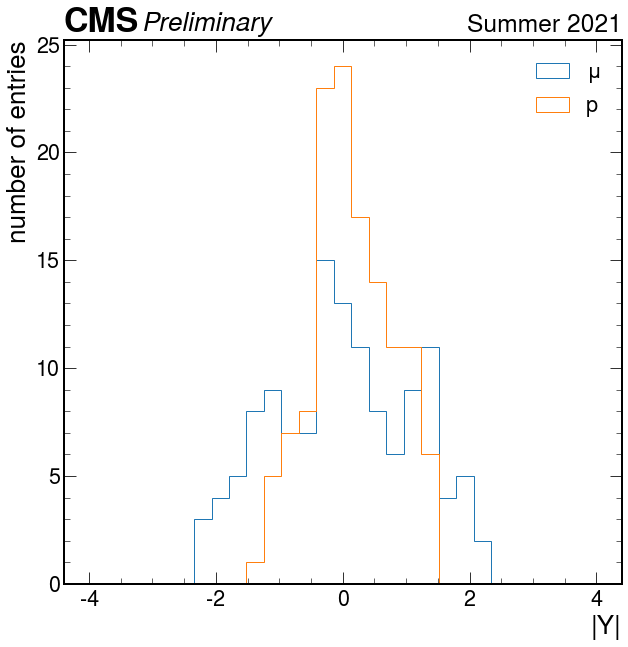

In [75]:
mu_eta = sig['yll'].values
pp_eta = sig['ypp'].values
f, ax = plt.subplots()

bins = np.linspace(-4,4,30)
plt.hist(mu_eta,bins,histtype='step',label = '$\mu$',density = False)
plt.hist(pp_eta, bins, histtype='step',label ='p', density=False)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend() 
ax.set(xlabel='|Y|', ylabel='number of entries')
#plt.savefig('Week6/rapidity.png')

[Text(1, 14.0, 'rec_y - mu_y'), Text(58.5, 1, 'number of entries')]

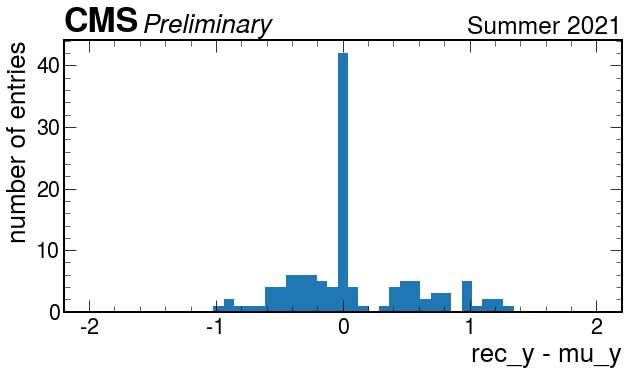

In [199]:
val = (pp_eta - mu_eta)/abs(mu_eta)
#print(val)
#print(pp_eta)
#print(mu_eta)
bins = np.linspace(-2,2,50)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
#ax.legend(); 
ax.set(xlabel=r'rec_y - mu_y', ylabel='number of entries')
#plt.xlim(-0.6,0.6)
#plt.savefig('Week6/eta_diff.png',bbox_inches='tight')

127


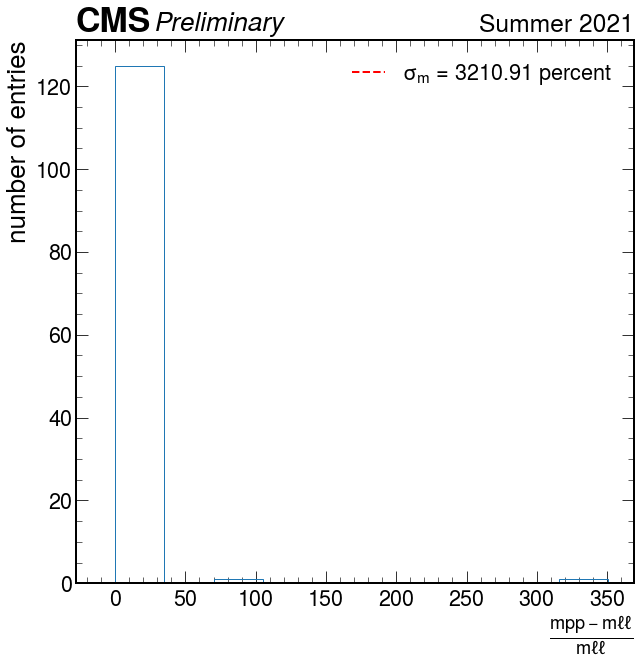

In [204]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
data = (sig['mpp'].values/sig['mll'].values)-1
#data = data[~np.isnan(data) & (abs(data) < 0.1)]
#data = data[data < 50]
#np.delete(data,max(data))
#data = data
print((len(data)))
bins = np.linspace(-10,10,54)
f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_m, sigma_m) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_m, sigma_m)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{m}$ = %2.2f percent'%(sigma_m*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel=r'$ \frac{mpp - m\ell\ell}{m\ell\ell}$', ylabel='number of entries')

ax.legend()
plt.savefig('Week6/fit_mass_ratio.png')

127


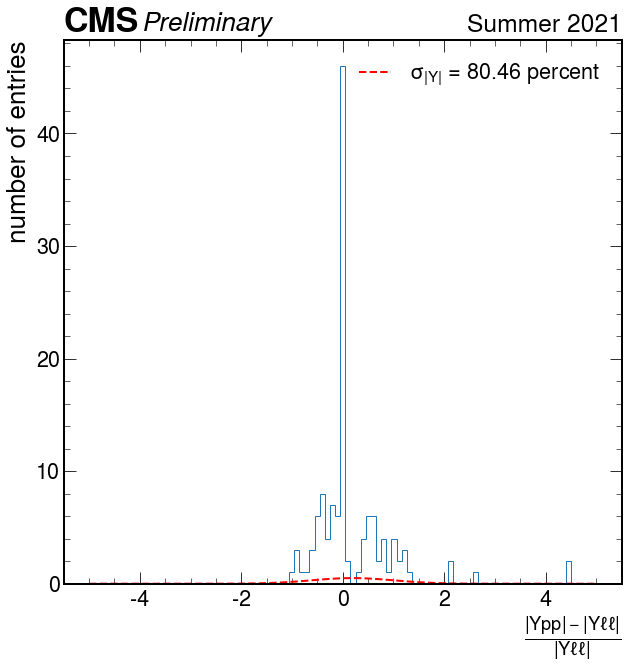

In [205]:
new_data = (sig['ypp'].values - sig['yll'].values)/abs(sig['yll'].values)

#new_data = data[~np.isnan(data) & (data < 0.1) & (data > -0.1) ]
#data = data[data <100]
#new_data = np.delete(data, np.where(data == np.max(data)) )
#new_data = np.delete(new_data,np.where(data == np.min(data)) )
print(len(new_data))
bins = np.linspace(-5,5,100)
#bins = np.linspace(-0.1,0.1,49)
f, ax = plt.subplots()
plt.hist(new_data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_y, sigma_y) = stats.norm.fit(new_data)
x=bins
y=stats.norm.pdf(x, mu_y, sigma_y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{|Y|}$ = %2.2f percent'%(sigma_y*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel=r'$\frac{|Ypp| - |Y\ell \ell|}{|Y\ell \ell|}$', ylabel='number of entries')

ax.legend()
plt.savefig('Week6/fit_eta_ratio.png')

In [114]:
#criteria for selection: |mpp-mll|<2sigma*mll
#sigma_m = 0.03
b = []
data = abs(bg['mpp']-bg['mll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*bg['mll'][i]):
        b = np.append(b,bg['mpp'][i])
#print(len(b))
m_acc_bg = len(b)/len(data)
print('acceptance rate from background mass:')
print(m_acc_bg)

s = []
data = abs(sig['mpp'] - sig['mll'])
#print(data)
#print(2*sigma_m*analysis['s_mll'])
#print(data)
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*sig['mll'][i]):
        s = np.append(s, sig['mpp'][i])

m_acc_s = len(s)/len(data)
print('acceptance rate from signal mass:')
print(m_acc_s)

acceptance rate from background mass:
0.03640319071791153
acceptance rate from signal mass:
0.4015748031496063


6895
251


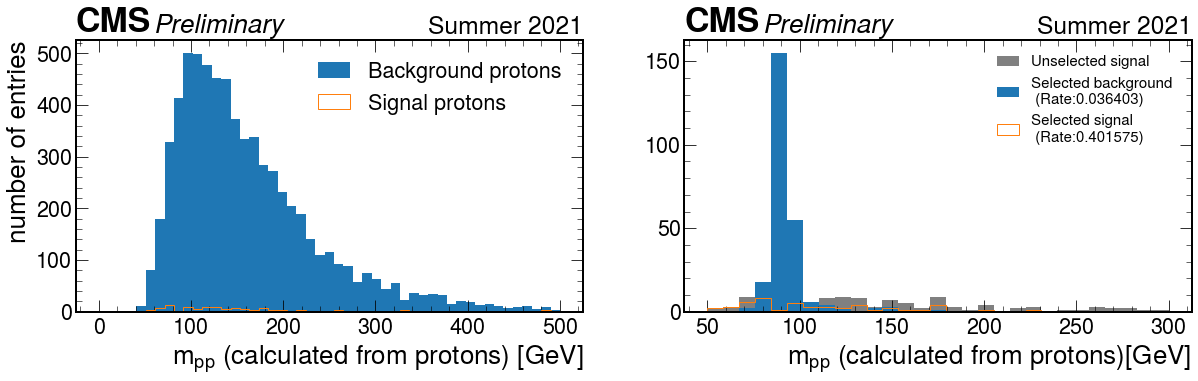

In [115]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(0,500,50)
ax[0].hist(bg['mpp'],bins,label='Background protons')
ax[0].hist(sig['mpp'],bins,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]', ylabel='number of entries')
ax[0].legend()
print(len(bg['mpp']))
print(len(b))
bins = np.linspace(50,300,30)
ax[1].hist(sig['mpp'],bins,color='grey',label='Unselected signal')
ax[1].hist(b, bins,label='Selected background \n (Rate:%6.6f)'%m_acc_bg)
ax[1].hist(s, bins,histtype='step',label='Selected signal \n (Rate:%6.6f)'%m_acc_s)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons)[GeV]')
ax[1].legend(fontsize=15)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    #ax[i].legend()
plt.savefig('Week6/surviving_protons_mass',bbox_inches='tight')

In [116]:
#criteria for selection: |ypp-yll|<2sigma*mll
b = []
data = abs(bg['ypp']-bg['yll'])

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*bg['yll'][i]): #the abs has no impact for the background !
        b = np.append(b,bg['ypp'][i])
#print(len(b))
y_acc_bg = len(b)/len(data)
print('acceptance rate from background eta:')
print(y_acc_bg)

s = []
#print(len(analysis['s_yll']))
data = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*sig['yll'][i]): #but if I leave it out here, I have 0 for the signal acceptance!
        s = np.append(s, sig['ypp'][i])
#print(len(s))
y_acc_s = len(s)/len(data)
print('acceptance rate from signal eta:')
print(y_acc_s)

acceptance rate from background eta:
0.019579405366207395
acceptance rate from signal eta:
0.33858267716535434


6895
43
135


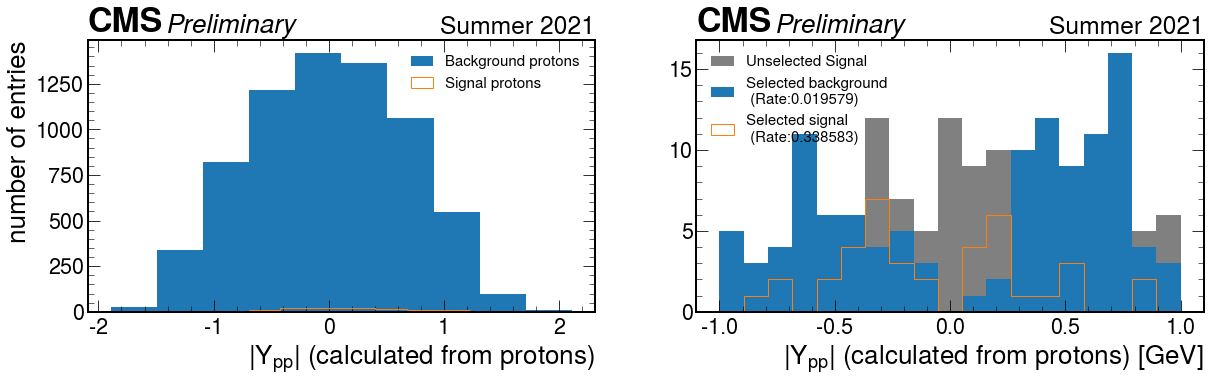

In [117]:

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-4,4,10)
print(len(bg['ypp']))
ax[0].hist(bg['ypp'],label='Background protons')
ax[0].hist(sig['ypp'], histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
binsb = np.linspace(-1,1,20)
print(len(s))
print(len(b))
ax[1].hist(sig['ypp'],binsb, color = 'grey', label='Unselected Signal')
ax[1].hist(b,binsb,label='Selected background \n (Rate:%6.6f)'%y_acc_bg)
ax[1].hist(s,binsb,histtype='step',label='Selected signal \n (Rate:%6.6f)'%y_acc_s)
ax[1].set(xlabel=r'$|Y_{pp}|$ (calculated from protons) [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week6/surviving_protons_eta', bbox_inches='tight')

In [118]:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            b_m = np.append(b_m,bg['mpp'][i])
            b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):        
            s_m = np.append(s_m, sig['mpp'][i])
            s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)
print(0.3937007874015748*0.29133858267716534)

acceptance rate from combined background cut:
0.0014503263234227702
acceptance rate from combined signal cut:
0.3228346456692913
0.1147002294004588


6895


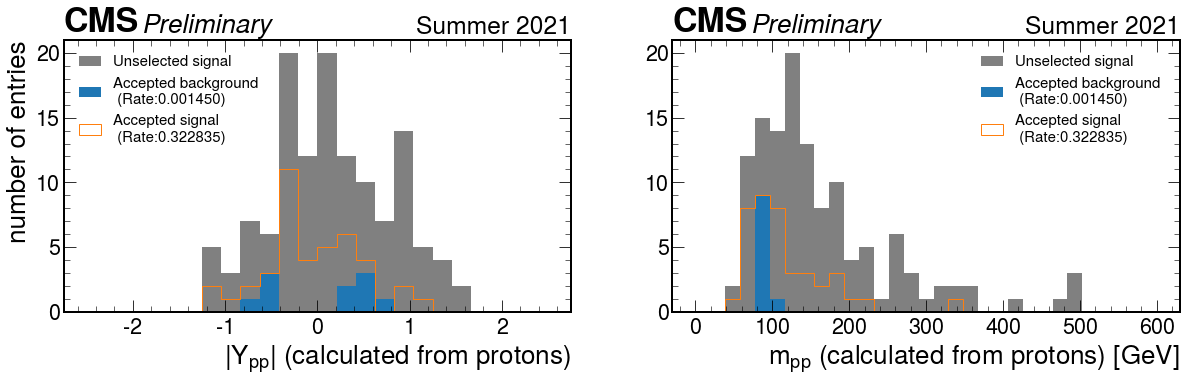

In [119]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-2.5,2.5,25)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal')
ax[0].hist(b_y,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal')
ax[1].hist(b_m,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week6/surviving_protons', bbox_inches='tight')

In [120]:
# And now we can finally re-write and correct the idea of timing correlation...nice

In [121]:
#define genproton_t variable to work with. (this is the tp1 tp2 which will be later will be used). proton time is given by:
#genproton_t=genvtx_t0+(zpps+genproton_vz)/c where zpps=2e5  (200m)
#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]
#for the signal it should agree, and for the background it should disagree. Here we will define a cut and complete step 2.

127


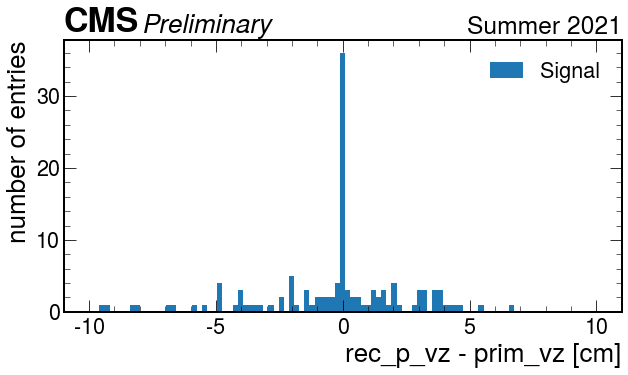

In [122]:
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
p1_t =  sig['evt_t0'].values + (  zpps - np.sign(sig['pr1_xi'].values)*sig['pr1_vz'].values)/c 
p2_t =  sig['evt_t0'].values + (  zpps + np.sign(sig['pr2_xi'].values)*sig['pr2_vz'].values)/c

mu_vz = - (p1_t - p2_t)*c/2 
vz_4D = sig['pr_vtx_z']

#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]

val = mu_vz - vz_4D
print(len(val))
bins = np.linspace(-10,10,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Signal')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'rec_p_vz - prim_vz [cm]', ylabel='number of entries')
#plt.xlim(-0.6,0.6)
plt.savefig('Week6/mu_4D_vz_diff.png',bbox_inches='tight')

6895


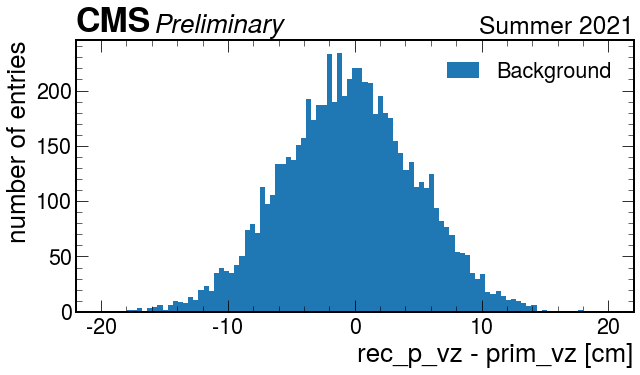

In [123]:
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
b_p1_t = np.random.normal(0,0.19) + (zpps - bg['pr1_vz'].values) / c
b_p2_t = np.random.normal(0,0.19) + (zpps + bg['pr2_vz'].values) / c

b_mu_vz = - (b_p1_t - b_p2_t)*c/2 
b_vz_4D = bg['pr_vtx_z']

#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]

val = b_mu_vz - b_vz_4D
print(len(val))
bins = np.linspace(-20,20,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'rec_p_vz - prim_vz [cm]', ylabel='number of entries')
#plt.xlim(-0.6,0.6)
plt.savefig('Week6/mu_4D_vz_diff_bg.png',bbox_inches='tight')

6895


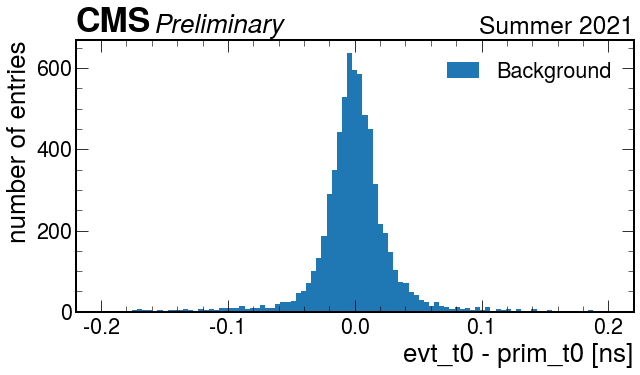

In [124]:
data = bg['evt_t0'].values - bg['pr_vtx_t'].values
print(len(data))
bins = np.linspace(-0.2,0.2,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'evt_t0 - prim_t0 [ns]', ylabel='number of entries')

plt.savefig('Week6/evt_4D_vt_diff_bg.png',bbox_inches='tight')

127


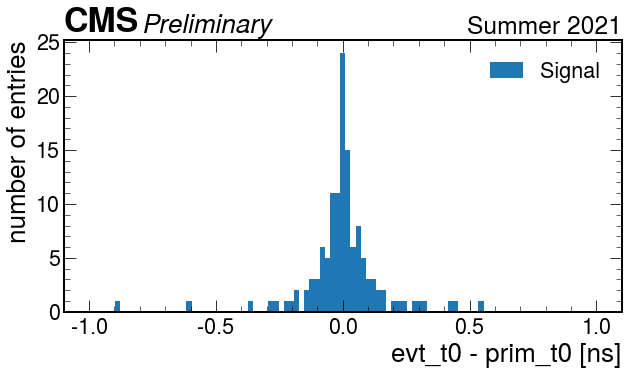

In [125]:
data = sig['evt_t0'].values - sig['pr_vtx_t'].values
print(len(data))
bins = np.linspace(-1,1,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'evt_t0 - prim_t0 [ns]', ylabel='number of entries')

plt.savefig('Week6/evt_4D_vt_diff.png',bbox_inches='tight')

37


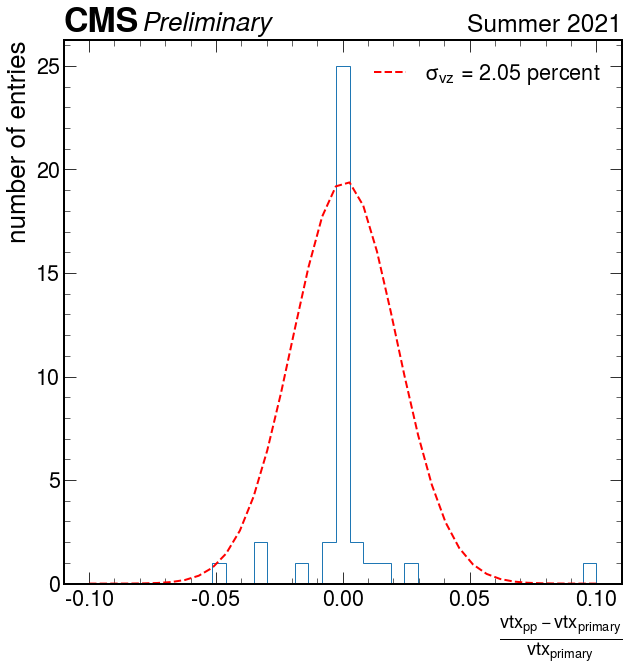

In [207]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
p1_t =  sig['evt_t0'].values + (  zpps - sig['pr1_vz'].values)/c 
p2_t =  sig['evt_t0'].values + (  zpps + sig['pr2_vz'].values)/c

pp_vz = - (p1_t - p2_t)*c/2 

vz_4D = sig['pr_vtx_z']


data = (pp_vz - vz_4D)/vz_4D
#print(data)
data = data[~np.isnan(data) & (data < 0.1) & (data > -0.1) ]
print((len(data)))
bins = np.linspace(-0.1,0.1,38)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_vz, sigma_vz) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_vz, sigma_vz)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{vz}$ = %2.2f percent'%(sigma_vz*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel=r'$\frac{vtx_{pp} - vtx_{primary}}{vtx_{primary}}$', ylabel='number of entries')

ax.legend()
plt.savefig('Week6/fit_vz_ratio.png')

In [208]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
#proton_t= sig['evt_t0'] + (np.average(sig['pr1_vz'].values + sig['pr2_vz'].values) + zpps)/c
#b_p1_t =  bg['evt_t0'].values + ( bg['pr1_vz'].values + zpps)/c # !!! evt_t0 is in ns - but it will cncel out in the next step anyway...
#b_p2_t =  bg['evt_t0'].values - ( bg['pr2_vz'].values - zpps)/c
#pr_t = np.random.normal(0,0.19) + (zpps - sgn(pr_z)*pr_vz) / c
b_p1_t = np.random.normal(0,0.19) + (zpps - bg['pr1_vz'].values) / c
b_p2_t = np.random.normal(0,0.19) + (zpps + bg['pr2_vz'].values) / c

b_pp_vz = - (b_p1_t - b_p2_t)*c/2 
print(b_mu_vz)
b_mu = (bg['mu1_vz'] + bg['mu2_vz'])/2
b_vz_4D = bg['pr_vtx_z'].values

data_bz = abs(b_pp_vz - b_vz_4D)

b_z = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
            b_z = np.append(b_z,b_pp_vz[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
#proton_t= sig['evt_t0'] + (np.average(sig['pr1_vz'].values + sig['pr2_vz'].values) + zpps)/c
p1_t =  sig['evt_t0'].values + (  zpps - sig['pr1_vz'].values)/c 
p2_t =  sig['evt_t0'].values + (  zpps + sig['pr2_vz'].values)/c

s_pp_vz = - (p1_t - p2_t)*c/2 

#mu_vz = (sig['pr1_vz'].values + zpps + sig['pr2_vz'].values - zpps)/2
s_vz_4D = sig['pr_vtx_z']

data_sz = abs(s_pp_vz - s_vz_4D)
s_z = []
for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
            s_z = np.append(s_z, s_pp_vz[i])
acc_sig =len(s_z)/len(data_sz)
print('acceptance rate from signal cut:')
print(acc_sig)

[1.40092947 6.86651392 3.06332715 ... 4.95009978 0.7248487  4.22010847]
acceptance rate from background cut:
0.013488034807831763
acceptance rate from signal cut:
0.2755905511811024


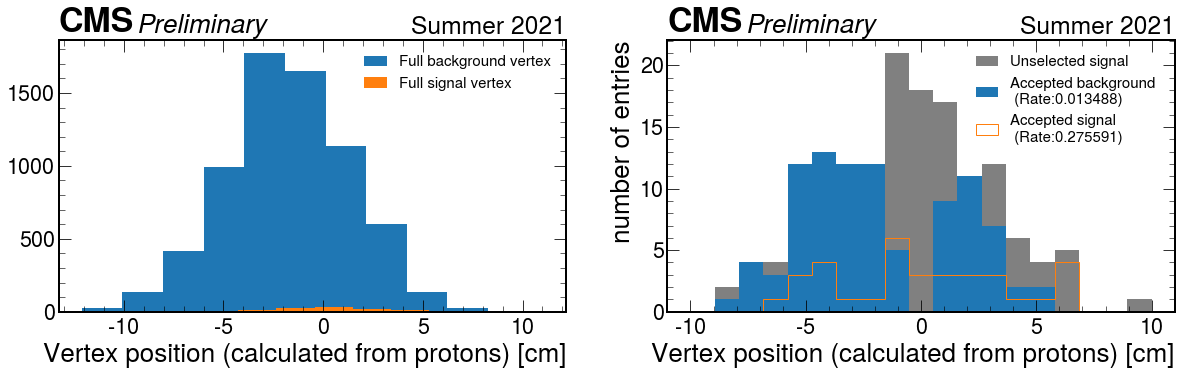

In [210]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(b_pp_vz, label = 'Full background vertex')
ax[0].hist(s_pp_vz, label='Full signal vertex')
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]')
#ax[0].set_xlim(-20,20)
bins = np.linspace(-10,10,20)

ax[1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal')
ax[1].hist(b_z, bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_z,bins, histtype = 'step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week6/surviving_protons_vz', bbox_inches='tight')

In [211]:
#Both kinematic and the spacial timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])
b_vz = []
b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
                b_vz = np.append(b_vz, b_pp_vz[i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_vz = []
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]): 
            if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
                s_m = np.append(s_m, sig['mpp'][i])
                s_y = np.append(s_y, sig['ypp'][i])
                s_vz = np.append(s_vz,s_pp_vz[i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)

acceptance rate from combined background cut:
0.011457577955039884
acceptance rate from combined signal cut:
0.06299212598425197


6895


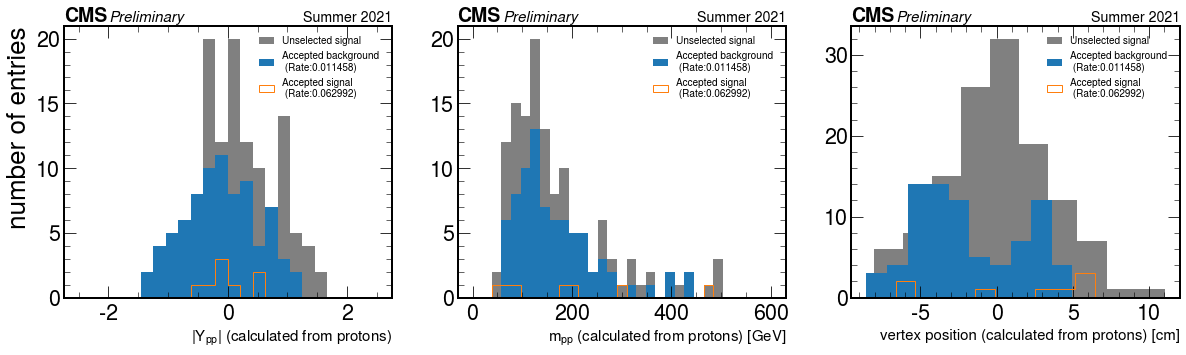

In [212]:
f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2.5,2.5,25)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal')
ax[0].hist(b_y,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal')
ax[1].hist(b_m,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[2].hist(s_pp_vz, color = "grey",label='Unselected signal')
ax[2].hist(b_vz, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[2].hist(s_vz, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[2].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=10)
    ax[i].xaxis.label.set_size(15)
plt.savefig('Week6/surviving_protons_kin_vz', bbox_inches='tight')

In [235]:
#Super insecure about this one !
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
#zpp = +-234m
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
print(zpps/c)
mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
mu1_t = masked_analysis['mu1_t'].values 
mu2_t = masked_analysis['mu2_t'].values 

p1_t =  masked_analysis['evt_t0'].values + (  zpps - np.sign(masked_analysis['pr1_xi'].values)*masked_analysis['pr1_vz'].values)/c 
p2_t =  masked_analysis['evt_t0'].values + (  zpps + np.sign(masked_analysis['pr2_xi'].values)*masked_analysis['pr2_vz'].values)/c
evt_t = masked_analysis['evt_t0'].values
tpp =  (( p1_t + p2_t) - 2*zpps/c)/2

tmu =  ( mu1_t + mu2_t)/2
#to avoid the devision by 0 and keep same array lengths
np.where(tmu == 0)
tmu = np.delete(tmu, 27)
tpp = np.delete(tpp, 27)

780.5411752148157


77


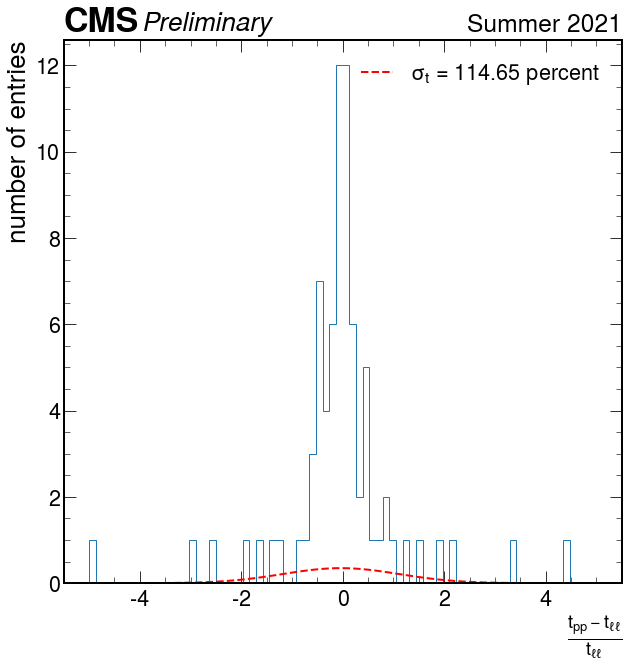

In [241]:
data = (tpp-tmu)/tmu
#print((data))
data = data[~np.isnan(data) & ~np.isneginf(data) & (abs(data) < 5)  ]
print(len(data))
bins = np.linspace(-5,5,77)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %2.2f percent'%(sigma_t*100))
#print(y)
#print(x)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel=r'$\frac{t_{pp} - t_{\ell\ell}}{t_{\ell\ell}}$', ylabel='number of entries')

ax.legend()
plt.savefig('Week6/fit_vertex_t.png')

In [133]:
#timing
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
mask_measured_time = (bg['mu1_t'] >-80) & (bg['mu2_t']>-80)
b_masked_analysis=bg[mask_measured_time]

mu1_t = b_masked_analysis['mu1_t'].values 
mu2_t = b_masked_analysis['mu2_t'].values 

b_tmu = (mu1_t+mu2_t)/2 
#print(len(b_masked_analysis['pr1_vz'].values))

b_p1_t = np.random.normal(0,0.19) + (zpps - b_masked_analysis['pr1_vz'].values) / c
b_p2_t = np.random.normal(0,0.19) + (zpps + b_masked_analysis['pr2_vz'].values) / c
b_tpp = (( b_p1_t + b_p2_t) - 2*zpps/c)/2

#print(b_tpp)

data_bt = abs(b_tpp - b_tmu)

b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t*s_b_mu[i]):
            b_t = np.append(b_m,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu1 = masked_analysis['mu1_t'].values 
tmu2 = masked_analysis['mu2_t'].values 

p1_t =  masked_analysis['evt_t0'].values + (  zpps - np.sign(masked_analysis['pr1_xi'].values)*masked_analysis['pr1_vz'].values)/c 
p2_t =  masked_analysis['evt_t0'].values + (  zpps + np.sign(masked_analysis['pr2_xi'].values)*masked_analysis['pr2_vz'].values)/c

s_tpp =(( p1_t + p2_t) - 2*zpps/c)/2
s_tmu = ( mu1_t + mu2_t)/2

data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t*s_tmu[i]):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

acceptance rate from background cut:
0.00021168501270110075
acceptance rate from signal cut:
1.0


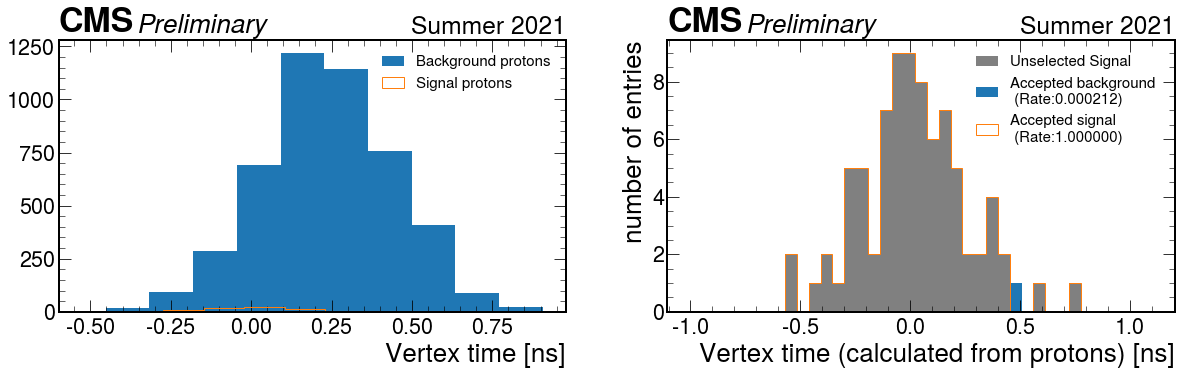

In [134]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(b_tpp, label = 'Background protons')
ax[0].hist(s_tpp,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'Vertex time (calculated from protons) [ns]')
#ax[0].set_xlim(-20,20)
bins=np.linspace(-1,1.1,40)
ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t, bins,label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week6/surviving_protons_t', bbox_inches='tight')

In [135]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t*(b_tmu[i])):
        if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
                b_z = np.append(b_z,b_mu_vz[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t*(s_tmu[i])):
        if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
                s_z = np.append(s_z, s_mu_vz[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

acceptance rate from background cut:
0.018416596104995766
acceptance rate from signal cut:
0.2345679012345679


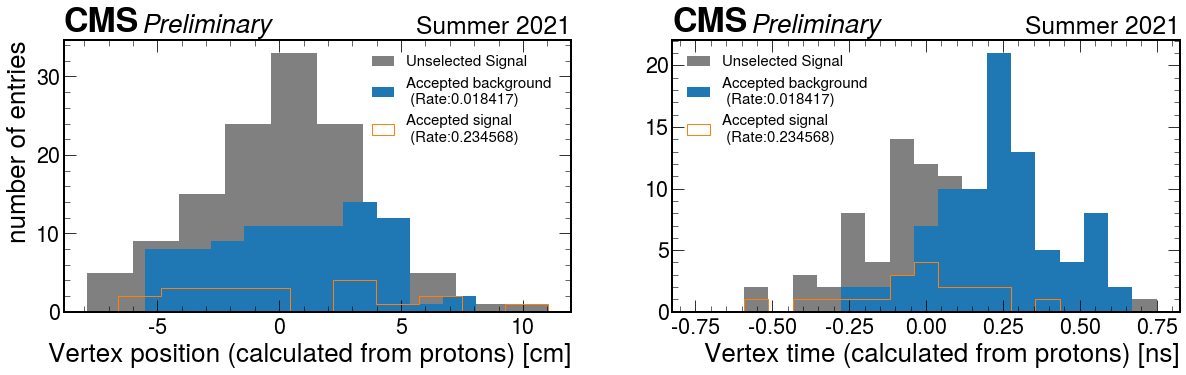

In [136]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
#bins = np.linspace(-4,4,10)
ax[0].hist(s_mu_vz, color= 'grey', label = 'Unselected Signal')
ax[0].hist(b_z, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_z, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')
bins = np.linspace(-0.75,0.75,20)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')

ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins,histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week6/surviving_protons_tvz', bbox_inches='tight')

In [137]:
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t*(b_tmu[i])):
        if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
            if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                b_t = np.append(b_t,b_tpp[i])
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
              
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t*(s_tmu[i])):
        if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
            if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                    s_t = np.append(s_t, s_tpp[i])
                    s_m = np.append(s_m, sig['mpp'][i])
                    s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)

acceptance rate from combined background cut:
0.001905165114309907
acceptance rate from combined signal cut:
0.2716049382716049


6895


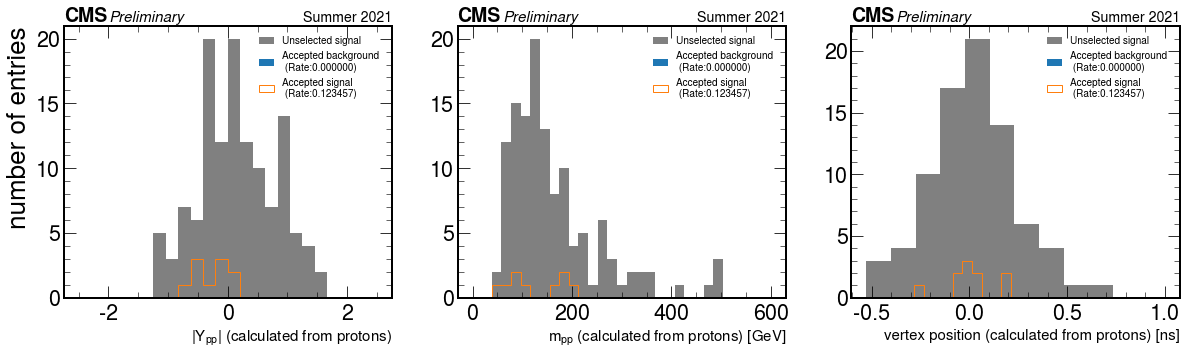

In [151]:
f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2.5,2.5,25)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal')
ax[0].hist(b_y,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal')
ax[1].hist(b_m,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[2].hist(s_tpp, color = "grey",label='Unselected signal')
ax[2].hist(b_t, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[2].hist(s_t, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[2].set(xlabel=r'vertex position (calculated from protons) [ns]')


for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", fontsize = 15,ax=ax[i])
    ax[i].legend(fontsize=10)
    ax[i].xaxis.label.set_size(15)
plt.savefig('Week6/surviving_protons_kin_t', bbox_inches='tight')

In [ ]:
#All kinematic and timing
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
b_vz= []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t*(b_tmu[i])):
        if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):           
            if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
                if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                    b_t = np.append(b_t,b_tpp[i])
                    b_z = np.append(b_z,b_pp_vz[i])
                    b_m = np.append(b_m,bg['mpp'][i])
                    b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
s_vz= []             
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t*(s_tmu[i])):  
        if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
            if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
                if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                        s_t = np.append(s_t, s_tpp[i])
                        s_z = np.append(s_z, s_pp_vz[i])
                        s_m = np.append(s_m, sig['mpp'][i])
                        s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)

In [ ]:
f, ax = plt.subplots(2,2,figsize=(15,10),sharey=False)
bins = np.linspace(-2,2,25)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0][0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal')
ax[0][0].hist(b_y,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0][0].hist(s_y,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0][0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][0].hist(sig['mpp'],bins, color = "grey",label='Unselected signal')
ax[1][0].hist(b_m,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1][0].hist(s_m,bins, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1][0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[0][1].hist(s_tpp, color = "grey",label='Unselected signal')
ax[0][1].hist(b_t, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0][1].hist(s_t, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0][1].set(xlabel=r'vertex position (calculated from protons) [ns]')

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][1].hist(s_mu_vz, color = "grey",label='Unselected signal')
ax[1][1].hist(b_vz, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1][1].hist(s_vz, histtype='step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1][1].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(2):
    for j in range(2):
        hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i][j], fontsize = 15)
        ax[i][j].legend(fontsize=10)
        ax[i][j].xaxis.label.set_size(15)
figure.tight_layout(pad=3.0)
plt.savefig('Week6/surviving_protons_kin_tvz', bbox_inches='tight')

15296


[Text(1, 14.0, 'Number of protons in event'),
 Text(34.5, 1, 'number of entries')]

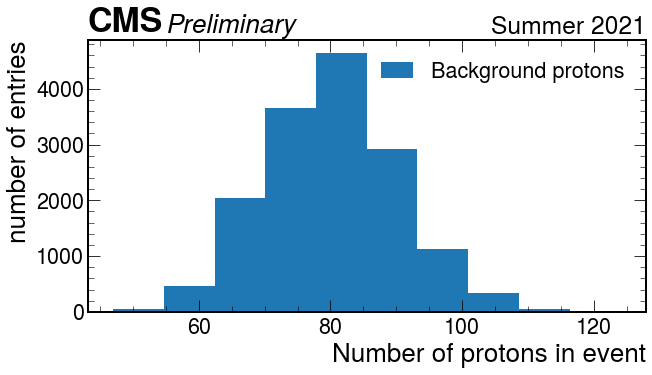

In [141]:
N = len(bg_protons)
print(N)
N_protons = []
for i in range(N):
    N_protons.append(len(bg_protons.genproton_pz[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_protons, label='Background protons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of protons in event', ylabel='number of entries')
#plt.savefig('W5/Bg_number_protons_all.png',bbox_inches='tight')

15296


[Text(1, 14.0, 'Number of muons in event'), Text(34.5, 1, 'number of entries')]

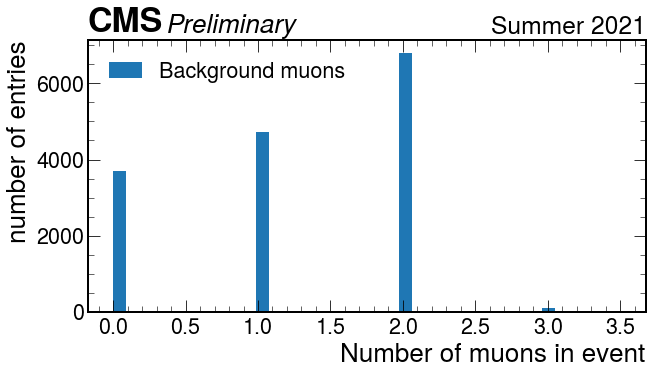

In [142]:
N = len(bg_muons)
print(N)
N_muons = []
for i in range(N):
    N_muons.append(len(bg_muons.pfcand_pt[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_muons, bins=np.linspace(0,3.5,40),label='Background muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('AnalyseW2/Bg_number_muons_signal.png',bbox_inches='tight')

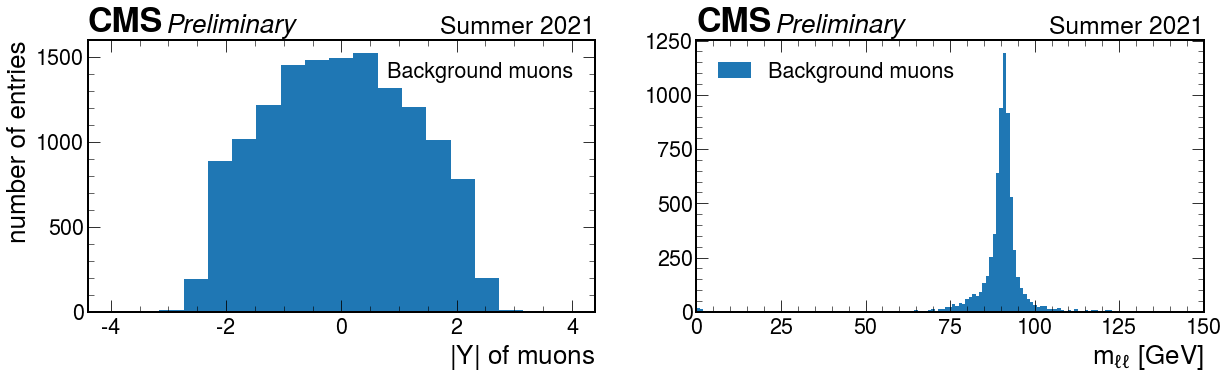

In [143]:
#print(bg_anal['mpp'].values)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
ax[0].hist(np.concatenate([bg['mu1_eta'].values,bg['mu2_eta'].values]),bins=np.linspace(-4,4,20), label='Background muons')
ax[0].set(xlabel=r'$|Y|$ of muons', ylabel='number of entries')
#ax[0].set_ylim(0,1200)

ax[1].hist(bg['mll'].values, bins=np.linspace(0,150,150),label='Background muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')
ax[1].set_xlim(0,150)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
#plt.savefig('AnalyseW2/bg_dimuon_analysis_corrected.png',bbox_inches='tight')

NameError: name 'analysis' is not defined

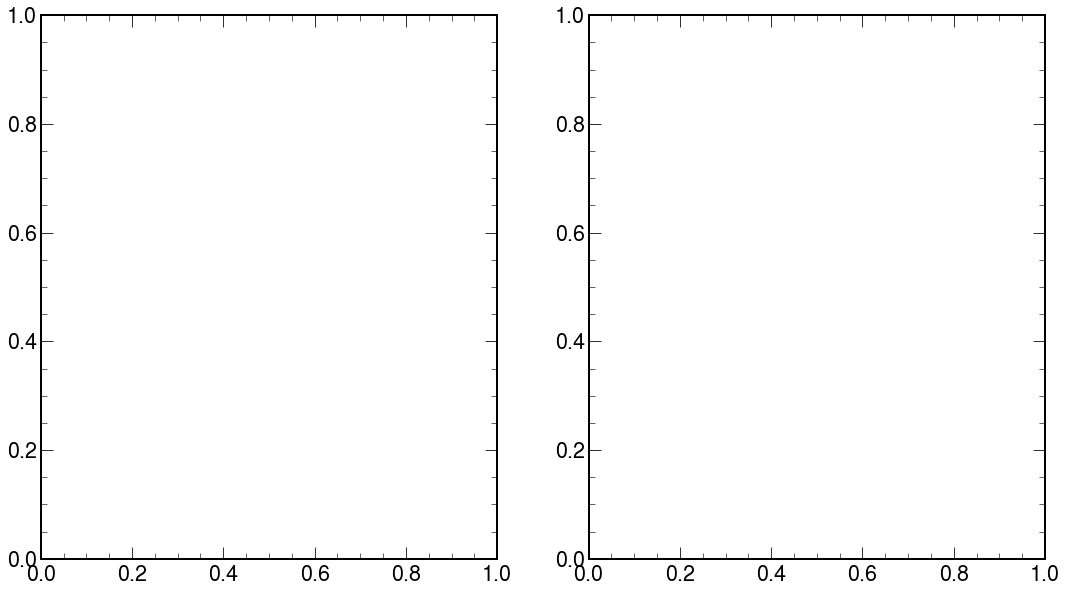

In [109]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))

h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(b_proton, b_muon, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
axes[1].set_ylim(0,700)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg')

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))
m = []
for i in range(0,64):
    m = np.append(m,b_muon[i])
print(len(m))
h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(muon, m, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'signal $m_{\ell \ell}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg_corre')